In [1]:
%matplotlib inline
import os
import re
import glob
import json
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from datetime import datetime
from typing import Sequence, Optional

from matplotlib import colormaps
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import TwoSlopeNorm

from scipy.stats import linregress, mannwhitneyu

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
from aind_analysis_arch_result_access.han_pipeline import get_mle_model_fitting
from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_analysis import get_session_name_from_path
from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import (
    annotate_movement_timing,
    add_lick_metadata_to_movements,
)

In [2]:
# # Core Utilities For Rasters
# # =========================

# def get_events_dict(df_trials, df_licks, tongue_kinematics):
#     return {
#         'goCue': (
#             df_trials,
#             'goCue_start_time_in_session',
#             'trial'
#         ),
#         'firstLick': (
#             df_licks,
#             'timestamps',
#             'trial',
#             {'cue_response': True}  # Only include cue-response licks
#         ),
#         'firstMove': (
#             tongue_kinematics,
#             'time_in_session',
#             'trial',
#             {'min_after_cue': True}  # Only movements after go cue
#         ),
#         'reward': (
#             df_trials,
#             'reward_time_in_session',
#             'trial'
#             # No filters needed unless you want to restrict rewarded trials
#         )
#     }

# def generate_event_times(df, time_col, trial_col, filters=None, cue_times=None):
#     """
#     Extracts a single event time per trial based on filtering and trial structure.

#     Parameters:
#         df (DataFrame): Source dataframe containing time data.
#         time_col (str): Name of the column with event timestamps.
#         trial_col (str): Column indicating trial identity.
#         filters (dict): Optional filters. 
#                         Special keys include 'cue_response' and 'min_after_cue'.
#         cue_times (dict): Dict of trial -> go cue time, used for filtering.

#     Returns:
#         dict: trial_id -> event_time
#     """
#     times = {}
#     for tr in df[trial_col].unique():
#         sub = df[df[trial_col] == tr].copy()
#         if filters:
#             for fcol, fval in filters.items():
#                 if fcol == 'cue_response':
#                     sub = sub[sub[fcol] == fval]
#                 elif fcol == 'min_after_cue':
#                     t0 = cue_times.get(tr, np.inf)
#                     sub = sub[sub[time_col] > t0]
#         if sub.empty:
#             continue
#         if 'movement_id' in sub.columns:
#             mid = sub['movement_id'].min()
#             t_event = sub[sub['movement_id'] == mid][time_col].min()
#         else:
#             t_event = sub[time_col].min()
#         times[tr] = t_event
#     return times


# def build_event_df(events_dict):
#     """
#     Constructs a DataFrame of event times for each trial.

#     Parameters:
#         events_dict (dict): event_name -> (df, time_col, trial_col[, filters])

#     Returns:
#         DataFrame: index = trials, columns = event times
#     """
#     if 'goCue' not in events_dict:
#         raise ValueError("events_dict must contain a 'goCue' entry")
    
#     cue_times = generate_event_times(*events_dict['goCue'])
#     trials = sorted(cue_times.keys())
#     E = pd.DataFrame(index=trials)

#     for name, params in events_dict.items():
#         df, time_col, trial_col, *rest = params
#         filt = rest[0] if rest else {}
#         times = generate_event_times(df, time_col, trial_col, filt, cue_times)
#         E[name] = pd.Series(times)

#     return E.astype(float)


# def sort_trials_by_latency(trials, event_times, event1, event2):
#     """
#     Sorts trials by the latency between two events.

#     Parameters:
#         trials (list): Trial IDs.
#         event_times (dict): event_name -> {trial_id -> time}.
#         event1, event2 (str): Event names to compute latency.

#     Returns:
#         list: Sorted trial IDs.
#     """
#     return sorted(
#         [
#             tr for tr in trials
#             if np.isfinite(event_times[event1].get(tr, np.nan))
#             and np.isfinite(event_times[event2].get(tr, np.nan))
#         ],
#         key=lambda tr: event_times[event1][tr] - event_times[event2][tr]
#     )


# # =========================
# # Spike Raster Matrix
# # =========================

# def compute_raster_matrix(spikes, trial_ids, event_times, pre=1.0, post=2.0, bin_size=0.001):
#     """
#     Converts spike times to a trial-by-time bin raster matrix.

#     Parameters:
#         spikes (1D array): All spike times.
#         trial_ids (list): List of trial IDs.
#         event_times (dict): trial_id -> alignment time.
#         pre, post (float): Time before/after event to include (seconds).
#         bin_size (float): Time bin width in seconds.

#     Returns:
#         tuple: (raster matrix, bin centers, trial_ids)
#     """
#     n_trials = len(trial_ids)
#     n_bins = int(np.round((pre + post) / bin_size))
#     raster = np.zeros((n_trials, n_bins), dtype=np.uint8)
#     bins = np.linspace(-pre, post, n_bins, endpoint=False) + bin_size / 2

#     for i, tr in enumerate(trial_ids):
#         t0 = event_times.get(tr, np.nan)
#         if np.isnan(t0):
#             continue
#         rel = spikes - t0
#         sel = (rel >= -pre) & (rel < post)
#         rel = rel[sel]
#         idx = ((rel + pre) / bin_size).astype(int)
#         for j in idx:
#             if 0 <= j < n_bins:
#                 raster[i, j] += 1
#     return raster, bins, trial_ids


# # =========================
# # Plotting Utilities
# # =========================

# def plot_spikes(raster, bins, ax=None, color='black'):
#     """
#     Plot spike raster given binary/count matrix.

#     Parameters:
#         raster (2D array): Trials x time bins.
#         bins (1D array): Time bin centers.
#         ax (Axes): Optional matplotlib axis.
#         color (str): Line color.

#     Returns:
#         Axes: Modified axis.
#     """
#     if ax is None:
#         fig, ax = plt.subplots()
#     for i, row in enumerate(raster):
#         spk_idx = np.nonzero(row)[0]
#         ax.vlines(bins[spk_idx], i + 0.5, i + 1.5, color=color)
#     return ax


# def plot_event_lines(ax, ordered_trials, events):
#     """
#     Overlay event-aligned lines on spike raster plot.

#     Parameters:
#         ax (Axes): Matplotlib axis.
#         ordered_trials (list): List of trial indices in display order.
#         events (dict): event_name -> {'times': {trial_idx: t_rel}, 'style': dict}

#     Returns:
#         Axes: Modified axis.
#     """
#     n = len(ordered_trials)
#     for name, info in events.items():
#         times_dict = info['times']
#         style = info.get('style', {})
#         for i in range(n):
#             t_rel = times_dict.get(i)
#             if t_rel is not None:
#                 style = info.get('style', {}).copy()
#                 if i == 0:
#                     style['label'] = name
#                 ax.axvline(t_rel, ymin=i/n, ymax=(i+1)/n, **style)
#     return ax


# # =========================
# # RasterPlotter Class
# # =========================

# class RasterPlotter:
#     """
#     Encapsulates raster generation and plotting routines.
#     """

#     def __init__(self, spikes, trial_ids, event_times, pre=1.0, post=2.0, bin_size=0.001):
#         self.spikes = spikes
#         self.trial_ids = trial_ids
#         self.event_times = event_times
#         self.pre = pre
#         self.post = post
#         self.bin_size = bin_size
#         self.raster, self.bins, self.ordered = compute_raster_matrix(
#             spikes, trial_ids, event_times, pre, post, bin_size
#         )

#     def plot_raster(self, ax=None, spike_color='black'):
#         """
#         Plot spike raster only.
#         """
#         ax = plot_spikes(self.raster, self.bins, ax=ax, color=spike_color)
#         ax.set_xlim(-self.pre, self.post)
#         ax.set_ylim(0.5, len(self.ordered) + 0.5)
#         ax.set_ylabel('Trial')
#         ax.set_xlabel('Time (s)')
#         return ax

#     def add_events(self, ax, events):
#         """
#         Add vertical event lines to an existing raster.
#         """
#         return plot_event_lines(ax, self.ordered, events)

#     def plot_with_events(self, events, ax=None, spike_color='black'):
#         """
#         Plot raster with overlaid event markers.
#         """
#         ax = self.plot_raster(ax=ax, spike_color=spike_color)
#         ax = self.add_events(ax, events)
#         return ax


# # =========================
# # PSTH Utilities
# # =========================

# def compute_psth(raster, bin_size=0.001, trials=None, as_rate=True):
#     """
#     Compute a Peri-Stimulus Time Histogram (PSTH) from spike raster.

#     Parameters:
#         raster (2D array): Trials x time bins.
#         bin_size (float): Width of time bin in seconds.
#         trials (list): Optional list of trial indices to include.
#         as_rate (bool): If True, normalize to spikes/sec.

#     Returns:
#         tuple: (psth, trial_count)
#     """
#     if trials is not None:
#         data = raster[trials, :]
#         count = len(trials)
#     else:
#         data = raster
#         count = raster.shape[0]

#     psth = data.sum(axis=0)
#     if as_rate:
#         psth = psth / (bin_size * count)
#     return psth, count


# def smooth_vector(vec, bin_size, sigma=0.025):
#     """
#     Apply causal Gaussian smoothing to a vector.

#     Parameters:
#         vec (1D array): Input signal.
#         bin_size (float): Bin size in seconds.
#         sigma (float): Std dev of Gaussian in seconds.

#     Returns:
#         1D array: Smoothed signal.
#     """
#     L = int(np.ceil(3 * sigma / bin_size))
#     lags = np.arange(L+1) * bin_size
#     gauss = np.exp(-0.5 * (lags / sigma) ** 2)
#     gauss /= gauss.sum()
#     smooth = np.convolve(vec, gauss, mode='full')[:len(vec)]
#     return smooth


# def plot_psth(
#     bins,
#     psth,
#     psth_smooth=None,
#     ax=None,
#     label='PSTH',
#     plot_raw=True,
#     color=None,
# ):
#     """
#     Plot raw and/or smoothed PSTH.

#     Parameters
#     ----------
#     bins : 1D array
#         Time bin centers.
#     psth : 1D array
#         Raw PSTH.
#     psth_smooth : 1D array, optional
#         Smoothed PSTH.
#     ax : matplotlib Axes, optional
#         Axis to plot into. If None, a new figure/axis is created.
#     label : str
#         Legend label.
#     plot_raw : bool, default=True
#         Whether to plot the raw PSTH trace.
#     color : str, optional
#         Matplotlib color for the trace(s). If None, uses default cycle.

#     Returns
#     -------
#     ax : matplotlib Axes
#         The axis containing the plot.
#     """
#     if ax is None:
#         fig, ax = plt.subplots(figsize=(6, 4))

#     if plot_raw and psth is not None:
#         ax.plot(bins, psth, label=label, color=color)

#     if psth_smooth is not None:
#         # Use same label if raw is hidden, otherwise append
#         lbl = label if not plot_raw else f"{label} (smoothed)"
#         ax.plot(bins, psth_smooth, label=lbl, color=color)

#     ax.axvline(0, color='k', linestyle='--')
#     ax.set_xlabel('Time (s)')
#     ax.set_ylabel('Firing rate (spk/s)')
#     ax.legend()
#     return ax



In [3]:
# #wrappers

# def make_rp_and_events(
#     spikes,
#     trials: list,
#     event_dicts: dict,
#     align_by: str,
#     sort_by: str,
#     events_to_plot: Sequence[str] = None,
#     pre: float = 1.0,
#     post: float = 2.0,
#     bin_size: float = 0.001,
# ):
#     """
#     spikes           : 1D array of spike times
#     trials           : list of trial IDs (Ev.index)
#     event_dicts      : {event_name -> {trial_id -> absolute_time}}
#     align_by         : which event to align each trial on
#     sort_by          : which event to sort trials by (latency from align_by)
#     events_to_plot   : subset of event_names to overlay (defaults to all but align_by)
#     pre, post, bin_size : raster params
#     """
#     # 1) sort trials
#     ordered = sort_trials_by_latency(
#         trials=trials,
#         event_times=event_dicts,    # can look up both sort_by & align_by
#         event1=sort_by,
#         event2=align_by,
#     )

#     # 2) make raster aligned to align_by
#     align_times = event_dicts[align_by]
#     rp = RasterPlotter(spikes, ordered, align_times,
#                        pre=pre, post=post, bin_size=bin_size)

#     # 3) pick events
#     if events_to_plot is None:
#         events_to_plot = [e for e in event_dicts if e != align_by]

#     # 4) build relative‐time dicts
#     events = {}
#     for ix, name in enumerate(events_to_plot):
#         times_rel = {}
#         for i, tr in enumerate(ordered):
#             t_abs = event_dicts[name].get(tr)
#             t0    = align_times.get(tr)
#             if t_abs is not None and t0 is not None:
#                 times_rel[i] = t_abs - t0
#         events[name] = {
#             'times': times_rel,
#             'style': {'color': f"C{ix}", 'linestyle':'--', 'linewidth':2}
#         }

#     return rp, events


# def plot_unit_panels(spikes, unit_n,
#                      trials,
#                      event_dicts,
#                      combos,
#                      events_to_plot=None,
#                      pre=1.0,
#                      post=2.0,
#                      bin_size=0.001,
#                      sigma=0.025):
#     """
#     spikes         : 1D array of spike times
#     trials         : list of trial IDs
#     event_dicts    : {event_name -> {trial_id -> event_time}}
#     combos         : list of (align_by, sort_by) pairs
#     events_to_plot : list of event_names to overlay (defaults to all but align_by)
#     """
#     fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex='col')

#     for col, (align_by, sort_by) in enumerate(combos):
#         # build the RasterPlotter + event overlays
#         rp, events = make_rp_and_events(
#             spikes,
#             trials,
#             event_dicts,
#             align_by=align_by,
#             sort_by=sort_by,
#             events_to_plot=events_to_plot,  # or None to use all but align_by
#             pre=pre,
#             post=post,
#             bin_size=bin_size
#         )

#         # top row: raster + event lines
#         ax_r = axes[0, col]
#         rp.plot_raster(ax=ax_r, spike_color='black')
#         rp.add_events(ax_r, events)
#         ax_r.set_title(f'align: {align_by}   sort: {sort_by}')
#         if col == 0:
#             ax_r.set_ylabel('Trial')
#             ax_r.legend(loc='upper left', title='Events')
#         ax_r.set_xlabel(None)

#         # bottom row: PSTH
#         ax_p = axes[1, col]
#         psth, _    = compute_psth(rp.raster, bin_size=rp.bin_size)
#         psth_sm    = smooth_vector(psth, bin_size=rp.bin_size, sigma=sigma)
#         plot_psth(rp.bins, psth, psth_sm, ax=ax_p, label='PETH')
#         if col == 0:
#             ax_p.set_ylabel('Firing rate (spk/s)')
#         ax_p.set_xlabel(f'Time from {align_by} (s)')
#     plt.suptitle(f'Unit {unit_n}', fontsize=16)
#     plt.tight_layout()
#     return fig

In [4]:
# #load ephys data
# with open('/root/capsule/data/LC-NE_scratch_data_06-14-2025/combined/combine_unit_tbl/combined_unit_tbl_06122025.pkl', 'rb') as file:
#     combined_ephys_data = pickle.load(file)

In [5]:
#load ephys data
with open('/root/capsule/data/LC-NE_scratch_data/combined/combine_unit_tbl/combined_unit_tbl.pkl', 'rb') as file:
    combined_ephys_data = pickle.load(file)

In [6]:
from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_analysis import session_already_done

# get sessions with relevant tongue tracking quality


# ---- criteria ----
COVERAGE_MIN = 95.0
DURATION50_MIN = 0.06  # seconds

# # ---- roots to scan ----
# base_dirs = [
#     Path("/root/capsule/data/keypoint_tracking_bottomview_LCrecordings_OOD"),
#     Path("/root/capsule/data/keypoint_tracking_bottomview_LCrecordings_ID"),
# ]

base_dirs = [Path("/root/capsule/scratch/session_analysis_halloween"),]

rows = []
for base_dir in base_dirs:
    if not base_dir.exists():
        continue
    for subdir in base_dir.iterdir():
        if not (subdir.is_dir() and session_already_done(subdir)):
            continue

        json_file = subdir / "tongue_quality_stats.json"
        try:
            with open(json_file, "r") as f:
                d = json.load(f)
        except Exception as e:
            print(f"Skipping {subdir} (couldn't read JSON): {e}")
            continue

        cov = float(d.get("coverage_pct", 0.0))
        dur50 = float(d.get("percentiles", {}).get("duration", {}).get("0.5", 0.0))

        if cov > COVERAGE_MIN and dur50 > DURATION50_MIN:
            rows.append({
                "session_path": subdir,
                "json_path": json_file,
                "session_id": d.get("session_id", subdir.name),
                "coverage_pct": cov,
                "duration_p50": dur50,
            })

# ---- results ----
filtered_df = pd.DataFrame(rows).sort_values(
    ["coverage_pct", "duration_p50"], ascending=[False, False]
)

print(f"Sessions meeting criteria (coverage>{COVERAGE_MIN}, median duration>{DURATION50_MIN}s): {len(filtered_df)}")
for p in filtered_df["session_path"]:
    print(p)

# If you want both a list and a table for downstream use:
filtered_session_paths = filtered_df["session_path"].tolist()

Sessions meeting criteria (coverage>95.0, median duration>0.06s): 32
/root/capsule/scratch/session_analysis_halloween/behavior_782394_2025-04-23_10-51-14
/root/capsule/scratch/session_analysis_halloween/behavior_782394_2025-04-24_12-07-31
/root/capsule/scratch/session_analysis_halloween/behavior_782394_2025-04-25_11-13-18
/root/capsule/scratch/session_analysis_halloween/behavior_761038_2025-04-15_10-24-57
/root/capsule/scratch/session_analysis_halloween/behavior_752014_2025-03-28_11-04-56
/root/capsule/scratch/session_analysis_halloween/behavior_751769_2025-01-16_11-31-52
/root/capsule/scratch/session_analysis_halloween/behavior_716325_2024-05-31_10-31-14
/root/capsule/scratch/session_analysis_halloween/behavior_758017_2025-02-06_11-26-09
/root/capsule/scratch/session_analysis_halloween/behavior_782394_2025-04-22_10-53-22
/root/capsule/scratch/session_analysis_halloween/behavior_758017_2025-02-07_14-11-05
/root/capsule/scratch/session_analysis_halloween/behavior_751769_2025-01-18_10-15

In [7]:
from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_analysis import get_session_name_from_path

# ---- tiny helpers ----
def get_session_prefix(s: str) -> str:
    # 'behavior_751004_2024-12-20_13-26-07' -> 'behavior_751004_2024-12-20'
    return re.sub(r'_\d{2}-\d{2}-\d{2}$', '', s)

DEFAULT_CRITERIA = {
    "isi_violations": {"bounds": [0.0, 0.1]},
    "p_max":         {"bounds": [0.5, 1.0]},
    "lat_max_p":     {"bounds": [0.005, 0.02]},
    "eu":            {"bounds": [0.0, 0.25]},
    "corr":          {"bounds": [0.95, 1.0]},
    "qc_pass":       {"items":  [True]},
    "peak":          {"bounds": [-1000, 0]},
    "trial_count":   {"bounds": [100, 2000]},
    "in_df":         {"items":  [True]},
}

def filter_by_criteria(df: pd.DataFrame, criteria: dict = None) -> pd.DataFrame:
    if criteria is None:
        criteria = DEFAULT_CRITERIA
    mask = pd.Series(True, index=df.index)
    for col, rule in criteria.items():
        if "bounds" in rule:
            lo, hi = rule["bounds"]
            mask &= df[col].between(lo, hi, inclusive="both")
        if "items" in rule:
            mask &= df[col].isin(rule["items"])
    return df.loc[mask].copy()

# =========================
# 1) get session ids
# =========================
# done_sessions should already be defined
session_order_full   = [get_session_name_from_path(str(p)) for p in filtered_session_paths]
session_prefix_order = [get_session_prefix(s) for s in session_order_full]
session_prefix_allow = set(session_prefix_order)

# =========================
# 2) filter ephys
# =========================
# ensure session_prefix exists on both tables
combined_ephys_data = combined_ephys_data.copy()
combined_ephys_data["session_prefix"] = combined_ephys_data["session"].map(get_session_prefix)

criteria_filtered = filter_by_criteria(combined_ephys_data, DEFAULT_CRITERIA)

# final filtered units = criteria + allowed session prefixes
filtered_ephys = criteria_filtered.loc[
    criteria_filtered["session_prefix"].isin(session_prefix_allow)
].copy()

# =========================
# 3) session summary
# =========================
counts_before = combined_ephys_data.groupby("session_prefix").size().rename("units_before")
counts_after  = criteria_filtered.groupby("session_prefix").size().rename("units_after")

base = pd.concat([counts_before, counts_after], axis=1).reindex(session_prefix_order)
base["units_before"] = base["units_before"].astype("Int64")        # keep NA if not present before
base["units_after"]  = base["units_after"].fillna(0).astype(int)   # 0 if none survived

session_summary = base.reset_index().rename(columns={"index": "session_prefix"})

# =========================
# prints / outputs
# =========================
print(f"Filtered units: {len(filtered_ephys)} / {len(combined_ephys_data)}")
print(session_summary.to_string(index=False))

# if you want variables available downstream:
# - filtered_ephys
# - session_summary
# - session_order_full, session_prefix_order


Filtered units: 84 / 13944
            session_prefix  units_before  units_after
behavior_782394_2025-04-23           243            9
behavior_782394_2025-04-24           394            7
behavior_782394_2025-04-25           116            0
behavior_761038_2025-04-15           435            2
behavior_752014_2025-03-28           254            1
behavior_751769_2025-01-16           229            1
behavior_716325_2024-05-31           281            3
behavior_758017_2025-02-06           127            1
behavior_782394_2025-04-22           270            0
behavior_758017_2025-02-07           231            4
behavior_751769_2025-01-18           255            5
behavior_754897_2025-03-14           117            5
behavior_751004_2024-12-20           248            3
behavior_751766_2025-02-11           277            5
behavior_761038_2025-04-18           253            2
behavior_761038_2025-04-16           192            3
behavior_751004_2024-12-22           110            1
b

In [8]:
# # === Threshold sweep: map (coverage_min, duration50_min) -> #units (after criteria) ===
# # Assumes `combined_ephys_data` is in memory.
# # Uses your DEFAULT_CRITERIA and helpers as given in your snippet.

# import json, re
# from pathlib import Path
# import numpy as np
# import pandas as pd

# from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_analysis import (
#     session_already_done, get_session_name_from_path
# )

# # ---------- helpers ----------
# def get_session_prefix(s: str) -> str:
#     # 'behavior_751004_2024-12-20_13-26-07' -> 'behavior_751004_2024-12-20'
#     return re.sub(r'_\d{2}-\d{2}-\d{2}$', '', s)

# DEFAULT_CRITERIA = {
#     "isi_violations": {"bounds": [0.0, 0.1]},
#     "p_max":         {"bounds": [0.5, 1.0]},
#     "lat_max_p":     {"bounds": [0.005, 0.02]},
#     "eu":            {"bounds": [0.0, 0.25]},
#     "corr":          {"bounds": [0.95, 1.0]},
#     "qc_pass":       {"items":  [True]},
#     "peak":          {"bounds": [-1000, 0]},
#     "trial_count":   {"bounds": [100, 2000]},
#     "in_df":         {"items":  [True]},
# }

# def filter_by_criteria(df: pd.DataFrame, criteria: dict = None) -> pd.DataFrame:
#     if criteria is None:
#         criteria = DEFAULT_CRITERIA
#     mask = pd.Series(True, index=df.index)
#     for col, rule in criteria.items():
#         if "bounds" in rule:
#             lo, hi = rule["bounds"]
#             mask &= df[col].between(lo, hi, inclusive="both")
#         if "items" in rule:
#             mask &= df[col].isin(rule["items"])
#     return df.loc[mask].copy()

# # # ---------- 0) load session quality once ----------
# # base_dirs = [
# #     Path("/root/capsule/scratch/session_analysis_out_of_distribution_full"),
# #     Path("/root/capsule/scratch/session_analysis_in_distribution"),
# # ]

# sess_rows = []
# for base_dir in base_dirs:
#     if not base_dir.exists():
#         continue
#     for subdir in base_dir.iterdir():
#         if not (subdir.is_dir() and session_already_done(subdir)):
#             continue
#         json_file = subdir / "tongue_quality_stats.json"
#         try:
#             with open(json_file, "r") as f:
#                 d = json.load(f)
#         except Exception:
#             continue

#         cov = float(d.get("coverage_pct", 0.0))
#         dur50 = float(d.get("percentiles", {}).get("duration", {}).get("0.5", 0.0))
#         sname = d.get("session_id", subdir.name)
#         sess_rows.append({
#             "session_path": str(subdir),
#             "session_id": sname,
#             "session_prefix": get_session_prefix(get_session_name_from_path(str(subdir))),
#             "coverage_pct": cov,
#             "duration_p50": dur50,
#         })

# sessions_qc = pd.DataFrame(sess_rows)

# # Short-circuit if nothing found
# if sessions_qc.empty:
#     print("No completed sessions found with readable tongue_quality_stats.json")
#     threshold_map = pd.DataFrame(columns=["coverage_min","duration50_min","n_sessions","n_units_after"])
# else:
#     # ---------- 1) prepare ephys once ----------
#     combined_ephys_data = combined_ephys_data.copy()
#     combined_ephys_data["session_prefix"] = combined_ephys_data["session"].map(get_session_prefix)

#     # Apply unit-level criteria once
#     criteria_filtered = filter_by_criteria(combined_ephys_data, DEFAULT_CRITERIA)

#     # ---------- 2) define thresholds to sweep ----------
#     coverage_grid  = list(range(0, 96, 5))  # 0,10,...,90 (%)
#     duration_grid  = [0.040, 0.050, 0.060, 0.070, 0.080, 0.090, 0.100]  # seconds

#     # ---------- 3) sweep and count ----------
#     rows = []
#     for cov_min in coverage_grid:
#         for dur_min in duration_grid:
#             allowed = sessions_qc.loc[
#                 (sessions_qc["coverage_pct"] >= cov_min) &
#                 (sessions_qc["duration_p50"] >= dur_min),
#                 "session_prefix"
#             ].unique()

#             # units surviving criteria AND in allowed sessions
#             n_units = int(criteria_filtered["session_prefix"].isin(allowed).sum())
#             n_sess  = int(len(allowed))

#             rows.append({
#                 "coverage_min": cov_min,
#                 "duration50_min": dur_min,
#                 "n_sessions": n_sess,
#                 "n_units_after": n_units,
#             })

#     threshold_map = pd.DataFrame(rows).sort_values(["coverage_min","duration50_min"]).reset_index(drop=True)

#     # Optional: quick pivot for heatmap-like viewing
#     threshold_pivot = threshold_map.pivot(index="coverage_min", columns="duration50_min", values="n_units_after")

# # # ---------- outputs ----------
# # print("Threshold → #units (after criteria):")
# # print(threshold_map.to_string(index=False))

# # print("\nPivot (#units_after): rows=coverage_min, cols=duration50_min")
# # print(threshold_pivot)


In [9]:
# units_per_session = (
#     criteria_filtered
#     .groupby("session", as_index=False)
#     .agg(n_units=("unit", "count"))
# )

# units_per_session = units_per_session.sort_values("session", ascending=True)
# units_per_session.to_csv("/root/capsule/scratch/units_per_session.csv", index=False)


In [10]:


# # assumes you already have `threshold_map` from above

# # --- prepare data ---
# coverage_vals = sorted(threshold_map["coverage_min"].unique())
# duration_vals = sorted(threshold_map["duration50_min"].unique())
# Z = threshold_map.pivot(index="coverage_min", columns="duration50_min", values="n_units_after")

# fig, ax = plt.subplots(figsize=(7, 5))

# im = ax.imshow(Z.values, origin="lower", cmap="viridis")

# # label each cell with its count
# for i, cov in enumerate(coverage_vals):
#     for j, dur in enumerate(duration_vals):
#         val = Z.iloc[i, j]
#         text_color = "white" if val < Z.values.max() * 0.5 else "black"
#         ax.text(j, i, f"{int(val)}", ha="center", va="center", color=text_color, fontsize=8)

# # --- axis / layout ---
# ax.set_xticks(np.arange(len(duration_vals)))
# ax.set_xticklabels([f"{d:.3f}" for d in duration_vals])
# ax.set_xlabel("Median duration threshold (s)")

# ax.set_yticks(np.arange(len(coverage_vals)))
# ax.set_yticklabels([f"{c}%" for c in coverage_vals])
# ax.set_ylabel("Lick coverage threshold")

# cbar = plt.colorbar(im, ax=ax, label="# Units after filtering")
# ax.set_title("Number of Units by Coverage × Duration50 Threshold")

# plt.tight_layout()
# plt.show()



# import matplotlib.pyplot as plt
# import numpy as np

# # assumes you already have `threshold_map` from before

# # --- prepare data ---
# coverage_vals = sorted(threshold_map["coverage_min"].unique())
# duration_vals = sorted(threshold_map["duration50_min"].unique())
# Z = threshold_map.pivot(index="coverage_min", columns="duration50_min", values="n_sessions")

# fig, ax = plt.subplots(figsize=(7, 5))

# im = ax.imshow(Z.values, origin="lower", cmap="cividis")

# # label each cell with its count
# for i, cov in enumerate(coverage_vals):
#     for j, dur in enumerate(duration_vals):
#         val = Z.iloc[i, j]
#         text_color = "white" if val < Z.values.max() * 0.5 else "black"
#         ax.text(j, i, f"{int(val)}", ha="center", va="center", color=text_color, fontsize=8)

# # --- axis / layout ---
# ax.set_xticks(np.arange(len(duration_vals)))
# ax.set_xticklabels([f"{d:.3f}" for d in duration_vals])
# ax.set_xlabel("Median duration threshold (s)")

# ax.set_yticks(np.arange(len(coverage_vals)))
# ax.set_yticklabels([f"{c}%" for c in coverage_vals])
# ax.set_ylabel("Lick coverage threshold")

# cbar = plt.colorbar(im, ax=ax, label="# Sessions meeting criteria")
# ax.set_title("Number of Sessions by Coverage × Duration50 Threshold")

# plt.tight_layout()
# plt.show()



In [11]:
# #single session data processing example
# with open('/root/capsule/data/LC-NE_scratch_data_06-14-2025/716325/behavior_716325_2024-05-31_10-31-14/ephys/opto/curated/behavior_716325_2024-05-31_10-31-14_curated_soma_opto_tagging_summary.pkl', 'rb') as file:
#     ephys_session_data = pickle.load(file)

# ephys_data = ephys_session_data[ephys_session_data['unit_id'].isin(session_units)].copy()

# first_go_cue_time = df_trials['goCue_start_time_raw'].iloc[0]

# ephys_data['spike_times_in_session'] = ephys_data['spike_times'].apply(lambda x: x - first_go_cue_time)

In [12]:
#load individual ephys data with spike times
# ROOT_SCRATCH = "/root/capsule/data/LC-NE_scratch_data_06-14-2025"
ROOT_SCRATCH = "/root/capsule/data/LC-NE_scratch_data"

def get_session_prefix(s: str) -> str:
    # 'behavior_751004_2024-12-20_13-26-07' -> 'behavior_751004_2024-12-20'
    return re.sub(r'_\d{2}-\d{2}-\d{2}$', '', s)

def get_animal_id(session: str) -> str:
    m = re.match(r'^behavior_(\d+)_', session)
    if not m:
        raise ValueError(f"Cannot parse animal id from session: {session}")
    return m.group(1)

def find_summary_pkl(root: str, session: str) -> Optional[Path]:  # <-- fixed
    """Try exact path; if missing, fall back to prefix glob search."""
    animal = get_animal_id(session)
    exact = Path(root) / animal / session / "ephys" / "opto" / "curated" / f"{session}_curated_soma_opto_tagging_summary.pkl"
    if exact.exists():
        return exact
    pref = get_session_prefix(session)
    candidates = list((Path(root) / animal).glob(f"{pref}_*/ephys/opto/curated/*_curated_soma_opto_tagging_summary.pkl"))
    return candidates[0] if candidates else None

# ---- main loop (same as before) ----
units_with_spikes = []
for session, subdf in filtered_ephys.groupby("session"):
    pkl_path = find_summary_pkl(ROOT_SCRATCH, session)
    if pkl_path is None:
        print(f"[skip] No summary .pkl found for {session}")
        continue

    with open(pkl_path, "rb") as f:
        ephys_session_data = pickle.load(f)
    if not isinstance(ephys_session_data, pd.DataFrame):
        try:
            ephys_session_data = pd.DataFrame(ephys_session_data)
        except Exception:
            print(f"[skip] Summary not a DataFrame for {session}")
            continue

    unit_ids = subdf["unit"].unique()
    ephys_data = (
        ephys_session_data[ephys_session_data["unit_id"].isin(unit_ids)]
        .copy()
        .assign(session=session)
    )
    print(f"[ok] {session}: {len(ephys_data)}/{len(unit_ids)} units with 'spike_times' column")
    units_with_spikes.append(ephys_data)

units_with_spikes = (
    pd.concat(units_with_spikes, ignore_index=True)
    if units_with_spikes else pd.DataFrame(columns=["session","unit_id","spike_times"])
)
print("Final units_with_spikes shape:", units_with_spikes.shape)


[ok] behavior_716325_2024-05-31_10-31-14: 3/3 units with 'spike_times' column
[ok] behavior_751004_2024-12-20_13-26-11: 3/3 units with 'spike_times' column
[ok] behavior_751004_2024-12-21_13-28-28: 3/3 units with 'spike_times' column
[ok] behavior_751004_2024-12-22_13-09-17: 1/1 units with 'spike_times' column
[ok] behavior_751004_2024-12-23_14-20-03: 2/2 units with 'spike_times' column
[ok] behavior_751181_2025-02-25_12-12-35: 2/2 units with 'spike_times' column
[ok] behavior_751181_2025-02-27_11-24-47: 5/5 units with 'spike_times' column
[ok] behavior_751766_2025-02-11_11-53-38: 5/5 units with 'spike_times' column
[ok] behavior_751766_2025-02-13_11-31-21: 3/3 units with 'spike_times' column
[ok] behavior_751766_2025-02-14_11-37-11: 4/4 units with 'spike_times' column
[ok] behavior_751769_2025-01-16_11-32-05: 1/1 units with 'spike_times' column
[ok] behavior_751769_2025-01-17_11-37-39: 3/3 units with 'spike_times' column
[ok] behavior_751769_2025-01-18_10-15-25: 5/5 units with 'spike_

In [13]:



def find_scratch_session_dir(session: str, roots: list[Path]) -> Path:
    """
    Return scratch folder for a session; try multiple roots.
    Looks for exact match first, then prefix glob.
    """
    pref = get_session_prefix(session)
    for root in roots:
        # exact match
        exact = root / session
        if exact.exists():
            return exact

        # prefix glob
        hits = sorted(root.glob(pref + "*"))
        if hits:
            return hits[0]

    raise FileNotFoundError(
        f"No scratch folder found in any root for session/prefix: {session} / {pref}"
    )


def load_intermediate_data(session_dir: Path) -> dict:
    """Load the four intermediate parquet tables for a session."""
    idir = session_dir / "intermediate_data"
    return {
        "movs":   pd.read_parquet(idir / "tongue_movs.parquet"),
        "trials": pd.read_parquet(idir / "nwb_df_trials.parquet"),
        "licks":  pd.read_parquet(idir / "nwb_df_licks.parquet"),
        "kins":   pd.read_parquet(idir / "tongue_kins.parquet"),
    }



In [53]:
# #raster plot, 3 panels/alignments per unit, pdf save

# # --- loop over units, loading per-session data on demand ---
# _per_session_cache = {}  # session -> dict with movs/trials/licks/kins

# PDF_PATH = Path("/root/capsule/scratch/figures/LC_movement_raster_psth_alignments.pdf")
# PDF_PATH.parent.mkdir(parents=True, exist_ok=True)

# with PdfPages(PDF_PATH) as pdf:

#     for row in units_with_spikes.itertuples(index=False):
#         session = row.session
#         unit_session = str(row.unit_id) +' ' + str(session)
#         spike_times = row.spike_times  # your per-unit spikes
#         if session not in _per_session_cache:
#             sdir = find_scratch_session_dir(session)
#             _per_session_cache[session] = load_intermediate_data(sdir)

#         data = _per_session_cache[session]
#         tongue_movements = data["movs"]
#         df_trials        = data["trials"]
#         df_licks         = data["licks"]
#         tongue_kinematics= data["kins"]

#         first_go_cue_time = df_trials['goCue_start_time_raw'].iloc[0]
#         spike_times_in_session = spike_times - first_go_cue_time

#         #events
#         events_dict = get_events_dict(df_trials, df_licks, tongue_kinematics)
#         E  = build_event_df(events_dict)
#         Ev = E.dropna(subset=['goCue','firstLick','firstMove']).copy()

#         #trial orders and combos
#         trials = list(Ev.index)
#         event_dicts = {name: Ev[name].to_dict() for name in Ev.columns}
#         combos = [
#             ('goCue',     'firstMove'),
#             ('firstMove', 'firstLick'),
#             ('firstLick', 'firstMove'),
#         ]

#         fig = plot_unit_panels(
#             spike_times_in_session,
#             unit_session,
#             trials,
#             event_dicts,
#             combos,
#             events_to_plot=['goCue', 'firstMove', 'firstLick', 'reward'],  # or None
#             pre=1.0,
#             post=2.0,
#             bin_size=0.001,
#             sigma=0.025
#         )
#         # plt.show()
#         pdf.savefig(fig, bbox_inches="tight")
#         plt.close(fig)



In [54]:
# #raster plot, cue response on movement 1 vs 2, pdf save


# # --- loop over units, loading per-session data on demand ---
# _per_session_cache = {}  # session -> dict with movs/trials/licks/kins

# PDF_PATH = Path("/root/capsule/scratch/figures/LC_movement_raster_psth_movenumber.pdf")
# PDF_PATH.parent.mkdir(parents=True, exist_ok=True)

# plt.ioff()  # (optional) speed up headless plotting

# with PdfPages(PDF_PATH) as pdf:
#     for row in units_with_spikes.itertuples(index=False):
#         session = row.session
#         unit_session = f"{row.unit_id} {session}"
#         spike_times = row.spike_times

#         # Load intermediate data (cached per session)
#         if session not in _per_session_cache:
#             sdir = find_scratch_session_dir(session)
#             _per_session_cache[session] = load_intermediate_data(sdir)

#         data = _per_session_cache[session]
#         tongue_movements = data["movs"].copy()
#         df_trials        = data["trials"]
#         df_licks         = data["licks"]
#         tongue_kinematics= data["kins"]

#         # Align spikes to session time
#         first_go_cue_time = df_trials['goCue_start_time_raw'].iloc[0]
#         spike_times_in_session = spike_times - first_go_cue_time

#         # --- events tables ---
#         events_dict = get_events_dict(df_trials, df_licks, tongue_kinematics)
#         E  = build_event_df(events_dict)
#         Ev = E.dropna(subset=['goCue','firstLick','firstMove']).copy()
#         if Ev.empty:
#             print(f"[skip] {unit_session}: no valid trials after dropping NaNs for goCue/firstLick/firstMove")
#             continue

#         # --- annotate movements per trial if not already annotated ---
#         if 'cue_response_movement_number' not in tongue_movements.columns:
#             tongue_movements = add_lick_metadata_to_movements(
#                 tongue_movements,
#                 df_licks,
#                 fields=['timestamps']
#             )
#             tongue_movements = tongue_movements.rename(columns={'timestamps': 'lick_time'})

#             # Annotate movements using trials
#             tongue_movements = annotate_movement_timing(tongue_movements, df_trials)


#         # Robust per-trial cue_response_movement_number
#         trial_crmn = (
#             tongue_movements.groupby('trial')['cue_response_movement_number']
#               .apply(lambda s: s.dropna().astype('Int64').iloc[0] if s.dropna().size else pd.NA)
#         )

#         trials_cr1 = set(trial_crmn[trial_crmn == 1].index.tolist())
#         trials_cr2 = set(trial_crmn[trial_crmn == 2].index.tolist())

#         # Keep only trials that exist in Ev
#         valid_trials = set(Ev.index)
#         trials_cr1 = sorted(trials_cr1 & valid_trials)
#         trials_cr2 = sorted(trials_cr2 & valid_trials)

#         # Order by latency to firstMove
#         sort_key = 'firstMove'
#         lat = (Ev[sort_key] - Ev['goCue']).dropna()
#         ordered_cr1 = sorted(trials_cr1, key=lambda tr: lat.get(tr, np.inf))
#         ordered_cr2 = sorted(trials_cr2, key=lambda tr: lat.get(tr, np.inf))

#         combined_trials = ordered_cr1 + ordered_cr2
#         split_idx = len(ordered_cr1)
#         if len(combined_trials) == 0:
#             print(f"[skip] {unit_session}: no trials in CR1/CR2 overlap with Ev")
#             continue

#         # Build event dicts
#         event_dicts = {n: Ev[n].to_dict() for n in Ev.columns}

#         # Raster aligned to goCue
#         align_key = 'goCue'
#         align_times = event_dicts[align_key]
#         rp = RasterPlotter(
#             spike_times_in_session,
#             combined_trials,
#             align_times,
#             pre=1.5, post=1.5, bin_size=0.001
#         )

#         # Relative event overlays
#         events = {}
#         for ix, name in enumerate(['goCue','firstMove','firstLick','reward']):
#             times_rel = {}
#             for i, tr in enumerate(combined_trials):
#                 t_abs = event_dicts[name].get(tr)
#                 t0    = align_times.get(tr)
#                 if t_abs is not None and t0 is not None:
#                     times_rel[i] = t_abs - t0
#             events[name] = {'times': times_rel,
#                             'style': {'color': f"C{ix}", 'linestyle':'--', 'linewidth':2}}

#         # Compute group PSTHs
#         raster_cr1 = rp.raster[:split_idx, :]   # CR==1
#         raster_cr2 = rp.raster[split_idx:, :]   # CR==2
#         psth1, _ = compute_psth(raster_cr1, bin_size=rp.bin_size)
#         psth2, _ = compute_psth(raster_cr2, bin_size=rp.bin_size)

#         # Smooth
#         psth1_sm = smooth_vector(psth1, bin_size=rp.bin_size, sigma=0.025)
#         psth2_sm = smooth_vector(psth2, bin_size=rp.bin_size, sigma=0.025)

#         # Plot
#         fig, (ax_raster, ax_psth) = plt.subplots(
#             2, 1, figsize=(8, 7), sharex=True,
#             gridspec_kw={'height_ratios':[3,1]}
#         )

#         # Raster
#         rp.plot_raster(ax_raster, spike_color='black')
#         rp.add_events(ax_raster, events)
#         ax_raster.axhline(split_idx, color='gray', linestyle=':', linewidth=1)
#         ax_raster.set_ylabel('Trials')

#         # Title = unit_session (as requested)
#         ax_raster.set_title(unit_session)

#         # PSTHs (smoothed only)
#         plot_psth(rp.bins, psth1, psth1_sm, ax=ax_psth, label='CR==1', plot_raw=False, color='black')
#         plot_psth(rp.bins, psth2, psth2_sm, ax=ax_psth, label='CR==2', plot_raw=False, color='gray')
#         ax_psth.set_xlabel('Time from goCue (s)')
#         ax_psth.set_ylabel('Firing rate (spk/s)')
#         ax_psth.legend(frameon=False)

#         plt.tight_layout()

#         # Save page to the multi-page PDF
#         pdf.savefig(fig, bbox_inches="tight")
#         plt.close(fig)

# print(f"✅ Saved {PDF_PATH}")


In [55]:
# #single unit example (CR1 vs CR2 raster + PSTH)

# _per_session_cache = {}  # session -> dict with movs/trials/licks/kins


# row = units_with_spikes.iloc[0]
# session = row.session
# spike_times = row.spike_times  # your per-unit spikes
# if session not in _per_session_cache:
#     sdir = find_scratch_session_dir(session)
#     _per_session_cache[session] = load_intermediate_data(sdir)

# data = _per_session_cache[session]
# tongue_movements = data["movs"]
# df_trials        = data["trials"]
# df_licks         = data["licks"]
# tongue_kinematics= data["kins"]

# first_go_cue_time = df_trials['goCue_start_time_raw'].iloc[0]
# spike_times_in_session = spike_times - first_go_cue_time

# #events
# events_dict = get_events_dict(df_trials, df_licks, tongue_kinematics)
# E  = build_event_df(events_dict)
# Ev = E.dropna(subset=['goCue','firstLick','firstMove']).copy()

# # # # trials
# # Add lick time from licks_df
# tongue_movements = add_lick_metadata_to_movements(
#     tongue_movements,
#     df_licks,
#     fields=['timestamps']
# )
# tongue_movements = tongue_movements.rename(columns={'timestamps': 'lick_time'})

# # Annotate movements using trials
# tongue_movements = annotate_movement_timing(tongue_movements, df_trials)

# # Robust per-trial cue_response_movement_number (take first non-null if duplicates)
# trial_crmn = (
#     tongue_movements.groupby('trial')['cue_response_movement_number']
#       .apply(lambda s: s.dropna().astype('Int64').iloc[0] if s.dropna().size else pd.NA)
# )
# trials_cr1 = set(trial_crmn[trial_crmn == 1].index.tolist())
# trials_cr2 = set(trial_crmn[trial_crmn == 2].index.tolist())

# # Keep only trials that exist in your events table Ev
# valid_trials = set(Ev.index)
# trials_cr1 = sorted(trials_cr1 & valid_trials)
# trials_cr2 = sorted(trials_cr2 & valid_trials)
# # latency
# sort_key = 'firstMove'
# lat = (Ev[sort_key] - Ev['goCue']).dropna()
# ordered_cr1 = sorted(trials_cr1, key=lambda tr: lat.get(tr, np.inf))
# ordered_cr2 = sorted(trials_cr2, key=lambda tr: lat.get(tr, np.inf))

# # Combined order for the *single* raster: CR==1 first (bottom), CR==2 second (top)
# combined_trials = ordered_cr1 + ordered_cr2
# split_idx = len(ordered_cr1)  # row index where CR==2 starts

# #plotting
# # Build align/event dicts just like your wrapper does
# event_dicts = {n: Ev[n].to_dict() for n in Ev.columns}

# # Raster aligned to goCue, sorted by firstMove within our combined order
# # (We already pre-sorted combined_trials, so pass as-is.)
# align_key = 'goCue'
# align_times = event_dicts[align_key]
# rp = RasterPlotter(
#     spike_times_in_session,
#     combined_trials,
#     align_times,
#     pre=1.5, post=1.5, bin_size=0.001
# )

# # Relative event overlays (goCue, firstMove, firstLick, reward)
# events = {}
# for ix, name in enumerate(['goCue','firstMove','firstLick','reward']):
#     times_rel = {}
#     for i, tr in enumerate(combined_trials):
#         t_abs = event_dicts[name].get(tr)
#         t0    = align_times.get(tr)
#         if t_abs is not None and t0 is not None:
#             times_rel[i] = t_abs - t0
#     events[name] = {'times': times_rel,
#                     'style': {'color': f"C{ix}", 'linestyle':'--', 'linewidth':2}}

# # Compute group PSTHs
# raster_cr1 = rp.raster[:split_idx, :]   # rows corresponding to CR==1
# raster_cr2 = rp.raster[split_idx:, :]   # rows corresponding to CR==2

# psth1, _ = compute_psth(raster_cr1, bin_size=rp.bin_size)  # CR==1
# psth2, _ = compute_psth(raster_cr2, bin_size=rp.bin_size)  # CR==2

# # Smooth
# psth1_sm = smooth_vector(psth1, bin_size=rp.bin_size, sigma=0.025)
# psth2_sm = smooth_vector(psth2, bin_size=rp.bin_size, sigma=0.025)

# # Plot with your function
# fig, (ax_raster, ax_psth) = plt.subplots(2, 1, figsize=(8, 7),
#                                          sharex=True,
#                                          gridspec_kw={'height_ratios':[3,1]})

# # Raster
# rp.plot_raster(ax_raster, spike_color='black')
# rp.add_events(ax_raster, events)
# ax_raster.set_title(f'Aligned to {align_key}; CR==1 (bottom) vs CR==2 (top); sorted by {sort_key} latency')
# ax_raster.axhline(split_idx, color='gray', linestyle=':', linewidth=1)
# ax_raster.set_ylabel('Trials')

# # PSTHs — only smoothed, with custom colors
# plot_psth(rp.bins, psth1, psth1_sm,
#           ax=ax_psth, label='CR==1',
#           plot_raw=False, color='black')
# plot_psth(rp.bins, psth2, psth2_sm,
#           ax=ax_psth, label='CR==2',
#           plot_raw=False, color='gray')

# ax_psth.set_xlabel('Time from goCue (s)')
# ax_psth.set_ylabel('Firing rate (spk/s)')
# ax_psth.legend(frameon=False)
# plt.tight_layout()
# plt.show()

analysis config for reaction time and spike count

In [14]:
# ---------- config ----------
from dataclasses import dataclass
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from typing import Dict, Optional, Tuple
from aind_dynamic_foraging_behavior_video_analysis.ephys.tongue_ephys import (get_events_dict, build_event_df)

@dataclass
class AnalysisConfig:
    align_key: str = "goCue"
    count_window_s: Tuple[float,float] = (0.0, 0.100)
    min_trials_per_group: int = 8
    only_cue_response_trials: bool = True
    latency_window_s: Optional[Tuple[float,float]] = None

# ---------- tiny utils ----------
def first_spike_latency_in_window(
    spike_times_sorted: np.ndarray, t0: float, window: Tuple[float, float]) -> Tuple[float, bool]:
    """
    Returns (first_spike_latency_s, had_spike_in_window).
    If no spike in [t0+window[0], t0+window[1]), latency is np.nan.
    """
    a, b = t0 + window[0], t0 + window[1]
    if not np.isfinite(a) or not np.isfinite(b):
        return np.nan, False

    i0 = np.searchsorted(spike_times_sorted, a, side="left")
    i1 = np.searchsorted(spike_times_sorted, b, side="left")

    if i0 < i1:  # at least one spike in [a,b)
        return float(spike_times_sorted[i0] - t0), True
    else:
        return np.nan, False

def count_spikes_in_window(spike_times_sorted: np.ndarray, t0: float, window: Tuple[float,float]) -> int:
    a, b = t0 + window[0], t0 + window[1]
    if not np.isfinite(a) or not np.isfinite(b):
        return 0
    i0 = np.searchsorted(spike_times_sorted, a, side="left")
    i1 = np.searchsorted(spike_times_sorted, b, side="left")
    return int(i1 - i0)

def mannwhitney_summary(x: np.ndarray, y: np.ndarray) -> dict:
    if len(x) == 0 or len(y) == 0:
        return dict(p=np.nan, U=np.nan, effect=np.nan)
    stat = mannwhitneyu(x, y, alternative="two-sided")
    eff = float(np.mean(x) - np.mean(y))
    return dict(p=float(stat.pvalue), U=float(stat.statistic), effect=eff)

# ---------- session stage ----------
def build_trial_features(movs: pd.DataFrame,
                         licks: pd.DataFrame,
                         df_trials: pd.DataFrame) -> pd.DataFrame:
    """
    Return per-trial features:
      - cue_response_movement_number (Int64)
      - reaction_time_firstmove (s)
      - reaction_time_cueresponse (s)

    Will (re)annotate movements if required columns are missing.
    """
    tm = movs.copy()

    # If any required columns are missing, (re)annotate
    required_cols = {
        "cue_response_movement_number",
        "movement_latency_from_go",
        "movement_number_in_trial",
        "cue_response",
    }
    if not required_cols.issubset(tm.columns):
        tm = add_lick_metadata_to_movements(tm, licks, fields=["timestamps"]).rename(
            columns={"timestamps": "lick_time"}
        )
        tm = annotate_movement_timing(tm, df_trials)

    # ---- Per-trial features ----
    # CRMN: identical within a trial by construction
    crmn = (
        tm.groupby("trial")["cue_response_movement_number"]
          .first()
          .astype("Int64")
    )

    # First-move RT: earliest latency in each trial
    rt_first = tm.groupby("trial")["movement_latency_from_go"].min()

    # Cue-response RT: prefer explicit cue_response==True
    if "cue_response" in tm.columns:
        rt_cr = (
            tm.loc[tm["cue_response"] == True]
              .groupby("trial")["movement_latency_from_go"]
              .first()
        )
    else:
        print("[warn] 'cue_response' column missing; falling back to movement_number_in_trial == CRMN")
        # Fallback: match movement_number_in_trial to CRMN
        tmp = tm.copy()
        tmp["movement_number_in_trial"] = pd.to_numeric(
            tmp["movement_number_in_trial"], errors="coerce"
        ).astype("Int64")
        tmp = tmp.join(crmn.rename("crmn"), on="trial")
        rt_cr = (
            tmp.loc[tmp["movement_number_in_trial"] == tmp["crmn"]]
               .groupby("trial")["movement_latency_from_go"]
               .first()
        )
    
    out = pd.DataFrame({
        "cue_response_movement_number": crmn,
        "reaction_time_firstmove": rt_first,
        "reaction_time_cueresponse": rt_cr,
    })

    # ---- kinematics pull-through ----
    kcols = ["peak_velocity", "mean_velocity", "excursion_angle_deg",'endpoint_x','endpoint_y']

    first_moves = (
        tm.loc[tm["movement_number_in_trial"] == 1, ["trial", *kcols]]
          .drop_duplicates("trial", keep="first")
          .set_index("trial")
          .rename(columns={c: f"first_move_{c}" for c in kcols})
    )

    cue_resp_moves = (
        tm.loc[tm["cue_response"] == True, ["trial", *kcols]]
          .drop_duplicates("trial", keep="first")
          .set_index("trial")
          .rename(columns={c: f"cue_response_{c}" for c in kcols})
    )

    out = (
        out.join(first_moves, how="left")
           .join(cue_resp_moves, how="left")
           .sort_index()
    )
    
    # Optional sanity check:
    # assert (tm.groupby("trial")["cue_response_movement_number"]
    #           .nunique(dropna=True) <= 1).all(), "Inconsistent CRMN within trial"
    return out


def make_session_bundle(session: str, cfg: AnalysisConfig):
    sdir = find_scratch_session_dir(session, roots=base_dirs)
    data = load_intermediate_data(sdir)  # returns dict: {movs,trials,licks,kins}
    movs = data["movs"]
    trials = data["trials"]
    licks = data["licks"]
    kins = data["kins"]

    # time offset to convert absolute spikes → session time
    # session_offset = float(trials["goCue_start_time_raw"].iloc[0]) ## NB: correcting due to cutting trial table:
    time_dif = kins["time_raw"] - kins["time_in_session"]
    # check that all differences are effectively the same
    if np.allclose(time_dif, time_dif.iloc[0], rtol=0, atol=1e-6):
        session_offset = float(time_dif.mean())
    else:
        raise ValueError(
            "time_raw and time_in_session are not separated by a constant offset."
        )

    # events table & alignment map
    events_dict = get_events_dict(trials, licks, kins)
    E = build_event_df(events_dict)         # index: trial
    if cfg.align_key not in E.columns:
        raise KeyError(f"align_key '{cfg.align_key}' not in events table: {list(E.columns)}")
    Ev = E.dropna(subset=[cfg.align_key])
    align_times = Ev[cfg.align_key].astype(float)  # Series: trial → t0 (s)

    # purely movement-derived per-trial features
    trial_features = build_trial_features(movs, licks, trials)

    # ---- Filter to only cue-response trials (one value per trial) ----
    if cfg.only_cue_response_trials:
        cr_trials = trial_features.index[trial_features["cue_response_movement_number"].notna()]
        # keep intersection with trials that have alignment
        keep = align_times.index.intersection(cr_trials)
        align_times   = align_times.loc[keep]
        Ev            = Ev.loc[keep]
        trial_features= trial_features.loc[keep]

    return {
        "session": session,
        "Ev": Ev,
        "align_times": align_times,
        "trial_features": trial_features,
        "session_offset": session_offset,
    }

# ---------- unit stage ----------
def analyze_unit_for_session(unit_row: pd.Series, bundle: dict, cfg: AnalysisConfig):
    session = bundle["session"]
    unit_id = unit_row["unit_id"]

    # spikes → session time
    spikes = np.asarray(unit_row["spike_times"], dtype=float) - bundle["session_offset"]

    # trials eligible for alignment
    trials = bundle["align_times"].index
    t0_map = bundle["align_times"].to_dict()

    # windows
    win_count = cfg.count_window_s
    win_lat = cfg.latency_window_s if cfg.latency_window_s is not None else cfg.count_window_s
    if not (np.isfinite(win_lat[0]) and np.isfinite(win_lat[1]) and win_lat[0] < win_lat[1]):
        win_lat = win_count

    dur = win_count[1] - win_count[0]

    # count per trial
    recs = []
    for tr in trials:
        t0 = t0_map.get(tr, np.nan)
        if not np.isfinite(t0):
            continue
        n = count_spikes_in_window(spikes, t0, win_count)
        first_spike_latency_s, had_spike_in_latency_win = first_spike_latency_in_window(spikes, t0, win_lat)
        recs.append({
            "unit_id": unit_id,
            "session": session,
            "trial": int(tr),
            "align_key": cfg.align_key,
            "win_start_s": win_count[0],
            "win_stop_s":  win_count[1],
            "spike_count": int(n),
            "spike_rate_hz": (n / dur) if dur > 0 else np.nan,
            "lat_win_start_s": win_lat[0],
            "lat_win_stop_s":  win_lat[1],
            "first_spike_latency_s": first_spike_latency_s,
            "had_spike_in_latency_win": had_spike_in_latency_win,
        })
    unit_counts = pd.DataFrame(recs).set_index("trial")

    # join movement features
    tf = bundle["trial_features"]
    unit_counts = unit_counts.join(tf, how="left")  # adds CRMN + both RTs

    # per-unit stats (CR1 vs CR2)
    x = unit_counts.loc[unit_counts["cue_response_movement_number"] == 1, "spike_count"].to_numpy()
    y = unit_counts.loc[unit_counts["cue_response_movement_number"] == 2, "spike_count"].to_numpy()
    if (len(x) >= cfg.min_trials_per_group) and (len(y) >= cfg.min_trials_per_group):
        test = mannwhitney_summary(x, y)
    else:
        test = dict(p=np.nan, U=np.nan, effect=np.nan)

    unit_summary = pd.Series({
        "unit_id": unit_id,
        "session": session,
        "align_key": cfg.align_key,
        "win_start_s": cfg.count_window_s[0],
        "win_stop_s": cfg.count_window_s[1],
        "n_trials_cr1": int(len(x)),
        "n_trials_cr2": int(len(y)),
        "mean_count_cr1": float(np.mean(x)) if len(x) else np.nan,
        "mean_count_cr2": float(np.mean(y)) if len(y) else np.nan,
        "diff_means_cr1_minus_cr2": test["effect"],
        "mannwhitney_U": test["U"],
        "p_value": test["p"],
    })

    # reset index for uniform concat later
    unit_counts = unit_counts.reset_index()

    return unit_counts, unit_summary


In [15]:

cfg = AnalysisConfig(align_key="goCue", count_window_s=(0.0, 0.100), min_trials_per_group=8)
bundle_cache: Dict[str, dict] = {}

all_counts = []
all_summaries = []

for u in units_with_spikes.itertuples(index=False):
    session = u.session
    if session not in bundle_cache:
        bundle_cache[session] = make_session_bundle(session, cfg)

    unit_counts, unit_summary = analyze_unit_for_session(pd.Series(u._asdict()), bundle_cache[session], cfg)
    all_counts.append(unit_counts)
    all_summaries.append(unit_summary)

all_counts_df = pd.concat(all_counts, ignore_index=True).sort_values(["session","unit_id","trial"])
all_stats_df  = pd.DataFrame(all_summaries).sort_values(["session","unit_id"])


In [16]:
FIG_DIR = Path("/root/capsule/scratch/figures/ephys")
SAVE_FIG = False


In [17]:
# #loop through windows, screening only
# from scipy.stats import spearmanr

# def _bh_fdr(pvals: np.ndarray, alpha: float = 0.05) -> np.ndarray:
#     """
#     Benjamini–Hochberg FDR control. Returns a boolean mask of discoveries.
#     """
#     p = np.asarray(pvals, dtype=float)
#     n = p.size
#     if n == 0:
#         return np.zeros(0, dtype=bool)
#     order = np.argsort(p)
#     ranked = p[order]
#     thresh = (np.arange(1, n+1) / n) * alpha
#     is_sig_sorted = ranked <= thresh
#     # ensure monotonicity
#     if is_sig_sorted.any():
#         k = np.max(np.where(is_sig_sorted)[0])
#         is_sig_sorted[:k+1] = True
#         is_sig_sorted[k+1:] = False
#     is_sig = np.zeros_like(is_sig_sorted, dtype=bool)
#     is_sig[order] = is_sig_sorted
#     return is_sig

# def score_window_metrics(unit_counts_df: pd.DataFrame,
#                          rt_col: str,
#                          min_trials_per_unit: int = 20,
#                          alpha: float = 0.05):
#     """
#     Compute per-unit Spearman rho(spike_count, RT) and aggregate metrics.
#     Returns (metrics_dict, unit_table).
#     """
#     rows = []
#     for (sess, uid), g in unit_counts_df.groupby(["session", "unit_id"]):
#         g = g.dropna(subset=["spike_count", rt_col])
#         if len(g) < min_trials_per_unit:
#             continue
#         rho, p = spearmanr(g["spike_count"], g[rt_col])
#         if np.isfinite(rho):
#             rows.append({
#                 "session": sess,
#                 "unit_id": uid,
#                 "rho": float(rho),
#                 "p": float(p),
#                 "n_trials": int(len(g))
#             })

#     if not rows:
#         return (
#             dict(n_units=0,
#                  mean_abs_rho=np.nan,
#                  median_abs_rho=np.nan,
#                  wmean_abs_rho=np.nan,
#                  mean_rho=np.nan,
#                  fisher_z_mean_rho=np.nan,
#                  frac_positive=np.nan,
#                  n_sig_p=0,
#                  n_sig_fdr=0),
#             pd.DataFrame(columns=["session","unit_id","rho","p","n_trials","sig_p","sig_fdr"])
#         )

#     df = pd.DataFrame(rows)
#     # significance flags
#     df["sig_p"]   = df["p"] < alpha
#     df["sig_fdr"] = _bh_fdr(df["p"].values, alpha=alpha)

#     # aggregates
#     mean_abs   = float(df["rho"].abs().mean())
#     med_abs    = float(df["rho"].abs().median())
#     wmean_abs  = float(np.average(df["rho"].abs(), weights=df["n_trials"]))
#     mean_rho   = float(df["rho"].mean())
#     # Fisher z average (atanh), then back-transform (tanh)
#     z = np.arctanh(np.clip(df["rho"].values, -0.999999, 0.999999))
#     fisher_z_mean_rho = float(np.tanh(z.mean()))
#     frac_pos  = float((df["rho"] > 0).mean())
#     n_sig_p   = int(df["sig_p"].sum())
#     n_sig_fdr = int(df["sig_fdr"].sum())
#     n_units   = int(df["unit_id"].nunique())

#     metrics = dict(
#         n_units=n_units,
#         mean_abs_rho=mean_abs,
#         median_abs_rho=med_abs,
#         wmean_abs_rho=wmean_abs,
#         mean_rho=mean_rho,
#         fisher_z_mean_rho=fisher_z_mean_rho,
#         frac_positive=frac_pos,
#         n_sig_p=n_sig_p,
#         n_sig_fdr=n_sig_fdr,
#         alpha=alpha
#     )
#     return metrics, df


# # ====== CONFIG SWEEP ======
# from dataclasses import replace
# from itertools import product
# import numpy as np
# import pandas as pd
# from scipy.stats import spearmanr
# from typing import Dict, List, Tuple

# # ---- choose what "explains RT" means ----
# def score_window_by_spearman(unit_counts_df: pd.DataFrame,
#                              rt_col: str,
#                              min_trials_per_unit: int = 20) -> dict:
#     """
#     For each unit, compute Spearman correlation between spike_count and RT.
#     Return an aggregate score (mean |rho|), plus distributional stats.
#     """
#     rows = []
#     for (sess, uid), g in unit_counts_df.groupby(["session", "unit_id"]):
#         g = g.dropna(subset=["spike_count", rt_col])
#         if len(g) < min_trials_per_unit:
#             continue
#         rho, p = spearmanr(g["spike_count"], g[rt_col])
#         if np.isfinite(rho):
#             rows.append({"session": sess, "unit_id": uid, "rho": float(rho), "p": float(p), "n": int(len(g))})

#     if not rows:
#         return dict(n_units=0, mean_abs_rho=np.nan, median_abs_rho=np.nan)

#     df = pd.DataFrame(rows)
#     # You can swap to a trial-weighted mean if you prefer:
#     mean_abs = float((df["rho"].abs()).mean())
#     med_abs  = float((df["rho"].abs()).median())
#     return dict(n_units=int(df["unit_id"].nunique()),
#                 mean_abs_rho=mean_abs,
#                 median_abs_rho=med_abs)

# # ---- main sweep ----
# def sweep_windows(units_with_spikes: pd.DataFrame,
#                   base_dirs: List[str],
#                   cfg_base: AnalysisConfig,
#                   windows: List[Tuple[float, float]],
#                   align_keys: List[str] = ("goCue",),
#                   rt_col: str = "reaction_time_cueresponse",
#                   min_trials_per_unit: int = 20) -> pd.DataFrame:
#     """
#     Loops over (align_key, window) combos.
#     Reuses a per-(session, align_key) bundle cache to avoid reloading data.
#     Scores each config by mean |rho(spike_count, RT)|.
#     """
#     # Cache bundles per (session, align_key)
#     bundle_cache: Dict[Tuple[str, str], dict] = {}

#     results = []   # one row per (align_key, window)
#     # (Optional) keep per-config unit-level rhos if you want to inspect later
#     per_config_unit_rhos = []

#     for align_key, win in product(align_keys, windows):
#         cfg = replace(cfg_base, align_key=align_key, count_window_s=win)

#         all_counts = []
#         all_summaries = []

#         for u in units_with_spikes.itertuples(index=False):
#             session = u.session
#             key = (session, align_key)
#             if key not in bundle_cache:
#                 # Note: make_session_bundle depends on cfg.align_key
#                 bundle_cache[key] = make_session_bundle(session, cfg)

#             unit_counts, unit_summary = analyze_unit_for_session(
#                 pd.Series(u._asdict()), bundle_cache[key], cfg
#             )
#             all_counts.append(unit_counts)
#             all_summaries.append(unit_summary)

#         if not all_counts:
#             continue

#         counts_df = (pd.concat(all_counts, ignore_index=True)
#                        .sort_values(["session", "unit_id", "trial"]))
#         # Score this window on explaining RT
#         metrics, unit_table = score_window_metrics(
#             counts_df, rt_col="reaction_time_cueresponse", min_trials_per_unit=20, alpha=0.05
#         )
#         # then store metrics in your results row
#         results.append({
#             "align_key": align_key,
#             "win_start_s": win[0],
#             "win_stop_s":  win[1],
#             "win_width_s": win[1] - win[0],
#             **metrics
#         })

#     out = (pd.DataFrame(results)
#              .sort_values(["mean_abs_rho", "median_abs_rho"], ascending=False)
#              .reset_index(drop=True))
#     return out

# # ====== EXAMPLE USAGE ======

# # Define a simple grid: offsets from -0.2 to +0.4, widths {50,100,150} ms
# offsets = np.arange(0.0, 0.401, 0.050)  # 50 ms step
# widths  = np.array([0.050, 0.100, 0.150])  # seconds
# windows = [(o, o+w) for o in offsets for w in widths]

# # If you want just positive post-cue windows, for example:
# # windows = [(s, s+0.100) for s in np.arange(0.0, 0.401, 0.025)]

# # Align keys to try (add others if you have them in E)
# align_keys = ["goCue"]

# # Base config (anything not being swept stays here)
# cfg_base = AnalysisConfig(
#     align_key="goCue",
#     count_window_s=(0.0, 0.100),
#     min_trials_per_group=8,
#     only_cue_response_trials=True,
# )

# # Run the sweep
# scores_df = sweep_windows(
#     units_with_spikes=units_with_spikes,
#     base_dirs=base_dirs,                 # whatever you pass into find_scratch_session_dir
#     cfg_base=cfg_base,
#     windows=windows,
#     align_keys=align_keys,
#     rt_col="reaction_time_firstmove",  # or "reaction_time_firstmove"
#     min_trials_per_unit=20
# )

# # Top candidates:
# print(scores_df.head(10))


spike counts in cr1 vs cr2 trials

In [18]:
# # ---- 1) Filter stats to the analysis slice (align key + window) ----
# ALIGN_KEY = cfg.align_key
# COUNT_WIN = cfg.count_window_s
# ALPHA     = 0.05

# df = all_stats_df.copy()
# mask = (
#     (df["align_key"] == ALIGN_KEY) &
#     (np.isclose(df["win_start_s"], COUNT_WIN[0])) &
#     (np.isclose(df["win_stop_s"], COUNT_WIN[1]))
# )
# df = df.loc[mask].dropna(subset=["mean_count_cr1","mean_count_cr2"]).reset_index(drop=True)

# if df.empty:
#     raise ValueError("No units available after filtering; check align_key/window.")

# # Flag per-unit significance from the Mann–Whitney test you already computed in-unit
# df["sig"] = (df["p_value"] < ALPHA)

# # ---- 2) Across-unit paired Wilcoxon: mean_count_cr1 vs mean_count_cr2 ----
# from scipy.stats import wilcoxon

# m1 = df["mean_count_cr1"].to_numpy()
# m2 = df["mean_count_cr2"].to_numpy()

# # Need at least one non-zero difference; use 'wilcox' zero handling
# W, pW = wilcoxon(m1, m2, alternative="two-sided", zero_method="wilcox")

# summary = {
#     "n_units": int(len(df)),
#     "mean_diff_CR1_minus_CR2": float(np.mean(m1 - m2)),
#     "median_diff": float(np.median(m1 - m2)),
#     "wilcoxon_W": float(W),
#     "wilcoxon_p": float(pW),
#     "n_sig_units": int(df["sig"].sum()),
# }
# print("=== Across-unit (grand) comparison ===")
# for k, v in summary.items():
#     print(f"{k}: {v}")

# # ---- 3) Plot across-unit paired summary (no saving) ----
# import matplotlib.pyplot as plt
# from matplotlib.lines import Line2D

# fig, ax = plt.subplots(figsize=(8, 5))

# x1, x2 = 0.0, 1.0
# rng = np.random.default_rng(0)
# x_jit1 = x1 + rng.normal(0, 0.01, size=len(df))
# x_jit2 = x2 + rng.normal(0, 0.01, size=len(df))

# # Colors by unit-level significance from the per-unit Mann–Whitney
# c = np.array(["C3" if s else "C0" for s in df["sig"]])  # C3=highlight (sig), C0=default

# # Paired lines per unit
# for i in range(len(df)):
#     ax.plot([x1, x2], [m1[i], m2[i]], color=c[i], alpha=0.35, linewidth=1.5)

# # Scatter points
# ax.scatter(x_jit1, m1, s=28, edgecolor="black", linewidth=0.4, c=c)
# ax.scatter(x_jit2, m2, s=28, edgecolor="black", linewidth=0.4, c=c)

# # Grand mean ± SEM
# def mean_sem(a):
#     a = np.asarray(a, float)
#     n = np.sum(~np.isnan(a))
#     return np.nanmean(a), (np.nanstd(a, ddof=1) / np.sqrt(n)) if n > 1 else np.nan

# m1_mean, m1_sem = mean_sem(m1)
# m2_mean, m2_sem = mean_sem(m2)
# ax.errorbar([x1, x2], [m1_mean, m2_mean], yerr=[m1_sem, m2_sem],
#             fmt="o", markersize=6, capsize=4, linewidth=2, color="black", zorder=5,
#             label="Grand mean ± SEM")

# # Cosmetics & labels
# ax.set_xticks([x1, x2])
# ax.set_xticklabels(["CR = 1", "CR = 2"])
# ax.set_ylabel("Mean spike count per unit\n({:.0f}–{:.0f} ms from {})".format(
#     COUNT_WIN[0]*1e3, COUNT_WIN[1]*1e3, ALIGN_KEY
# ))
# ax.set_title(f"Counts across units (α={ALPHA:.2f}); Wilcoxon p={pW:.3g}")
# ax.grid(True, axis="y", linestyle=":", alpha=0.6)

# # Legend
# legend_handles = [
#     Line2D([0], [0], color="C3", lw=3, label=f"Unit significant (n={int(df['sig'].sum())})"),
#     Line2D([0], [0], color="C0", lw=3, label=f"Unit not significant (n={int((~df['sig']).sum())})"),
#     Line2D([0], [0], color="black", marker="o", lw=2, label="Grand mean ± SEM"),
# ]
# ax.legend(handles=legend_handles, frameon=False, loc="best")

# plt.tight_layout()
# plt.show()

per unit correlations, population-level significance

In [36]:
# === Imports (same as before) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr, wilcoxon, binomtest, norm
from statsmodels.stats.multitest import multipletests



# ---------- Analysis ----------
def prepare_df(df_in: pd.DataFrame, x_col: str, y_col: str = "spike_count") -> tuple[pd.DataFrame, str]:
    """Drop NaNs for the chosen predictor and response; return cleaned df and a label."""
    label_map = {
        "reaction_time_firstmove": "first-move RT",
        "reaction_time_cueresponse": "cue-response RT",
        "first_spike_latency": "first-spike latency",
    }
    df = df_in.dropna(subset=[x_col, y_col]).copy()
    return df, label_map.get(x_col, x_col)

from statsmodels.stats.multitest import multipletests

def analyze_unit_correlations(df: pd.DataFrame, x_col: str, y_col: str = "spike_count",
                              min_trials: int = 3, alpha: float = 0.05) -> pd.DataFrame:
    rows = []
    for (uid, sess), g in df.groupby(["unit_id", "session"]):
        x = g[x_col].to_numpy()
        y = g[y_col].to_numpy()
        n = len(g)
        if n < min_trials:
            rows.append({"unit_id": uid, "session": sess, "n_trials": n,
                         "spearman_rho": np.nan, "spearman_p": np.nan,
                         "pearson_r": np.nan, "pearson_p": np.nan})
            continue

        rho, ps = spearmanr(x, y, nan_policy="omit")
        if np.nanstd(x) > 0 and np.nanstd(y) > 0:
            r, pp = pearsonr(x, y)
        else:
            r, pp = np.nan, np.nan

        rows.append({"unit_id": uid, "session": sess, "n_trials": n,
                     "spearman_rho": float(rho), "spearman_p": float(ps),
                     "pearson_r": float(r), "pearson_p": float(pp)})

    out = pd.DataFrame(rows).sort_values(["session", "unit_id"]).reset_index(drop=True)

    # --- Add BH-FDR q-values + FDR flags (Spearman + Pearson) ---
    m_s = out["spearman_p"].notna()
    if m_s.any():
        _, q_s, _, _ = multipletests(out.loc[m_s, "spearman_p"].values, alpha=alpha, method="fdr_bh")
        out.loc[m_s, "spearman_q"] = q_s
        out["spearman_sig_fdr"] = out["spearman_q"] < alpha
    else:
        out["spearman_q"] = np.nan
        out["spearman_sig_fdr"] = False

    m_p = out["pearson_p"].notna()
    if m_p.any():
        _, q_p, _, _ = multipletests(out.loc[m_p, "pearson_p"].values, alpha=alpha, method="fdr_bh")
        out.loc[m_p, "pearson_q"] = q_p
        out["pearson_sig_fdr"] = out["pearson_q"] < alpha   # <- use a separate flag
    else:
        out["pearson_q"] = np.nan
        out["pearson_sig_fdr"] = False

    return out


def pick_example_units(cor_df: pd.DataFrame, n: int = 3,
                       strategy: str = "top_abs", random_state: int = 0) -> list[tuple]:
    valid = cor_df.dropna(subset=["spearman_rho"])
    if valid.empty:
        return []
    if strategy == "random":
        ex = valid.sample(n=min(n, len(valid)), random_state=random_state)
    elif strategy == "top_neg":
        ex = valid.sort_values("spearman_rho").head(n)
    elif strategy == "top_pos":
        ex = valid.sort_values("spearman_rho", ascending=False).head(n)
    else:  # top_abs
        ex = valid.reindex(valid["spearman_rho"].abs().sort_values(ascending=False).index).head(n)
    return list(zip(ex["unit_id"], ex["session"]))

# ---------- Plotting ----------
def _add_regression_if_possible(ax, x, y):
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    if x.size >= 2 and np.unique(x).size >= 2:
        m, b = np.polyfit(x, y, 1)
        xx = np.linspace(np.nanmin(x), np.nanmax(x), 100)
        ax.plot(xx, m * xx + b, lw=2)

def plot_example_scatter(df: pd.DataFrame, examples: list[tuple], x_col: str, x_label: str,
                         y_col: str = "spike_count"):
    if not examples:
        print("No example units to plot.")
        return None
    n = len(examples)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 4), squeeze=False)
    for ax, (uid, sess) in zip(axes.ravel(), examples):
        g = df[(df["unit_id"] == uid) & (df["session"] == sess)]
        x = g[x_col].to_numpy()
        y = g[y_col].to_numpy()
        ax.scatter(x, y, s=20, alpha=0.15)
        _add_regression_if_possible(ax, x, y)
        ax.grid(True, ls=":", alpha=0.5)
        ax.set_title(f"{uid} ({sess}) • n={len(g)}")
        ax.set_xlabel(f"{x_label} (s)")
        ax.set_ylabel(f"{y_col.replace('_',' ')}")
    fig.suptitle(f"Examples: {y_col} vs {x_label}", y=1.02)
    plt.tight_layout()
    return fig

def plot_summary_panels(cor_df: pd.DataFrame, alpha: float = 0.05,
                        x_label: str = "", y_label: str = "spike_count",
                        volcano_uses_q: bool = True):
    # require rho; allow p/q to be missing but try to use q first
    valid = cor_df.dropna(subset=["spearman_rho"]).copy()
    if valid.empty:
        print("No valid correlations to summarize.")
        return None

    have_q = "spearman_q" in valid and valid["spearman_q"].notna().any()
    # significance mask for counts + coloring
    sig_series = (valid["spearman_q"] < alpha) if have_q else (valid["spearman_p"] < alpha)

    n_units = len(valid)
    pos_sig = int(((valid["spearman_rho"] > 0) & sig_series).sum())
    neg_sig = int(((valid["spearman_rho"] < 0) & sig_series).sum())

    # Volcano data
    if have_q and volcano_uses_q:
        finite = valid["spearman_q"] > 0
        x_volc = valid.loc[finite, "spearman_rho"].to_numpy()
        y_volc = -np.log10(valid.loc[finite, "spearman_q"].to_numpy())
        sig_volc = (valid.loc[finite, "spearman_q"] < alpha).to_numpy()
        ylab_volc = "-log10(q)"
    else:
        finite = valid["spearman_p"] > 0
        x_volc = valid.loc[finite, "spearman_rho"].to_numpy()
        y_volc = -np.log10(valid.loc[finite, "spearman_p"].to_numpy())
        sig_volc = (valid.loc[finite, "spearman_p"] < alpha).to_numpy()
        ylab_volc = "-log10(p)"
    pthr_y = -np.log10(alpha)

    # Sorted for lollipop
    vs = valid.sort_values("spearman_rho").reset_index(drop=True)
    ypos = np.arange(len(vs))
    is_sig_sorted = ((vs["spearman_q"] < alpha) if ("spearman_q" in vs) else (vs["spearman_p"] < alpha)).to_numpy()

    fig, axes = plt.subplots(1, 3, figsize=(14, 4.6))

    # (1) Lollipop
    ax = axes[0]
    rho_vals = vs["spearman_rho"].to_numpy()
    for i, rho in enumerate(rho_vals):
        ax.hlines(i, 0, rho, linewidth=1.0, alpha=0.7)
    ax.plot(rho_vals[~is_sig_sorted], ypos[~is_sig_sorted], "o", ms=4, alpha=0.8, label="not sig (FDR)")
    ax.plot(rho_vals[is_sig_sorted],  ypos[is_sig_sorted],  "o", ms=4, alpha=0.9, color="orange", label="sig (FDR)")
    ax.axvline(0, ls="--", lw=1)
    ax.set_yticks([]); ax.set_xlabel("Spearman ρ")
    ax.set_title("Per-unit Spearman ρ (sorted)")
    ax.grid(True, axis="x", ls=":", alpha=0.5)

    # (2) Histogram colored by FDR
    ax = axes[1]
    bins = np.histogram_bin_edges(valid["spearman_rho"].to_numpy(), bins=20)
    hist, edges = np.histogram(valid["spearman_rho"], bins=bins)
    hist_sig, _ = np.histogram(valid.loc[sig_series, "spearman_rho"], bins=bins)
    widths = np.diff(edges)
    ax.bar(edges[:-1], hist - hist_sig, width=widths, align="edge", alpha=0.7, label="not sig (FDR)")
    ax.bar(edges[:-1], hist_sig,        width=widths, align="edge", alpha=0.9, color="orange", label="sig (FDR)")
    ax.axvline(0, ls="--", lw=1)
    rho_max = np.max(np.abs(valid["spearman_rho"].to_numpy()))
    ax.set_xlim(-rho_max*1.2, rho_max*1.2)
    ax.set_xlabel("Spearman ρ"); ax.set_ylabel("Units")
    ax.set_title("Distribution of ρ (FDR coloring)")
    ax.grid(True, axis="y", ls=":", alpha=0.5)
    ax.legend(frameon=False, fontsize=8)

    # (3) Volcano
    ax = axes[2]
    ax.scatter(x_volc[~sig_volc], y_volc[~sig_volc], s=16, alpha=0.7, label="not sig (FDR)")
    ax.scatter(x_volc[sig_volc],  y_volc[sig_volc],  s=16, alpha=0.9, color="orange", label="sig (FDR)")
    ax.axhline(pthr_y, ls="--", lw=1)
    ax.set_xlabel("Spearman ρ"); ax.set_ylabel(ylab_volc)
    ax.set_title("ρ vs significance (FDR)")
    ax.legend(frameon=False, fontsize=8)
    ax.grid(True, ls=":", alpha=0.5)

    fig.suptitle(f"{y_label} vs {x_label}  (n={n_units}, FDR sig: pos={pos_sig}, neg={neg_sig}, α={alpha})", y=1.02)
    plt.tight_layout()
    return fig


# ---------- Printed stats ----------
def print_summary_tests(cor_df: pd.DataFrame, alpha: float = 0.05):
    df = cor_df.copy()

    # Population-level tests (unchanged)
    sdf = df.dropna(subset=["spearman_rho"]).query("n_trials >= 3")
    rho = sdf["spearman_rho"].to_numpy()
    if len(rho) >= 3 and np.any(rho != 0):
        W, p_wil = wilcoxon(rho, alternative="two-sided", zero_method="wilcox")
        print(f"[Spearman ρ] Wilcoxon vs 0: W={W:.1f}, p={p_wil:.3g}, median={np.nanmedian(rho):.3f}, n_units={len(rho)}")
    else:
        print("[Spearman ρ] Not enough nonzero data for Wilcoxon.")

    neg = int(np.sum(rho < 0)); pos = int(np.sum(rho > 0))
    n_nonzero = neg + pos
    if n_nonzero > 0:
        p_sign = binomtest(neg, n_nonzero, 0.5, alternative="two-sided").pvalue
        print(f"[Spearman ρ] Sign test: negatives={neg}, positives={pos}, p={p_sign:.3g}, n_units={n_nonzero}")
    else:
        print("[Spearman ρ] No nonzero correlations for sign test.")

    pdf = df.dropna(subset=["pearson_r"]).query("n_trials >= 4")
    if not pdf.empty:
        r = np.clip(pdf["pearson_r"].to_numpy(), -0.999999, 0.999999)
        w = np.maximum(pdf["n_trials"].to_numpy() - 3, 1e-6)
        z = np.arctanh(r); z_bar = np.sum(w * z) / np.sum(w)
        se = 1.0 / np.sqrt(np.sum(w)); z_stat = z_bar / se
        p_meta = 2 * (1 - norm.cdf(abs(z_stat))); r_meta = np.tanh(z_bar)
        r_lo = np.tanh(z_bar - 1.96 * se); r_hi = np.tanh(z_bar + 1.96 * se)
        print(f"[Pearson r] Fisher-z meta: r_meta={r_meta:.3f} (95% CI {r_lo:.3f}..{r_hi:.3f}), z={z_stat:.2f}, p={p_meta:.3g}, n_units={len(pdf)}")
    else:
        print("[Pearson r] Not enough data for Fisher-z meta-analysis.")

    # FDR counts
    if "spearman_q" in df and df["spearman_q"].notna().any():
        sig = df["spearman_q"] < alpha
        pos_sig = int(((df["spearman_rho"] > 0) & sig).sum())
        neg_sig = int(((df["spearman_rho"] < 0) & sig).sum())
        print(f"[Per-unit FDR @ α={alpha}] sig units: total={int(sig.sum())}, pos={pos_sig}, neg={neg_sig}")
    else:
        print("[Per-unit FDR] No q-values present; ensure analyze_unit_correlations() added them.")


# ---------- Convenience runner for ANY predictor ----------
def run_and_plot_for_predictor(df_in: pd.DataFrame, x_col: str, *,
                               y_col: str = "spike_count",
                               example_n: int = 3, alpha: float = 0.05,
                               filter_query=None):
    """Full pipeline for a given predictor column."""
    df0 = df_in.query(filter_query).copy() if filter_query else df_in
    df, x_label = prepare_df(df0, x_col=x_col, y_col=y_col)
    cor_df = analyze_unit_correlations(df, x_col=x_col, y_col=y_col, min_trials=50)

    examples = pick_example_units(cor_df, n=example_n, strategy="top_abs", random_state=0)
    fig_examples = plot_example_scatter(df, examples, x_col=x_col, x_label=x_label, y_col=y_col)
    fig_summary  = plot_summary_panels(cor_df, alpha=alpha, x_label=x_label, y_label=y_col)
    print_summary_tests(cor_df, alpha=alpha)
    return {"df": df, "cor_df": cor_df, "fig_examples": fig_examples, "fig_summary": fig_summary}


[Spearman ρ] Wilcoxon vs 0: W=23.0, p=3.8e-15, median=-0.299, n_units=84
[Spearman ρ] Sign test: negatives=83, positives=1, p=8.79e-24, n_units=84
[Pearson r] Fisher-z meta: r_meta=-0.242 (95% CI -0.253..-0.230), z=-40.05, p=0, n_units=84
[Per-unit FDR @ α=0.05] sig units: total=72, pos=1, neg=71


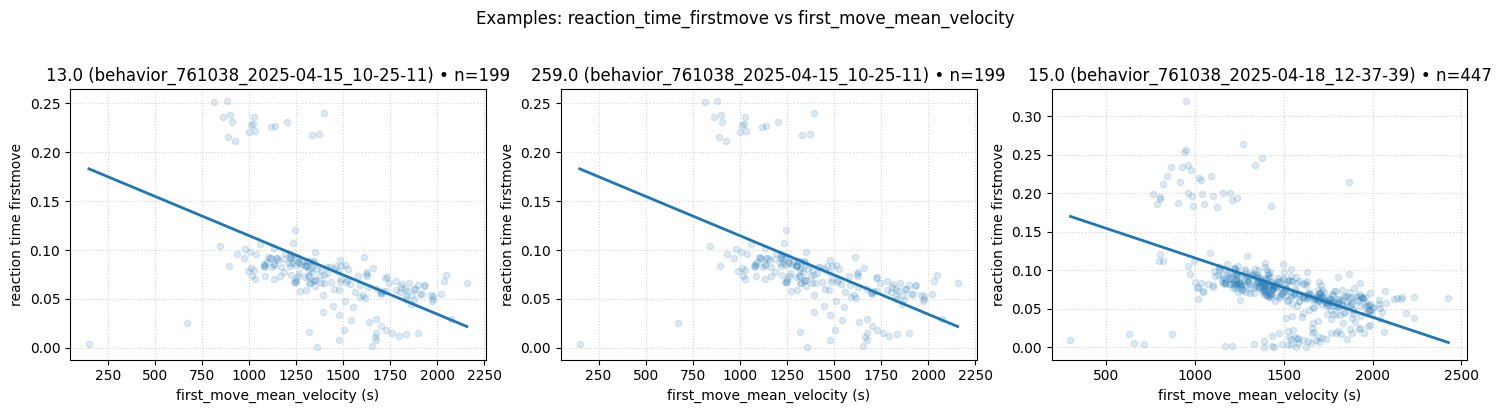

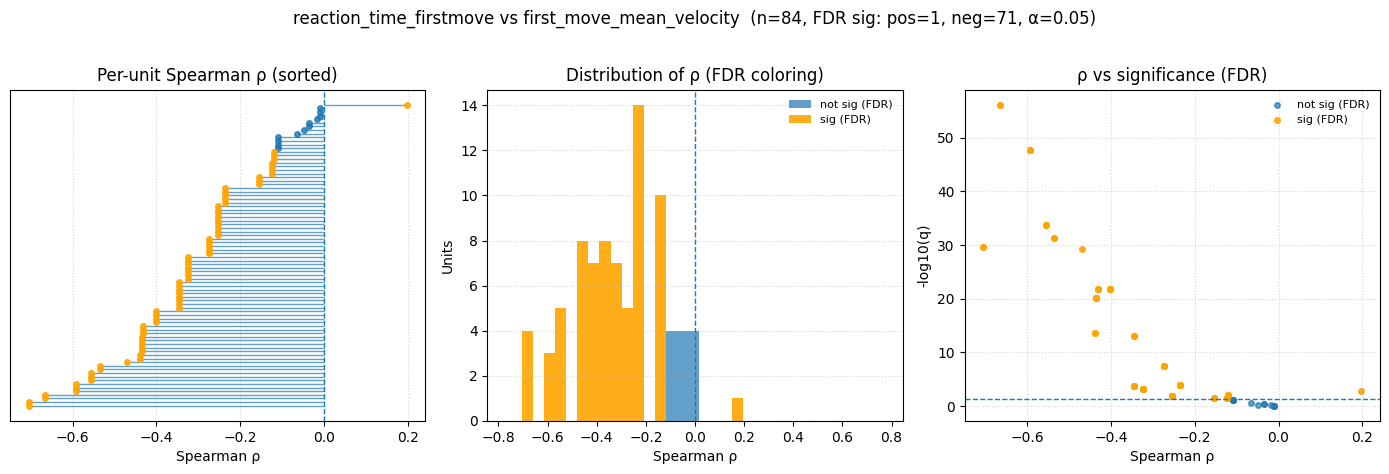

In [57]:
filter_q = "reaction_time_cueresponse < 1.0"  # or include cue_response == True if present
res_rt = run_and_plot_for_predictor(
    all_counts_df,
    x_col="first_move_mean_velocity",
    y_col="reaction_time_firstmove",
    example_n=3,
    alpha=0.05,
)


In [39]:
all_counts_df.columns

Index(['trial', 'unit_id', 'session', 'align_key', 'win_start_s', 'win_stop_s',
       'spike_count', 'spike_rate_hz', 'lat_win_start_s', 'lat_win_stop_s',
       'first_spike_latency_s', 'had_spike_in_latency_win',
       'cue_response_movement_number', 'reaction_time_firstmove',
       'reaction_time_cueresponse', 'first_move_peak_velocity',
       'first_move_mean_velocity', 'first_move_excursion_angle_deg',
       'first_move_endpoint_x', 'first_move_endpoint_y',
       'cue_response_peak_velocity', 'cue_response_mean_velocity',
       'cue_response_excursion_angle_deg', 'cue_response_endpoint_x',
       'cue_response_endpoint_y'],
      dtype='object')

In [58]:
res_rt['cor_df'].sort_values('pearson_q')

unit_id                              session  n_trials  spearman_rho  \
63     12.0  behavior_761038_2025-04-18_12-37-39       447     -0.665438   
64     15.0  behavior_761038_2025-04-18_12-37-39       447     -0.665438   
60     10.0  behavior_761038_2025-04-16_10-39-10       420     -0.555772   
62    213.0  behavior_761038_2025-04-16_10-39-10       420     -0.555772   
61     47.0  behavior_761038_2025-04-16_10-39-10       420     -0.555772   
..      ...                                  ...       ...           ...   
32     23.0  behavior_751769_2025-01-17_11-37-39       275     -0.010293   
34    288.0  behavior_751769_2025-01-17_11-37-39       275     -0.010293   
48     39.0  behavior_758017_2025-02-05_11-42-34       445     -0.035108   
47     37.0  behavior_758017_2025-02-05_11-42-34       445     -0.035108   
49     85.0  behavior_758017_2025-02-06_11-26-14       390     -0.017167   

      spearman_p  pearson_r     pearson_p    spearman_q  spearman_sig_fdr  \
63  1.734757e-58  -0.519271  3.134571e-32  7.285981e-57              True   
64  1.734757e-58  -0.519271  3.134571e-32  7.285981e-57              True   
60  2.043055e-35  -0.503471  2.245841e-28  2.145208e-34              True   
62  2.043055e-35  -0.503471  2.245841e-28  2.145208e-34              True   
61  2.043055e-35  -0.503471  2.245841e-28  2.145208e-34              True   
..           ...        ...           ...           ...               ...   
32  8.650774e-01  -0.017763  7.693271e-01  8.650774e-01             False   
34  8.650774e-01  -0.017763  7.693271e-01  8.650774e-01             False   
48  4.600571e-01  -0.013208  7.811192e-01  4.891747e-01             False   
47  4.600571e-01  -0.013208  7.811192e-01  4.891747e-01             False   
49  7.354001e-01   0.004694  9.263861e-01  7.626371e-01             False   

       pearson_q  pearson_sig_fdr  
63  1.316520e-30             True  
64  1.316520e-30             True  
60  3.773012e-27             True  
62  3.773012e-27             True  
61  3.773012e-27             True  
..           ...              ...  
32  7.905302e-01            False  
34  7.905302e-01            False  
48  7.905302e-01            False  
47  7.905302e-01            False  
49  9.263861e-01            False  

[84 rows x 11 columns]

In [23]:
# Threshold for "slow" first moves
thr = 1.0  # seconds

# Filter valid rows
valid = df.dropna(subset=["reaction_time_firstmove"])

# Boolean mask
slow_mask = valid["reaction_time_firstmove"] > thr

# --- Summary numbers ---
n_total_trials = len(valid)
n_slow_trials  = slow_mask.sum()
frac_slow = n_slow_trials / n_total_trials * 100

n_sessions_total = valid["session"].nunique()
sessions_with_slow = valid.loc[slow_mask, "session"].nunique()

print(f"Total trials: {n_total_trials:,}")
print(f"Trials > {thr:.1f}s: {n_slow_trials:,}  ({frac_slow:.1f}%)")
print(f"Total sessions: {n_sessions_total}")
print(f"Sessions with ≥1 trial > {thr:.1f}s: {sessions_with_slow}")


Total trials: 26,642
Trials > 1.0s: 11  (0.0%)
Total sessions: 26
Sessions with ≥1 trial > 1.0s: 3


In [19]:
# # Choose one:
# # rt_col = "reaction_time_firstmove"
# rt_col = "reaction_time_cueresponse"
# rt_label = {"reaction_time_firstmove": "first-move",
#             "reaction_time_cueresponse": "cue-response"}.get(rt_col, rt_col)

# df = all_counts_df.dropna(subset=[rt_col, "spike_count"])

# # Per-unit correlations + small multiples (no saving)
# import numpy as np, matplotlib.pyplot as plt
# from scipy.stats import spearmanr, pearsonr
# import pandas as pd

# groups = list(df.groupby(["unit_id","session"]))
# ncols, nrows = 4, int(np.ceil(len(groups)/4))
# fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), squeeze=False)

# summ_rows = []
# for ax, ((uid, sess), g) in zip(axes.ravel(), groups):
#     x, y = g[rt_col].to_numpy(), g["spike_count"].to_numpy()
#     if len(g) < 3:
#         ax.axis("off")
#         summ_rows.append({"unit_id": uid, "session": sess, "n_trials": len(g),
#                           "spearman_rho": np.nan, "spearman_p": np.nan,
#                           "pearson_r": np.nan, "pearson_p": np.nan})
#         continue

#     ax.scatter(x, y, s=20, alpha=0.1)
#     ax.grid(True, ls=":", alpha=0.5)
#     ax.set_title(f"{uid} ({sess})", fontsize=9)

#     if np.unique(x).size >= 2:
#         m, b = np.polyfit(x, y, 1)
#         xx = np.linspace(np.nanmin(x), np.nanmax(x), 100)
#         ax.plot(xx, m*xx + b, lw=2)

#     # stats
#     rho, ps = spearmanr(x, y, nan_policy="omit")
#     r, pp   = pearsonr(x, y)
#     summ_rows.append({"unit_id": uid, "session": sess, "n_trials": len(g),
#                       "spearman_rho": float(rho), "spearman_p": float(ps),
#                       "pearson_r": float(r), "pearson_p": float(pp)})

# # turn off any unused axes
# for ax in axes.ravel()[len(groups):]:
#     ax.axis("off")

# # Global labels + title
# fig.supxlabel("Reaction time (s)")
# fig.supylabel("Spike count (100ms window from Go)")
# fig.suptitle(f"Spike–reaction time ({rt_label}) correlation per unit", y=0.95, fontsize=12)

# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()

# cor_df_cue = pd.DataFrame(summ_rows).sort_values(["session","unit_id"])
# print(cor_df_cue.to_string(index=False))


In [20]:
# import numpy as np
# import pandas as pd
# from scipy.stats import wilcoxon, binomtest, norm

# # Start from your cor_df
# df = cor_df_cue.copy()

# # ---------- 1) Wilcoxon signed-rank on Spearman rho (vs 0) ----------
# sdf = df.dropna(subset=["spearman_rho"]).query("n_trials >= 3")
# rho = sdf["spearman_rho"].to_numpy()

# if len(rho) >= 3 and np.any(rho != 0):
#     # alternative="two-sided" -> use "less" if you expect negative correlations a priori
#     W, p_wil = wilcoxon(rho, alternative="two-sided", zero_method="wilcox")
#     print(f"[Spearman ρ] Wilcoxon vs 0: W={W:.1f}, p={p_wil:.3g}, "
#           f"median={np.nanmedian(rho):.3f}, n_units={len(rho)}")
# else:
#     print("[Spearman ρ] Not enough nonzero data for Wilcoxon.")

# # ---------- 2) Sign test: negatives vs positives ----------
# neg = np.sum(rho < 0)
# pos = np.sum(rho > 0)
# n_nonzero = neg + pos
# if n_nonzero > 0:
#     # two-sided; use 'greater' on neg/(neg+pos) if you expect more negatives
#     p_sign = binomtest(neg, n_nonzero, 0.5, alternative="two-sided").pvalue
#     print(f"[Spearman ρ] Sign test: negatives={neg}, positives={pos}, "
#           f"p={p_sign:.3g}, n_units={n_nonzero}")
# else:
#     print("[Spearman ρ] No nonzero correlations to run sign test.")

# # ---------- 3) Fisher-z meta-analysis on Pearson r ----------
# # (weights account for different trial counts per unit)
# pdf = df.dropna(subset=["pearson_r"]).query("n_trials >= 4")  # need >3 to define weight
# if not pdf.empty:
#     r = np.clip(pdf["pearson_r"].to_numpy(), -0.999999, 0.999999)
#     w = np.maximum(pdf["n_trials"].to_numpy() - 3, 1e-6)      # fixed-effect weights
#     z = np.arctanh(r)
#     z_bar = np.sum(w * z) / np.sum(w)
#     se = 1.0 / np.sqrt(np.sum(w))
#     z_stat = z_bar / se
#     p_meta = 2 * (1 - norm.cdf(abs(z_stat)))  # two-sided; use 1-sided if you have a direction
#     r_meta = np.tanh(z_bar)
#     r_lo = np.tanh(z_bar - 1.96 * se)
#     r_hi = np.tanh(z_bar + 1.96 * se)
#     print(f"[Pearson r] Fisher-z meta: r_meta={r_meta:.3f} "
#           f"(95% CI {r_lo:.3f}..{r_hi:.3f}), z={z_stat:.2f}, p={p_meta:.3g}, n_units={len(pdf)}")
# else:
#     print("[Pearson r] Not enough data for Fisher-z meta-analysis.")


In [ ]:
# Choose one:
rt_col = "reaction_time_firstmove"
# rt_col = "reaction_time_cueresponse"
rt_label = {"reaction_time_firstmove": "first-move",
            "reaction_time_cueresponse": "cue-response"}.get(rt_col, rt_col)

df = all_counts_df.dropna(subset=[rt_col, "spike_count"])

# Per-unit correlations + small multiples (no saving)
import numpy as np, matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
import pandas as pd

groups = list(df.groupby(["unit_id","session"]))
ncols, nrows = 4, int(np.ceil(len(groups)/4))
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), squeeze=False)

summ_rows = []
for ax, ((uid, sess), g) in zip(axes.ravel(), groups):
    x, y = g[rt_col].to_numpy(), g["spike_count"].to_numpy()
    if len(g) < 3:
        ax.axis("off")
        summ_rows.append({"unit_id": uid, "session": sess, "n_trials": len(g),
                          "spearman_rho": np.nan, "spearman_p": np.nan,
                          "pearson_r": np.nan, "pearson_p": np.nan})
        continue

    ax.scatter(x, y, s=20, alpha=0.1)
    ax.grid(True, ls=":", alpha=0.5)
    ax.set_title(f"{uid} ({sess})", fontsize=9)

    if np.unique(x).size >= 2:
        m, b = np.polyfit(x, y, 1)
        xx = np.linspace(np.nanmin(x), np.nanmax(x), 100)
        ax.plot(xx, m*xx + b, lw=2)

    # stats
    rho, ps = spearmanr(x, y, nan_policy="omit")
    r, pp   = pearsonr(x, y)
    summ_rows.append({"unit_id": uid, "session": sess, "n_trials": len(g),
                      "spearman_rho": float(rho), "spearman_p": float(ps),
                      "pearson_r": float(r), "pearson_p": float(pp)})

# turn off any unused axes
for ax in axes.ravel()[len(groups):]:
    ax.axis("off")

# Global labels + title
fig.supxlabel("Reaction time (s)")
fig.supylabel("Spike count (100ms window from Go)")
fig.suptitle(f"Spike–reaction time ({rt_label}) correlation per unit", y=0.95, fontsize=12)

# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()

# if SAVE_FIG:
#     fname = FIG_DIR / "spike_count_RTcorr_firstmove"
#     FIG_DIR.mkdir(parents=True, exist_ok=True)
#     fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
#     fig.savefig(f"{fname}.svg", bbox_inches="tight")

cor_df_move = pd.DataFrame(summ_rows).sort_values(["session","unit_id"])
print(cor_df_move.to_string(index=False))


In [76]:
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon, binomtest, norm

# Start from your cor_df
df = cor_df_move.copy()

# ---------- 1) Wilcoxon signed-rank on Spearman rho (vs 0) ----------
sdf = df.dropna(subset=["spearman_rho"]).query("n_trials >= 3")
rho = sdf["spearman_rho"].to_numpy()

if len(rho) >= 3 and np.any(rho != 0):
    # alternative="two-sided" -> use "less" if you expect negative correlations a priori
    W, p_wil = wilcoxon(rho, alternative="two-sided", zero_method="wilcox")
    print(f"[Spearman ρ] Wilcoxon vs 0: W={W:.1f}, p={p_wil:.3g}, "
          f"median={np.nanmedian(rho):.3f}, n_units={len(rho)}")
else:
    print("[Spearman ρ] Not enough nonzero data for Wilcoxon.")

# ---------- 2) Sign test: negatives vs positives ----------
neg = np.sum(rho < 0)
pos = np.sum(rho > 0)
n_nonzero = neg + pos
if n_nonzero > 0:
    # two-sided; use 'greater' on neg/(neg+pos) if you expect more negatives
    p_sign = binomtest(neg, n_nonzero, 0.5, alternative="two-sided").pvalue
    print(f"[Spearman ρ] Sign test: negatives={neg}, positives={pos}, "
          f"p={p_sign:.3g}, n_units={n_nonzero}")
else:
    print("[Spearman ρ] No nonzero correlations to run sign test.")

# ---------- 3) Fisher-z meta-analysis on Pearson r ----------
# (weights account for different trial counts per unit)
pdf = df.dropna(subset=["pearson_r"]).query("n_trials >= 4")  # need >3 to define weight
if not pdf.empty:
    r = np.clip(pdf["pearson_r"].to_numpy(), -0.999999, 0.999999)
    w = np.maximum(pdf["n_trials"].to_numpy() - 3, 1e-6)      # fixed-effect weights
    z = np.arctanh(r)
    z_bar = np.sum(w * z) / np.sum(w)
    se = 1.0 / np.sqrt(np.sum(w))
    z_stat = z_bar / se
    p_meta = 2 * (1 - norm.cdf(abs(z_stat)))  # two-sided; use 1-sided if you have a direction
    r_meta = np.tanh(z_bar)
    r_lo = np.tanh(z_bar - 1.96 * se)
    r_hi = np.tanh(z_bar + 1.96 * se)
    print(f"[Pearson r] Fisher-z meta: r_meta={r_meta:.3f} "
          f"(95% CI {r_lo:.3f}..{r_hi:.3f}), z={z_stat:.2f}, p={p_meta:.3g}, n_units={len(pdf)}")
else:
    print("[Pearson r] Not enough data for Fisher-z meta-analysis.")


[Spearman ρ] Wilcoxon vs 0: W=1594.0, p=0.0947, median=-0.011, n_units=89
[Spearman ρ] Sign test: negatives=52, positives=37, p=0.137, n_units=89
[Pearson r] Fisher-z meta: r_meta=-0.027 (95% CI -0.039..-0.016), z=-4.54, p=5.74e-06, n_units=89


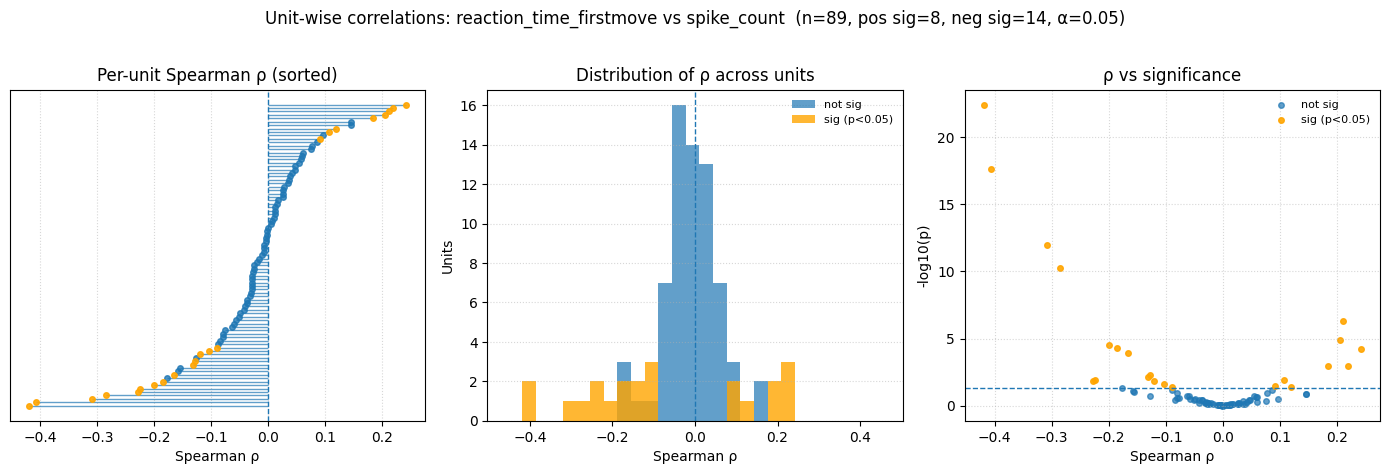

In [77]:
# ...existing code...
import numpy as np
import matplotlib.pyplot as plt

ALPHA = 0.05
rt_col = "reaction_time_firstmove"
title_rt = rt_col  # use whichever you set above, e.g., "reaction_time_firstmove" or "reaction_time_cueresponse"

# Keep only rows with valid rho & p
valid = cor_df_move.dropna(subset=["spearman_rho", "spearman_p"]).copy()
if valid.empty:
    raise ValueError("No valid correlations in cor_df (all NaN).")

# Basic counts
n_units = len(valid)
sig_mask = valid["spearman_p"] < ALPHA
pos_sig = int(((valid["spearman_rho"] > 0) & sig_mask).sum())
neg_sig = int(((valid["spearman_rho"] < 0) & sig_mask).sum())

# Sort by rho for the lollipop plot
valid_sorted = valid.sort_values("spearman_rho").reset_index(drop=True)
ypos = np.arange(len(valid_sorted))

# Volcano y = -log10(p)
finite_p = valid["spearman_p"] > 0
y_volcano = -np.log10(valid.loc[finite_p, "spearman_p"].to_numpy())
x_volcano = valid.loc[finite_p, "spearman_rho"].to_numpy()
pthr_y = -np.log10(ALPHA)

# ---- Figure ----
fig, axes = plt.subplots(1, 3, figsize=(14, 4.6))

# (1) Lollipop plot of Spearman rho per unit
ax = axes[0]
rho_vals = valid_sorted["spearman_rho"].to_numpy()
is_sig_sorted = valid_sorted["spearman_p"].to_numpy() < ALPHA

for i, (rho, sig) in enumerate(zip(rho_vals, is_sig_sorted)):
    ax.hlines(i, 0, rho, linewidth=1.0, alpha=0.7)
# overlay markers: non-sig then sig (so sig sits on top)
ax.plot(rho_vals[~is_sig_sorted], ypos[~is_sig_sorted], "o", ms=4, alpha=0.8)
ax.plot(rho_vals[is_sig_sorted],  ypos[is_sig_sorted],  "o", ms=4, alpha=0.9, color="orange")
ax.axvline(0, linestyle="--", linewidth=1)
ax.set_yticks([])
ax.set_xlabel("Spearman ρ")
ax.set_title("Per-unit Spearman ρ (sorted)")
ax.grid(True, axis="x", linestyle=":", alpha=0.5)

# (2) Histogram of rho, color significant bars orange
ax = axes[1]
bins = np.histogram_bin_edges(valid["spearman_rho"].to_numpy(), bins=20)
hist, edges = np.histogram(valid["spearman_rho"], bins=bins)
hist_sig, _ = np.histogram(valid.loc[sig_mask, "spearman_rho"], bins=bins)
widths = np.diff(edges)
# Plot non-significant bars
ax.bar(edges[:-1], hist - hist_sig, width=widths, align="edge", alpha=0.7, color="C0", label="not sig")
# Overlay significant bars in orange
ax.bar(edges[:-1], hist_sig, width=widths, align="edge", alpha=0.8, color="orange", label="sig (p<0.05)")
ax.axvline(0, linestyle="--", linewidth=1)
rho_max = np.max(np.abs(valid["spearman_rho"].to_numpy()))
ax.set_xlim(-rho_max*1.2, rho_max*1.2)
ax.set_xlabel("Spearman ρ")
ax.set_ylabel("Units")
ax.set_title("Distribution of ρ across units")
ax.grid(True, axis="y", linestyle=":", alpha=0.5)
ax.legend(frameon=False, fontsize=8)

# (3) Volcano-style: rho vs -log10(p), color significant points orange
ax = axes[2]
sig_volcano = valid.loc[finite_p, "spearman_p"] < ALPHA
ax.scatter(x_volcano[~sig_volcano], y_volcano[~sig_volcano], s=16, alpha=0.7, label="not sig")
ax.scatter(x_volcano[sig_volcano],  y_volcano[sig_volcano],  s=16, alpha=0.9, color="orange", label="sig (p<0.05)")
ax.axhline(pthr_y, linestyle="--", linewidth=1)
ax.set_xlabel("Spearman ρ")
ax.set_ylabel("-log10(p)")
ax.set_title("ρ vs significance")
ax.grid(True, linestyle=":", alpha=0.5)
ax.legend(frameon=False, fontsize=8)

# Suptitle + annotation
fig.suptitle(f"Unit-wise correlations: {title_rt} vs spike_count  "
             f"(n={n_units}, pos sig={pos_sig}, neg sig={neg_sig}, α={ALPHA})", y=1.02)
plt.tight_layout()
plt.show()

if SAVE_FIG:
    fname = FIG_DIR / "spike_count_RTcorr_summary"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"{fname}.svg", bbox_inches="tight")


In [ ]:
import numpy as np, matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
import pandas as pd

# ==== Correlate first-spike latency with reaction time (per unit) ====
# Choose one:
rt_col = "reaction_time_firstmove"
# rt_col = "reaction_time_cueresponse"
rt_label = {"reaction_time_firstmove": "first-move",
            "reaction_time_cueresponse": "cue-response"}.get(rt_col, rt_col)

# Expect all_counts_df to now include 'first_spike_latency_s' from the updated analyze_unit_for_session
df = all_counts_df.dropna(subset=[rt_col, "first_spike_latency_s"]).copy()

groups = list(df.groupby(["unit_id","session"], sort=False))
if not groups:
    raise ValueError("No groups found for correlation (check data join and NaNs).")

ncols = 4
nrows = int(np.ceil(len(groups) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), squeeze=False)

summ_rows = []
for ax, ((uid, sess), g) in zip(axes.ravel(), groups):
    x = g[rt_col].to_numpy()
    y = g["first_spike_latency_s"].to_numpy()

    if len(g) < 3 or np.unique(x).size < 2 or np.unique(y).size < 2:
        ax.axis("off")
        summ_rows.append({"unit_id": uid, "session": sess, "n_trials": int(len(g)),
                          "spearman_rho": np.nan, "spearman_p": np.nan,
                          "pearson_r": np.nan, "pearson_p": np.nan})
        continue

    ax.scatter(x, y, s=20, alpha=0.2)
    ax.grid(True, ls=":", alpha=0.5)
    ax.set_title(f"{uid} ({sess})", fontsize=9)

    # simple OLS line for visualization
    m, b = np.polyfit(x, y, 1)
    xx = np.linspace(np.nanmin(x), np.nanmax(x), 100)
    ax.plot(xx, m*xx + b, lw=2)

    # stats
    rho, ps = spearmanr(x, y, nan_policy="omit")
    r, pp   = pearsonr(x, y)
    summ_rows.append({"unit_id": uid, "session": sess, "n_trials": int(len(g)),
                      "spearman_rho": float(rho), "spearman_p": float(ps),
                      "pearson_r": float(r), "pearson_p": float(pp)})

# turn off any unused axes
for ax in axes.ravel()[len(groups):]:
    ax.axis("off")

# Global labels + title
fig.supxlabel("Reaction time (s)")
fig.supylabel("First-spike latency (s)")
fig.suptitle(f"First-spike latency vs RT ({rt_label}) — per unit", y=0.95, fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

cor_df_latency = pd.DataFrame(summ_rows).sort_values(["session","unit_id"])
print(cor_df_latency.to_string(index=False))


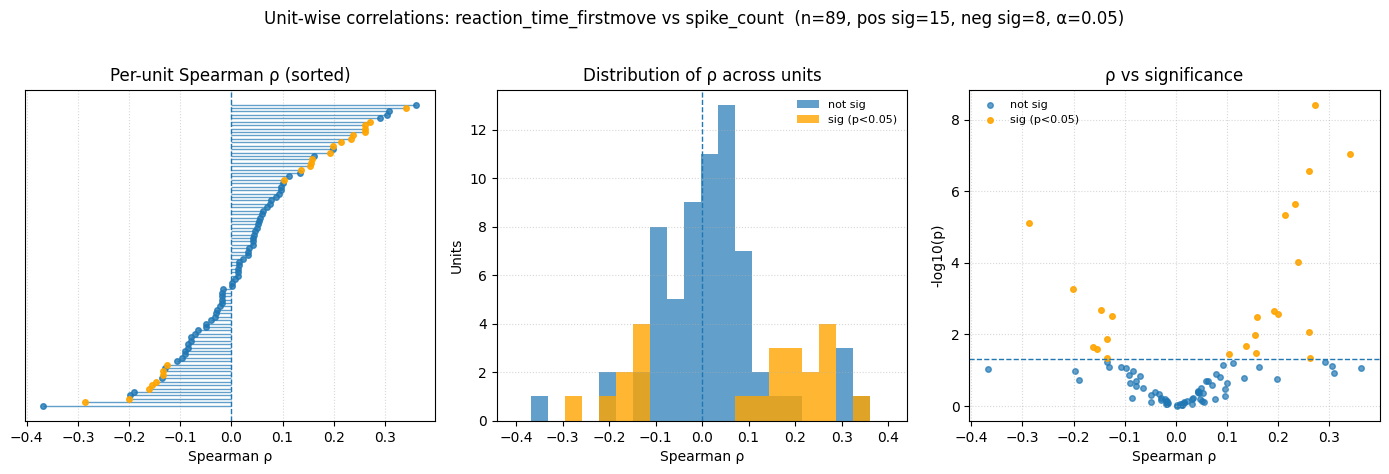

In [82]:
# ==== Summary figure over units ====
import numpy as np
import matplotlib.pyplot as plt

ALPHA = 0.05
title_rt = "reaction_time_firstmove" 

valid = cor_df_latency.dropna(subset=["spearman_rho", "spearman_p"]).copy()
if valid.empty:
    raise ValueError("No valid correlations in cor_df_latency (all NaN).")

n_units = len(valid)
sig_mask = valid["spearman_p"] < ALPHA
pos_sig = int(((valid["spearman_rho"] > 0) & sig_mask).sum())
neg_sig = int(((valid["spearman_rho"] < 0) & sig_mask).sum())

# Sort by rho for lollipop
valid_sorted = valid.sort_values("spearman_rho").reset_index(drop=True)
ypos = np.arange(len(valid_sorted))

# Volcano data
finite_p = valid["spearman_p"] > 0
y_volcano = -np.log10(valid.loc[finite_p, "spearman_p"].to_numpy())
x_volcano = valid.loc[finite_p, "spearman_rho"].to_numpy()
pthr_y = -np.log10(ALPHA)

fig, axes = plt.subplots(1, 3, figsize=(14, 4.6))

# (1) Lollipop plot of Spearman rho per unit
ax = axes[0]
rho_vals = valid_sorted["spearman_rho"].to_numpy()
is_sig_sorted = valid_sorted["spearman_p"].to_numpy() < ALPHA

for i, (rho, sig) in enumerate(zip(rho_vals, is_sig_sorted)):
    ax.hlines(i, 0, rho, linewidth=1.0, alpha=0.7)
# overlay markers: non-sig then sig (so sig sits on top)
ax.plot(rho_vals[~is_sig_sorted], ypos[~is_sig_sorted], "o", ms=4, alpha=0.8)
ax.plot(rho_vals[is_sig_sorted],  ypos[is_sig_sorted],  "o", ms=4, alpha=0.9, color="orange")
ax.axvline(0, linestyle="--", linewidth=1)
ax.set_yticks([])
ax.set_xlabel("Spearman ρ")
ax.set_title("Per-unit Spearman ρ (sorted)")
ax.grid(True, axis="x", linestyle=":", alpha=0.5)

# (2) Histogram of rho, color significant bars orange
ax = axes[1]
bins = np.histogram_bin_edges(valid["spearman_rho"].to_numpy(), bins=20)
hist, edges = np.histogram(valid["spearman_rho"], bins=bins)
hist_sig, _ = np.histogram(valid.loc[sig_mask, "spearman_rho"], bins=bins)
widths = np.diff(edges)
# Plot non-significant bars
ax.bar(edges[:-1], hist - hist_sig, width=widths, align="edge", alpha=0.7, color="C0", label="not sig")
# Overlay significant bars in orange
ax.bar(edges[:-1], hist_sig, width=widths, align="edge", alpha=0.8, color="orange", label="sig (p<0.05)")
ax.axvline(0, linestyle="--", linewidth=1)
rho_max = np.max(np.abs(valid["spearman_rho"].to_numpy()))
ax.set_xlim(-rho_max*1.2, rho_max*1.2)
ax.set_xlabel("Spearman ρ")
ax.set_ylabel("Units")
ax.set_title("Distribution of ρ across units")
ax.grid(True, axis="y", linestyle=":", alpha=0.5)
ax.legend(frameon=False, fontsize=8)

# (3) Volcano-style: rho vs -log10(p), color significant points orange
ax = axes[2]
sig_volcano = valid.loc[finite_p, "spearman_p"] < ALPHA
ax.scatter(x_volcano[~sig_volcano], y_volcano[~sig_volcano], s=16, alpha=0.7, label="not sig")
ax.scatter(x_volcano[sig_volcano],  y_volcano[sig_volcano],  s=16, alpha=0.9, color="orange", label="sig (p<0.05)")
ax.axhline(pthr_y, linestyle="--", linewidth=1)
ax.set_xlabel("Spearman ρ")
ax.set_ylabel("-log10(p)")
ax.set_title("ρ vs significance")
ax.grid(True, linestyle=":", alpha=0.5)
ax.legend(frameon=False, fontsize=8)

# Suptitle + annotation
fig.suptitle(f"Unit-wise correlations: {title_rt} vs spike_count  "
             f"(n={n_units}, pos sig={pos_sig}, neg sig={neg_sig}, α={ALPHA})", y=1.02)
plt.tight_layout()
plt.show()

if SAVE_FIG:
    fname = FIG_DIR / "spike_count_RTcorr_summary"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"{fname}.svg", bbox_inches="tight")

In [83]:
# figure comparing cue-response lick reaction time to tongue movement reaction time

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.stats import spearmanr, wilcoxon

# # -----------------------------
# # Settings (match your build of all_counts_df)
# # -----------------------------
# ALIGN_KEY   = "goCue"
# COUNT_WIN   = cfg.count_window_s
# MIN_TRIALS_PER_UNIT = 3
# ONLY_CR_TRIALS = False   # set True to keep only trials with cue_response_movement_number notna()
# ALPHA = 0.05

# # -----------------------------
# # Prep data
# # -----------------------------
# df = all_counts_df.copy()
# mask = (
#     (df["align_key"] == ALIGN_KEY) &
#     (np.isclose(df["win_start_s"], COUNT_WIN[0])) &
#     (np.isclose(df["win_stop_s"], COUNT_WIN[1]))
# )
# df = df.loc[mask].copy()
# if ONLY_CR_TRIALS:
#     df = df.loc[df["cue_response_movement_number"].notna()].copy()

# # -----------------------------
# # Helper: per-unit Spearman for a given RT col
# # -----------------------------
# def per_unit_spearman(df_in: pd.DataFrame, rt_col: str) -> pd.DataFrame:
#     rows = []
#     for (uid, sess), g in df_in.dropna(subset=[rt_col, "spike_count"]).groupby(["unit_id","session"]):
#         if len(g) < MIN_TRIALS_PER_UNIT:
#             rows.append({"unit_id": uid, "session": sess, "n_trials": len(g), "rho": np.nan, "p": np.nan})
#             continue
#         rho, p = spearmanr(g[rt_col].to_numpy(), g["spike_count"].to_numpy(), nan_policy="omit")
#         rows.append({"unit_id": uid, "session": sess, "n_trials": len(g), "rho": float(rho), "p": float(p)})
#     return pd.DataFrame(rows)

# # Compute correlations for both RT definitions
# cor_first = per_unit_spearman(df, "reaction_time_firstmove").rename(columns={"rho":"rho_first","p":"p_first"})
# cor_cr    = per_unit_spearman(df, "reaction_time_cueresponse").rename(columns={"rho":"rho_cr","p":"p_cr"})

# # Keep only paired units (have both)
# m = (cor_first.merge(cor_cr, on=["unit_id","session","n_trials"], how="inner")
#               .dropna(subset=["rho_first","rho_cr"])
#               .reset_index(drop=True))
# if m.empty:
#     raise ValueError("No units with valid correlations for both RT definitions.")

# # Significance categories
# sig_first = m["p_first"] < ALPHA
# sig_cr    = m["p_cr"]    < ALPHA
# m["sig_cat"] = np.select(
#     [ sig_first &  sig_cr,  sig_first & ~sig_cr, ~sig_first &  sig_cr],
#     [ "both sig",           "first-only sig",    "cue-only sig"        ],
#     default="not sig"
# )

# # For panel 2
# m["is_sig_first"] = sig_first
# m["is_sig_cr"]    = sig_cr

# # Common limits for rho axes
# vals = np.concatenate([m["rho_first"].to_numpy(), m["rho_cr"].to_numpy()])
# rho_min, rho_max = (np.nanmin(vals), np.nanmax(vals)) if np.isfinite(vals).all() else (-1.0, 1.0)
# pad = 0.05 * (rho_max - rho_min if rho_max > rho_min else 1.0)
# rho_lo, rho_hi = rho_min - pad, rho_max + pad
# bins = np.linspace(min(rho_lo, -1), max(rho_hi, 1), 21)

# # Colors
# color_cat = {
#     "both sig": "C3",          # orange/red
#     "first-only sig": "C1",    # amber
#     "cue-only sig": "C2",      # green
#     "not sig": "C0",           # blue
# }
# color_rt = {"first": "C0", "cue": "C3"}  # panel 3 identity colors
# color_sig = {"sig": "C3", "nonsig": "C0"}  # panel 2 significance colors

# # -----------------------------
# # Figure layout with nested grids
# # -----------------------------
# fig = plt.figure(figsize=(15, 5.2))
# gs = fig.add_gridspec(nrows=2, ncols=3, width_ratios=[1.25, 1.25, 1.5], wspace=0.35, hspace=0.35)

# # Panel 1: scatter with flipped axes + significance categories
# ax1 = fig.add_subplot(gs[:, 0])
# for k, g in m.groupby("sig_cat"):
#     ax1.scatter(g["rho_first"], g["rho_cr"], s=30, alpha=0.9,
#                 edgecolor="black", linewidth=0.4, c=color_cat[k], label=f"{k} (n={len(g)})")
# ax1.plot([rho_lo, rho_hi], [rho_lo, rho_hi], linestyle="--", linewidth=1, color="gray")

# # flip both axes so "more negative" is visually "more" (upper-right)
# ax1.set_xlim(rho_hi, rho_lo)
# ax1.set_ylim(rho_hi, rho_lo)

# ax1.set_xlabel("Spearman ρ (first-move RT)")
# ax1.set_ylabel("Spearman ρ (cue-response RT)")
# ax1.set_title("RT - spike count correlation:\nfirst-move vs cue-response")
# ax1.grid(True, linestyle=":", alpha=0.5)
# ax1.legend(frameon=False, fontsize=8, loc="best")

# # Panel 2: two stacked histograms (first-move on top, cue-response bottom), colored by significance
# ax2a = fig.add_subplot(gs[0, 1])  # first-move
# rho_first_sig    = m.loc[m["is_sig_first"], "rho_first"].to_numpy()
# rho_first_nonsig = m.loc[~m["is_sig_first"], "rho_first"].to_numpy()
# ax2a.hist(rho_first_nonsig, bins=bins, alpha=0.7, label="not sig", color=color_sig["nonsig"])
# ax2a.hist(rho_first_sig,    bins=bins, alpha=0.7, label="sig",     color=color_sig["sig"])
# ax2a.axvline(0, linestyle="--", linewidth=1, color="gray")
# ax2a.set_xlim(bins[0], bins[-1])
# ax2a.set_title("First-move RT: ρ distribution")
# ax2a.set_ylabel("Unit count")
# ax2a.grid(True, axis="y", linestyle=":", alpha=0.5)
# ax2a.legend(frameon=False, fontsize=8)

# ax2b = fig.add_subplot(gs[1, 1])  # cue-response
# rho_cr_sig    = m.loc[m["is_sig_cr"], "rho_cr"].to_numpy()
# rho_cr_nonsig = m.loc[~m["is_sig_cr"], "rho_cr"].to_numpy()
# ax2b.hist(rho_cr_nonsig, bins=bins, alpha=0.7, label="not sig", color=color_sig["nonsig"])
# ax2b.hist(rho_cr_sig,    bins=bins, alpha=0.7, label="sig",     color=color_sig["sig"])
# ax2b.axvline(0, linestyle="--", linewidth=1, color="gray")
# ax2b.set_xlim(bins[0], bins[-1])
# ax2b.set_title("Cue-response RT: ρ distribution")
# ax2b.set_xlabel("Spearman ρ")
# ax2b.set_ylabel("Unit count")
# ax2b.grid(True, axis="y", linestyle=":", alpha=0.5)
# ax2b.legend(frameon=False, fontsize=8)

# # Panel 3: lollipop per unit (two RTs per unit), sorted by cue-response ρ
# # Panel 3: lollipop per unit with significance highlighting
# ax3 = fig.add_subplot(gs[:, 2])

# # sort by cue-response rho so more negative at top (we'll keep normal y order)
# order = np.argsort(m["rho_first"].to_numpy())
# m_sorted = m.iloc[order].reset_index(drop=True)
# y = np.arange(len(m_sorted))

# offset = 0.18
# for i, row in m_sorted.iterrows():
#     # faint band if any significance for this unit
#     if bool(row["is_sig_first"]) or bool(row["is_sig_cr"]):
#         ax3.axhspan(i-0.42, i+0.42, color="k", alpha=0.05, zorder=0)

#     # ---- first-move RT ----
#     rf   = row["rho_first"]
#     sig1 = bool(row["is_sig_first"])
#     lw1  = 2.2 if sig1 else 1.0
#     mfc1 = color_rt["first"] if sig1 else "none"  # filled if sig, open if not
#     ax3.hlines(y=i - offset, xmin=0, xmax=rf, color=color_rt["first"], alpha=0.9, linewidth=lw1)
#     ax3.plot(rf, i - offset, marker="o", markersize=5, mfc=mfc1, mec="black", mew=0.4,
#              color=color_rt["first"])

#     # ---- cue-response RT ----
#     rc   = row["rho_cr"]
#     sig2 = bool(row["is_sig_cr"])
#     lw2  = 2.2 if sig2 else 1.0
#     mfc2 = color_rt["cue"] if sig2 else "none"
#     ax3.hlines(y=i + offset, xmin=0, xmax=rc, color=color_rt["cue"], alpha=0.9, linewidth=lw2)
#     ax3.plot(rc, i + offset, marker="o", markersize=5, mfc=mfc2, mec="black", mew=0.4,
#              color=color_rt["cue"])

# ax3.axvline(0, linestyle="--", linewidth=1, color="gray")
# ax3.set_xlim(bins[0], bins[-1])
# ax3.set_ylim(-1, len(y))
# ax3.set_yticks([])
# ax3.set_xlabel("Spearman ρ")
# ax3.set_title("RT - spike count correlation per unit")
# ax3.grid(True, axis="x", linestyle=":", alpha=0.5)

# # Legends: RT identity + significance style
# from matplotlib.lines import Line2D
# leg_rt = [
#     Line2D([0], [0], color=color_rt["first"], lw=3, label="first-move RT"),
#     Line2D([0], [0], color=color_rt["cue"],   lw=3, label="cue-response RT"),
# ]
# leg_sig = [
#     Line2D([0], [0], marker="o", linestyle="None", mfc="k", mec="black", mew=0.4,
#            label=f"significant (p < {ALPHA})"),
#     Line2D([0], [0], marker="o", linestyle="None", mfc="none", mec="black", mew=0.4,
#            label="not significant"),
# ]
# first_legend = ax3.legend(handles=leg_rt, frameon=False, loc="lower right", fontsize=8)
# ax3.add_artist(first_legend)
# ax3.legend(handles=leg_sig, frameon=False, loc="upper right", fontsize=8)


# plt.tight_layout()
# plt.show()

# if SAVE_FIG:
#     fname = FIG_DIR / "RT_spikecount_correlation_comparison_firstmove_vs_cueresponse"
#     FIG_DIR.mkdir(parents=True, exist_ok=True)
#     fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
#     fig.savefig(f"{fname}.svg", bbox_inches="tight")

# # Optional quick paired test on rho_cr vs rho_first
# valid = m_sorted.dropna(subset=["rho_first","rho_cr"])
# if len(valid) >= 3:
#     W, pW = wilcoxon(valid["rho_cr"].to_numpy(), valid["rho_first"].to_numpy(), zero_method="wilcox")
#     print(f"Wilcoxon on ρ (cue vs first): W={W:.1f}, p={pW:.3g}, mean Δρ={(valid['rho_cr']-valid['rho_first']).mean():.3f}")


[Across units] Spearman(ρ_count, ρ_latency) = -0.480 (p=1.94e-06)
[Across units] Pearson (ρ_count, ρ_latency) = -0.462 (p=5.19e-06)


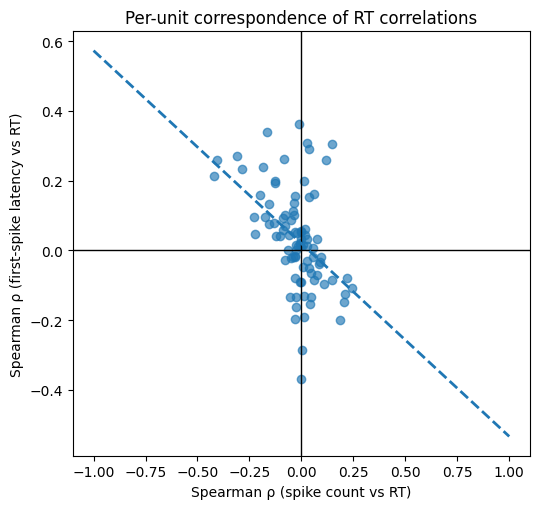


--- Significance summary ---
Units (merged): 89
Significant in RATE:   22
Significant in LATENCY:23
Both significant:      12  

Contingency table (rate_sig x lat_sig):
 p_latency  False  True 
p_count                
False         56     11
True          10     12
Fisher exact: odds=6.11, p=0.00128

Category counts:
 sig_category
none         56
both         12
lat_only     11
rate_only    10
Name: count, dtype: int64


In [84]:
# ==== Compare "rate vs RT" and "first-spike latency vs RT" at the unit level ====
# Requires:
#   cor_df_count   with columns: ['unit_id','session','spearman_rho','spearman_p']
#   cor_df_latency with columns: ['unit_id','session','spearman_rho','spearman_p']

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr, fisher_exact

# ------------------ CONFIG ------------------
ALPHA = 0.05
SIGN_MATCH_REQUIRED = False  # set True to require consistent correlation sign when counting "overlap"
TITLE_SUFFIX = ""            # e.g., " (cue-response RT)" or " (first-move RT)"
SAVE_FIG = False
FIG_DIR = None  # e.g., Path("./figs")
# --------------------------------------------

# 0) Basic checks and rename columns for clarity
required_cols = {"unit_id", "session", "spearman_rho", "spearman_p"}
cor_df_count = cor_df_move.copy()
for name, df in [("cor_df_count", cor_df_count), ("cor_df_latency", cor_df_latency)]:
    missing = required_cols - set(df.columns)
    if missing:
        raise ValueError(f"{name} is missing columns: {missing}")

count_df = cor_df_count.rename(columns={"spearman_rho": "rho_count", "spearman_p": "p_count"}).copy()
lat_df   = cor_df_latency.rename(columns={"spearman_rho": "rho_latency", "spearman_p": "p_latency"}).copy()

# 1) Merge on unit/session
merged = pd.merge(count_df[["unit_id","session","rho_count","p_count"]],
                  lat_df[["unit_id","session","rho_latency","p_latency"]],
                  on=["unit_id","session"], how="inner")

if merged.empty:
    raise ValueError("No overlapping units between cor_df_count and cor_df_latency.")

# 2) Global correlation between the two ρ sets
mask_valid = merged[["rho_count","rho_latency"]].notna().all(axis=1)
rho_spearman, p_spearman = spearmanr(merged.loc[mask_valid, "rho_count"],
                                     merged.loc[mask_valid, "rho_latency"],
                                     nan_policy="omit")
rho_pearson, p_pearson = pearsonr(merged.loc[mask_valid, "rho_count"],
                                  merged.loc[mask_valid, "rho_latency"])

print(f"[Across units] Spearman(ρ_count, ρ_latency) = {rho_spearman:.3f} (p={p_spearman:.3g})")
print(f"[Across units] Pearson (ρ_count, ρ_latency) = {rho_pearson:.3f} (p={p_pearson:.3g})")

# 3) Scatter plot: ρ_count vs ρ_latency
plt.figure(figsize=(5.5, 5.2))
plt.scatter(merged["rho_count"], merged["rho_latency"], alpha=0.65)
plt.axhline(0, lw=1, color="k")
plt.axvline(0, lw=1, color="k")
plt.xlabel("Spearman ρ (spike count vs RT)")
plt.ylabel("Spearman ρ (first-spike latency vs RT)")
plt.title(f"Per-unit correspondence of RT correlations{TITLE_SUFFIX}")

# best-fit line (only if enough finite points)
xy_ok = np.isfinite(merged["rho_count"]) & np.isfinite(merged["rho_latency"])
if xy_ok.sum() >= 2:
    m, b = np.polyfit(merged.loc[xy_ok, "rho_count"], merged.loc[xy_ok, "rho_latency"], 1)
    xx = np.linspace(-1, 1, 200)
    plt.plot(xx, m*xx + b, linestyle="--", lw=2)
plt.tight_layout()
plt.show()

# 4) Overlap of significant units
sig_rate = (merged["p_count"] < ALPHA)
sig_lat  = (merged["p_latency"] < ALPHA)

if SIGN_MATCH_REQUIRED:
    # Only count as overlap if the sign of rho matches (both >0 or both <0)
    sign_match = np.sign(merged["rho_count"]) == np.sign(merged["rho_latency"])
    both_sig = sig_rate & sig_lat & sign_match
else:
    both_sig = sig_rate & sig_lat

either_sig = sig_rate | sig_lat

print("\n--- Significance summary ---")
print(f"Units (merged): {len(merged)}")
print(f"Significant in RATE:   {int(sig_rate.sum())}")
print(f"Significant in LATENCY:{int(sig_lat.sum())}")
print(f"Both significant:      {int(both_sig.sum())}  "
      f"{'(sign-consistent only)' if SIGN_MATCH_REQUIRED else ''}")

# 4a) Contingency + Fisher's exact (2x2)
cont_table = pd.crosstab(sig_rate, sig_lat)  # rows=rate_sig, cols=lat_sig
# Ensure 2x2 shape (pad zeros if an extreme case)
for v in [False, True]:
    if v not in cont_table.index:
        cont_table.loc[v] = 0
    if v not in cont_table.columns:
        cont_table[v] = 0
cont_table = cont_table.sort_index(axis=0).sort_index(axis=1)

odds, p_fisher = fisher_exact(cont_table.values)
print("\nContingency table (rate_sig x lat_sig):\n", cont_table)
print(f"Fisher exact: odds={odds:.2f}, p={p_fisher:.3g}")

# 5) Categorize cells by significance pattern (with optional sign match refinement)
def category_row(row):
    r_sig = row["p_count"] < ALPHA
    l_sig = row["p_latency"] < ALPHA
    if SIGN_MATCH_REQUIRED and r_sig and l_sig:
        if np.sign(row["rho_count"]) != np.sign(row["rho_latency"]):
            # treat as not both if sign differs
            # classify by which one is significant (or 'none' if neither)
            return "rate_only" if r_sig and not l_sig else ("lat_only" if l_sig and not r_sig else "none")

    if r_sig and l_sig:
        return "both"
    elif r_sig:
        return "rate_only"
    elif l_sig:
        return "lat_only"
    else:
        return "none"

merged = merged.copy()
merged["sig_category"] = merged.apply(category_row, axis=1)
print("\nCategory counts:\n", merged["sig_category"].value_counts())

# 6) (Optional) Venn diagram if you like that view
# from matplotlib_venn import venn2
# venn2(subsets=(int(sig_rate.sum()), int(sig_lat.sum()), int(both_sig.sum())),
#       set_labels=('Rate–RT', 'Latency–RT'))
# plt.title(f"Overlap of significant units (α={ALPHA})" + (" [sign-consistent]" if SIGN_MATCH_REQUIRED else ""))
# plt.show()

# 7) (Optional) Save the scatter figure and/or export the merged table
if SAVE_FIG and FIG_DIR is not None:
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    plt.figure(figsize=(5.5, 5.2))
    plt.scatter(merged["rho_count"], merged["rho_latency"], alpha=0.65)
    plt.axhline(0, lw=1, color="k"); plt.axvline(0, lw=1, color="k")
    plt.xlabel("Spearman ρ (spike count vs RT)")
    plt.ylabel("Spearman ρ (first-spike latency vs RT)")
    plt.title(f"Per-unit correspondence of RT correlations{TITLE_SUFFIX}")
    if xy_ok.sum() >= 2:
        plt.plot(xx, m*xx + b, linestyle="--", lw=2)
    plt.tight_layout()
    outpath = (FIG_DIR / f"RTcorr_rate_vs_latency_scatter{TITLE_SUFFIX.replace(' ','_')}.png")
    plt.savefig(outpath, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"Saved scatter to: {outpath}")

# Optionally export merged table for later
# merged.to_csv(FIG_DIR / "RTcorr_rate_vs_latency_merged.csv", index=False)


[Across units] Spearman(ρ_count, ρ_latency) = -0.480 (p=1.94e-06)
[Across units] Pearson (ρ_count, ρ_latency) = -0.462 (p=5.19e-06)

Category counts:
 sig_category
none         56
both         12
lat_only     11
rate_only    10
Name: count, dtype: int64


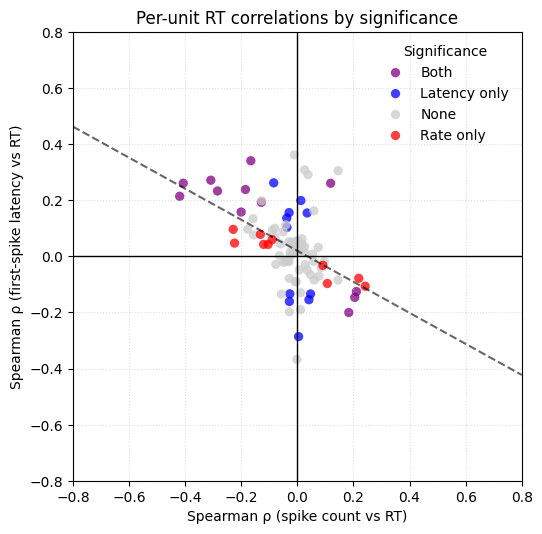

In [85]:
# ==== Compare "rate vs RT" and "first-spike latency vs RT" at the unit level ====
# Requires:
#   cor_df_count   with columns: ['unit_id','session','spearman_rho','spearman_p']
#   cor_df_latency with columns: ['unit_id','session','spearman_rho','spearman_p']

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr, fisher_exact

# ------------------ CONFIG ------------------
ALPHA = 0.05
SIGN_MATCH_REQUIRED = False
TITLE_SUFFIX = ""
SAVE_FIG = False
FIG_DIR = None  # e.g., Path("./figs")
# --------------------------------------------

required_cols = {"unit_id", "session", "spearman_rho", "spearman_p"}
cor_df_count = cor_df_move.copy()
for name, df in [("cor_df_count", cor_df_count), ("cor_df_latency", cor_df_latency)]:
    missing = required_cols - set(df.columns)
    if missing:
        raise ValueError(f"{name} is missing columns: {missing}")

count_df = cor_df_count.rename(columns={"spearman_rho": "rho_count", "spearman_p": "p_count"}).copy()
lat_df   = cor_df_latency.rename(columns={"spearman_rho": "rho_latency", "spearman_p": "p_latency"}).copy()

merged = pd.merge(count_df[["unit_id","session","rho_count","p_count"]],
                  lat_df[["unit_id","session","rho_latency","p_latency"]],
                  on=["unit_id","session"], how="inner")
if merged.empty:
    raise ValueError("No overlapping units between cor_df_count and cor_df_latency.")

# === Correlation across units ===
mask_valid = merged[["rho_count","rho_latency"]].notna().all(axis=1)
rho_spearman, p_spearman = spearmanr(merged.loc[mask_valid, "rho_count"],
                                     merged.loc[mask_valid, "rho_latency"],
                                     nan_policy="omit")
rho_pearson, p_pearson = pearsonr(merged.loc[mask_valid, "rho_count"],
                                  merged.loc[mask_valid, "rho_latency"])
print(f"[Across units] Spearman(ρ_count, ρ_latency) = {rho_spearman:.3f} (p={p_spearman:.3g})")
print(f"[Across units] Pearson (ρ_count, ρ_latency) = {rho_pearson:.3f} (p={p_pearson:.3g})")

# === Categorize significance ===
sig_rate = merged["p_count"] < ALPHA
sig_lat  = merged["p_latency"] < ALPHA
both_sig = sig_rate & sig_lat
rate_only = sig_rate & ~sig_lat
lat_only  = sig_lat & ~sig_rate
none_sig  = ~sig_rate & ~sig_lat
if SIGN_MATCH_REQUIRED:
    sign_match = np.sign(merged["rho_count"]) == np.sign(merged["rho_latency"])
    both_sig &= sign_match

merged["sig_category"] = np.select(
    [both_sig, rate_only, lat_only],
    ["both", "rate_only", "lat_only"],
    default="none"
)
print("\nCategory counts:\n", merged["sig_category"].value_counts())

# === Improved scatter figure ===
colors = {"none": "0.8", "rate_only": "red", "lat_only": "blue", "both": "purple"}
labels = {"none": "None", "rate_only": "Rate only", "lat_only": "Latency only", "both": "Both"}

plt.figure(figsize=(5.5, 5.5))

for cat, subdf in merged.groupby("sig_category"):
    plt.scatter(subdf["rho_count"], subdf["rho_latency"],
                label=labels.get(cat, cat),
                color=colors.get(cat, "k"), alpha=0.75, s=45, edgecolor="none")

# Axes & line formatting
plt.axhline(0, color="k", lw=1)
plt.axvline(0, color="k", lw=1)

# Equal aspect ratio and tight limits based on data
xvals, yvals = merged["rho_count"], merged["rho_latency"]
xlim = np.nanpercentile(xvals, [1, 99])
ylim = np.nanpercentile(yvals, [1, 99])
pad = 0.05 * max(xlim[1] - xlim[0], ylim[1] - ylim[0])
plt.xlim(-.8, .8)
plt.ylim(-.8, .8)
plt.gca().set_aspect("equal", adjustable="box")

# Best-fit line
xy_ok = np.isfinite(xvals) & np.isfinite(yvals)
if xy_ok.sum() >= 2:
    m, b = np.polyfit(xvals[xy_ok], yvals[xy_ok], 1)
    xx = np.linspace(*plt.xlim(), 200)
    plt.plot(xx, m*xx + b, "k--", lw=1.5, alpha=0.6)

plt.xlabel("Spearman ρ (spike count vs RT)")
plt.ylabel("Spearman ρ (first-spike latency vs RT)")
plt.title(f"Per-unit RT correlations by significance{TITLE_SUFFIX}")
plt.legend(frameon=False, title="Significance", loc="best")
plt.grid(True, ls=":", alpha=0.4)
plt.tight_layout()
plt.show()


In [86]:
all_counts_df

trial  unit_id                              session align_key  \
0        0.0     87.0  behavior_716325_2024-05-31_10-31-14     goCue   
1        1.0     87.0  behavior_716325_2024-05-31_10-31-14     goCue   
2        2.0     87.0  behavior_716325_2024-05-31_10-31-14     goCue   
3        3.0     87.0  behavior_716325_2024-05-31_10-31-14     goCue   
4        4.0     87.0  behavior_716325_2024-05-31_10-31-14     goCue   
...      ...      ...                                  ...       ...   
27978  277.0    373.0  behavior_782394_2025-04-24_12-07-34     goCue   
27979  278.0    373.0  behavior_782394_2025-04-24_12-07-34     goCue   
27980  279.0    373.0  behavior_782394_2025-04-24_12-07-34     goCue   
27981  283.0    373.0  behavior_782394_2025-04-24_12-07-34     goCue   
27982  286.0    373.0  behavior_782394_2025-04-24_12-07-34     goCue   

       win_start_s  win_stop_s  spike_count  spike_rate_hz  lat_win_start_s  \
0              0.0         0.1            2           20.0              0.0   
1              0.0         0.1            1           10.0              0.0   
2              0.0         0.1            1           10.0              0.0   
3              0.0         0.1            1           10.0              0.0   
4              0.0         0.1            1           10.0              0.0   
...            ...         ...          ...            ...              ...   
27978          0.0         0.1            3           30.0              0.0   
27979          0.0         0.1            1           10.0              0.0   
27980          0.0         0.1            1           10.0              0.0   
27981          0.0         0.1            1           10.0              0.0   
27982          0.0         0.1            0            0.0              0.0   

       lat_win_stop_s  ...  first_move_peak_velocity  \
0                 0.1  ...               1483.961486   
1                 0.1  ...               2377.511366   
2                 0.1  ...               1745.380932   
3                 0.1  ...               4456.219236   
4                 0.1  ...               2430.964874   
...               ...  ...                       ...   
27978             0.1  ...               2716.600110   
27979             0.1  ...               3433.536587   
27980             0.1  ...               2766.040882   
27981             0.1  ...               2871.496243   
27982             0.1  ...               2977.790052   

       first_move_mean_velocity  first_move_excursion_angle_deg  \
0                    610.239311                       13.058743   
1                    659.329065                       36.891255   
2                    567.940833                       25.132614   
3                    835.839980                      -25.225152   
4                    609.179382                       13.999791   
...                         ...                             ...   
27978               1365.779964                      -40.097665   
27979               1969.451685                      -69.426931   
27980               1784.887851                      -54.121320   
27981               1104.259858                       -4.082600   
27982               1030.563489                        5.196254   

       first_move_endpoint_x  first_move_endpoint_y  \
0                 377.722976             331.769160   
1                 379.652147             355.626119   
2                 368.014085             337.462437   
3                 371.526788             304.311110   
4                 375.776027             332.034505   
...                      ...                    ...   
27978             385.220401             279.146162   
27979             387.106558             243.212657   
27980             399.828570             249.781861   
27981             408.935927             290.524625   
27982             404.468484             296.720936   

       cue_response_peak_velocity  cue_response_mean_v

In [42]:
all_counts_df_old = all_counts_df.copy()

In [87]:
all_counts_df_old

trial  unit_id                              session align_key  \
0        0.0     87.0  behavior_716325_2024-05-31_10-31-14     goCue   
1        1.0     87.0  behavior_716325_2024-05-31_10-31-14     goCue   
2        2.0     87.0  behavior_716325_2024-05-31_10-31-14     goCue   
3        3.0     87.0  behavior_716325_2024-05-31_10-31-14     goCue   
4        4.0     87.0  behavior_716325_2024-05-31_10-31-14     goCue   
...      ...      ...                                  ...       ...   
10993  463.0     59.0  behavior_781166_2025-05-15_14-20-51     goCue   
10994  464.0     59.0  behavior_781166_2025-05-15_14-20-51     goCue   
10995  465.0     59.0  behavior_781166_2025-05-15_14-20-51     goCue   
10996  466.0     59.0  behavior_781166_2025-05-15_14-20-51     goCue   
10997  467.0     59.0  behavior_781166_2025-05-15_14-20-51     goCue   

       win_start_s  win_stop_s  spike_count  spike_rate_hz  lat_win_start_s  \
0              0.0         0.1            2           20.0              0.0   
1              0.0         0.1            1           10.0              0.0   
2              0.0         0.1            1           10.0              0.0   
3              0.0         0.1            1           10.0              0.0   
4              0.0         0.1            1           10.0              0.0   
...            ...         ...          ...            ...              ...   
10993          0.0         0.1            1           10.0              0.0   
10994          0.0         0.1            0            0.0              0.0   
10995          0.0         0.1            0            0.0              0.0   
10996          0.0         0.1            1           10.0              0.0   
10997          0.0         0.1            1           10.0              0.0   

       lat_win_stop_s  ...  first_move_peak_velocity  \
0                 0.1  ...               3818.622263   
1                 0.1  ...               2776.481268   
2                 0.1  ...               5088.581330   
3                 0.1  ...               2219.583045   
4                 0.1  ...               2722.791136   
...               ...  ...                       ...   
10993             0.1  ...               3533.499207   
10994             0.1  ...               2919.637395   
10995             0.1  ...               2912.541976   
10996             0.1  ...               1706.671962   
10997             0.1  ...               2311.123277   

       first_move_mean_velocity  first_move_excursion_angle_deg  \
0                    797.639391                        9.876010   
1                    784.378150                       35.155946   
2                    809.269927                       21.902987   
3                    832.012074                      -16.043920   
4                    681.465856                       11.461949   
...                         ...                             ...   
10993               1081.766929                       23.874087   
10994               1037.083480                       22.492431   
10995                973.070612                       31.207240   
10996                612.319126                      -46.569282   
10997               1070.892590                      -46.720145   

       first_move_endpoint_x  first_move_endpoint_y  \
0                 380.062378             328.777998   
1                 382.152153             354.820825   
2                 370.310473             335.422083   
3                 376.450097             308.420543   
4                 378.160086             329.720739   
...                      ...                    ...   
10993             386.831712             298.263160   
10994             384.981754             296.486212   
10995             390.357890             306.180269   
10996             382.300971             249.951781   
10997             376.483891             255.956479   

       cue_response_peak_velocity  cue_response_mean_v

In [88]:
import pandas as pd

# assume you have: all_counts_df (new) and all_counts_df_old (old)

# --- define the join keys ---
keys = ["session", "unit_id", "trial", "align_key", "win_start_s", "win_stop_s"]

# --- merge on those keys to align matching entries ---
merged = all_counts_df.merge(
    all_counts_df_old[keys + ["spike_count"]],
    on=keys,
    how="outer",
    suffixes=("", "_old"),
    indicator=True
)

# --- compute differences ---
merged["spike_count_diff"] = merged["spike_count"] - merged["spike_count_old"]

# --- summary of differences ---
same = (merged["spike_count_diff"] == 0).sum()
different = (merged["spike_count_diff"] != 0).sum()
missing_in_new = (merged["_merge"] == "right_only").sum()
missing_in_old = (merged["_merge"] == "left_only").sum()

print(f"Same spike counts: {same}")
print(f"Different spike counts: {different}")
print(f"Missing in new: {missing_in_new}")
print(f"Missing in old: {missing_in_old}")

# --- inspect differences per unit ---
diff_per_unit = (
    merged.loc[merged["spike_count_diff"] != 0]
    .groupby("unit_id")["spike_count_diff"]
    .count()
    .rename("n_trials_different")
)

print(diff_per_unit.sort_values(ascending=False))


Same spike counts: 10041
Different spike counts: 18899
Missing in new: 957
Missing in old: 17942
unit_id
4.0      0
5.0      0
7.0      0
9.0      0
10.0     0
11.0     0
12.0     0
13.0     0
14.0     0
15.0     0
16.0     0
17.0     0
18.0     0
19.0     0
20.0     0
21.0     0
23.0     0
24.0     0
26.0     0
27.0     0
28.0     0
29.0     0
31.0     0
32.0     0
34.0     0
36.0     0
37.0     0
39.0     0
40.0     0
41.0     0
44.0     0
45.0     0
46.0     0
49.0     0
51.0     0
56.0     0
57.0     0
59.0     0
85.0     0
98.0     0
100.0    0
101.0    0
113.0    0
144.0    0
162.0    0
194.0    0
228.0    0
249.0    0
276.0    0
285.0    0
288.0    0
367.0    0
373.0    0
Name: n_trials_different, dtype: int64


In [90]:
# check if both have the same keys
keys = ["session", "unit_id", "trial", "align_key", "win_start_s", "win_stop_s"]

old_keys = set(tuple(x) for x in all_counts_df_old[keys].to_numpy())
new_keys = set(tuple(x) for x in all_counts_df[keys].to_numpy())

print("Rows in new but not old:", len(new_keys - old_keys))
print("Rows in old but not new:", len(old_keys - new_keys))


Rows in new but not old: 17942
Rows in old but not new: 957


In [91]:
import pandas as pd

keys = ["session", "unit_id", "trial", "align_key", "win_start_s", "win_stop_s"]

old_keys_df = pd.DataFrame(list(old_keys), columns=keys)
new_keys_df = pd.DataFrame(list(new_keys), columns=keys)

only_in_new = pd.merge(new_keys_df, old_keys_df, on=keys, how="left", indicator=True).query("_merge == 'left_only'")
only_in_old = pd.merge(old_keys_df, new_keys_df, on=keys, how="left", indicator=True).query("_merge == 'left_only'")

# summarize by session and by unit
new_summary = only_in_new.groupby("session")["unit_id"].nunique().sort_values(ascending=False)
old_summary = only_in_old.groupby("session")["unit_id"].nunique().sort_values(ascending=False)

print("Sessions with new-only rows:\n", new_summary.head(10))
print("\nSessions with old-only rows:\n", old_summary.head(10))


Sessions with new-only rows:
 session
behavior_782394_2025-04-23_10-51-17    9
behavior_782394_2025-04-24_12-07-34    7
behavior_751181_2025-02-27_11-24-47    5
behavior_751766_2025-02-11_11-53-38    5
behavior_751769_2025-01-18_10-15-25    5
behavior_754897_2025-03-14_11-28-53    5
behavior_758018_2025-03-20_11-53-05    4
behavior_758017_2025-02-07_14-11-08    4
behavior_751766_2025-02-14_11-37-11    4
behavior_751766_2025-02-13_11-31-21    3
Name: unit_id, dtype: int64

Sessions with old-only rows:
 session
behavior_717121_2024-06-15_10-00-58    1
behavior_781166_2025-05-15_14-20-51    1
Name: unit_id, dtype: int64


abs_rho_count vs coverage_pct: Spearman ρ=0.178, p=0.266, n=41
abs_rho_latency vs coverage_pct: Spearman ρ=0.281, p=0.0752, n=41
abs_rho_count vs duration_p50: Spearman ρ=0.362, p=0.02, n=41
abs_rho_latency vs duration_p50: Spearman ρ=0.443, p=0.00369, n=41


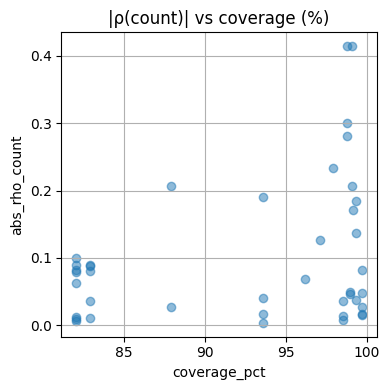

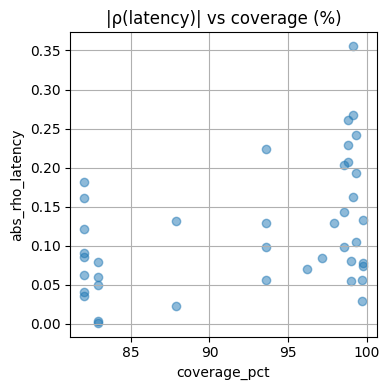

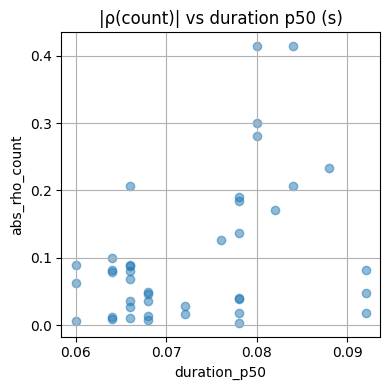

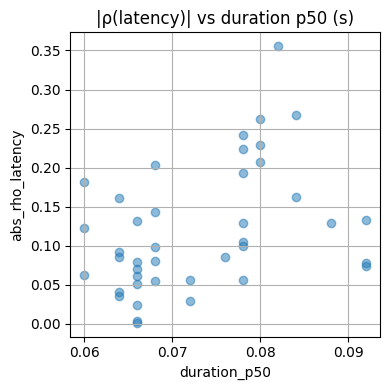

In [44]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# --- Helpers ---
def get_session_prefix(s: str) -> str:
    # 'behavior_751004_2024-12-20_13-26-07' -> 'behavior_751004_2024-12-20'
    return re.sub(r'_\d{2}-\d{2}-\d{2}$', '', s)

def add_session_prefix_col(df: pd.DataFrame, col: str, new_col: str = 'session_prefix') -> pd.DataFrame:
    out = df.copy()
    out[new_col] = out[col].astype(str).apply(get_session_prefix)
    return out

# --- 0) Normalize keys ---
# merged: per-unit table with column 'session'
units = add_session_prefix_col(merged, 'session', 'session_prefix')

# filtered_df: per-session table with column 'session_id'
sess = add_session_prefix_col(filtered_df, 'session_id', 'session_prefix')

# In case there are multiple rows per prefix (e.g., multiple runs that same day),
# aggregate to a single row per prefix. Using mean is a sensible default.
sess_agg = (
    sess
      .groupby('session_prefix', as_index=False)
      .agg({
          'coverage_pct': 'mean',
          'duration_p50': 'mean'
      })
      .merge(
          sess.groupby('session_prefix', as_index=False).size().rename(columns={'size':'n_rows_from_filtered'}),
          on='session_prefix',
          how='left'
      )
)

# --- 1) Merge session-level metrics onto per-unit table ---
df_units = units.merge(sess_agg, on='session_prefix', how='left')

# --- 2) Compute absolute rho values ---
df_units['abs_rho_count'] = df_units['rho_count'].abs()
df_units['abs_rho_latency'] = df_units['rho_latency'].abs()

# --- 3) Correlate per-unit |rho| with session-level quality metrics ---
for metric in ['coverage_pct', 'duration_p50']:
    for rho_col in ['abs_rho_count', 'abs_rho_latency']:
        valid = df_units[[metric, rho_col]].dropna()
        rho, pval = spearmanr(valid[metric], valid[rho_col])
        print(f"{rho_col} vs {metric}: Spearman ρ={rho:.3f}, p={pval:.3g}, n={len(valid)}")

# --- 4) Quick scatter plots ---
def plot_scatter(df, x, y, title):
    plt.figure(figsize=(4,4))
    plt.scatter(df[x], df[y], alpha=0.5)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_scatter(df_units.dropna(subset=['coverage_pct','abs_rho_count']),
             'coverage_pct', 'abs_rho_count', '|ρ(count)| vs coverage (%)')

plot_scatter(df_units.dropna(subset=['coverage_pct','abs_rho_latency']),
             'coverage_pct', 'abs_rho_latency', '|ρ(latency)| vs coverage (%)')

plot_scatter(df_units.dropna(subset=['duration_p50','abs_rho_count']),
             'duration_p50', 'abs_rho_count', '|ρ(count)| vs duration p50 (s)')

plot_scatter(df_units.dropna(subset=['duration_p50','abs_rho_latency']),
             'duration_p50', 'abs_rho_latency', '|ρ(latency)| vs duration p50 (s)')


In [39]:
df_merged

unit_id                              session  rho_count       p_count  \
0      87.0  behavior_716325_2024-05-31_10-31-14  -0.081974  5.882882e-02   
1     197.0  behavior_716325_2024-05-31_10-31-14  -0.047256  2.765913e-01   
2     377.0  behavior_716325_2024-05-31_10-31-14  -0.017398  6.888778e-01   
3     162.0  behavior_717121_2024-06-15_10-00-58  -0.232955  1.297220e-07   
4      40.0  behavior_751004_2024-12-20_13-26-11  -0.038167  4.050831e-01   
5     263.0  behavior_751004_2024-12-20_13-26-11  -0.184992  4.719273e-05   
6     268.0  behavior_751004_2024-12-20_13-26-11  -0.137327  2.622596e-03   
7       6.0  behavior_751004_2024-12-21_13-28-28  -0.300873  3.936797e-12   
8      22.0  behavior_751004_2024-12-21_13-28-28  -0.414237  1.450686e-22   
9     195.0  behavior_751004_2024-12-21_13-28-28  -0.281078  1.027791e-10   
10    123.0  behavior_751004_2024-12-22_13-09-17  -0.171108  6.845600e-05   
11    145.0  behavior_751004_2024-12-23_14-20-03  -0.414288  4.255265e-19   
12    146.0  behavior_751004_2024-12-23_14-20-03  -0.206491  1.740724e-05   
13     40.0  behavior_751766_2025-02-11_11-53-38  -0.087548  1.396941e-01   
14     46.0  behavior_751766_2025-02-11_11-53-38   0.089568  1.307544e-01   
15     49.0  behavior_751766_2025-02-11_11-53-38   0.080895  1.724708e-01   
16     59.0  behavior_751766_2025-02-11_11-53-38  -0.010877  8.546814e-01   
17    285.0  behavior_751766_2025-02-11_11-53-38   0.035621  5.485390e-01   
18     23.0  behavior_751769_2025-01-17_11-37-39   0.006009  9.436207e-01   
19    276.0  behavior_751769_2025-01-17_11-37-39  -0.089830  2.894555e-01   
20    288.0  behavior_751769_2025-01-17_11-37-39  -0.062954  4.583148e-01   
21     20.0  behavior_751769_2025-01-18_10-15-25  -0.008734  9.152404e-01   
22     23.0  behavior_751769_2025-01-18_10-15-25  -0.078854  3.358406e-01   
23     29.0  behavior_751769_2025-01-18_10-15-25   0.099262  2.252766e-01   
24     49.0  behavior_751769_2025-01-18_10-15-25   0.081953  3.171307e-01   
25    194.0  behavior_751769_2025-01-18_10-15-25   0.011827  8.853960e-01   
26     37.0  behavior_758017_2025-02-05_11-42-34   0.206962  3.148014e-04   
27     39.0  behavior_758017_2025-02-05_11-42-34  -0.027628  6.342064e-01   
28     85.0  behavior_758017_2025-02-06_11-26-14  -0.126790  1.593531e-02   
29     15.0  behavior_758017_2025-02-07_14-11-08   0.189842  1.050452e-03   
30     17.0  behavior_758017_2025-02-07_14-11-08   0.017534  7.642538e-01   
31     31.0  behavior_758017_2025-02-07_14-11-08  -0.040473  4.886350e-01   
32     44.0  behavior_758017_2025-02-07_14-11-08   0.003617  9.506795e-01   
33     13.0  behavior_761038_2025-04-15_10-25-11  -0.016029  8.222045e-01   
34    259.0  behavior_761038_2025-04-15_10-25-11  -0.027774  6.969779e-01   
35     10.0  behavior_761038_2025-04-16_10-39-10   0.013963  7.753948e-01   
36     47.0  behavior_761038_2025-04-16_10-39-10   0.036159  4.598625e-01   
37    213.0  behavior_761038_2025-04-16_10-39-10  -0.007493  8.783103e-01   
38     12.0  behavior_761038_2025-04-18_12-37-39  -0.048756  3.036981e-01   
39     15.0  behavior_761038_2025-04-18_12-37-39  -0.046919  3.223023e-01   
40     59.0  behavior_781166_2025-05-15_14-20-51  -0.068175  1.465236e-01   

    rho_latency     p_latency sig_category  \
0      0.078218  9.169273e-02         none   
1      0.132436  2.485081e-02     lat_only   
2      0.074606  1.264208e-01         none   
3     -0.128934  2.057656e-01    rate_only   
4      0.104928  8.128565e-02         none   
5      0.241686  7.505309e-05         both   
6      0.193466  2.077578e-03         both   
7      0.261644  1.369243e-08         both   
8      0.206802  9.529966e-06         both   
9      0.229529  3.228009e-06         both   
10     0.355500  2.235071e-08         both   
11     0.267385  1.307809e-07         both   
12     0.162121  2.561887e-03         both   
13     0.060651  3.162809e-01         none   
14    -0.079660  2.159626e-01         none   
15     0.003444  9.574058e-01    

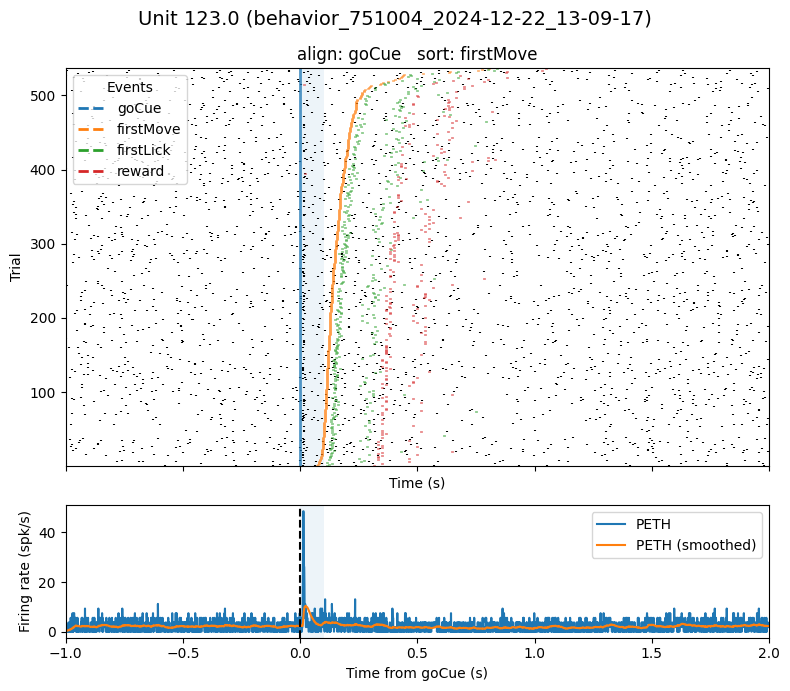

In [62]:
# Pick one unit (example)
row = units_with_spikes.iloc[10]          # or pick by session/unit_id
session = row["session"]
spikes_abs = np.array(row["spike_times"], dtype=float)  # from NWB

# 1) Get the session bundle (already made with cfg)
bundle = bundle_cache[session]
Ev          = bundle["Ev"]                 # DataFrame of event times per trial
align_times = bundle["align_times"]        # Series: trial -> t0 (absolute, s)
offset      = bundle["session_offset"]     # to convert absolute → session time

# 2) Convert spikes to session time (skip if yours are already in session time)
spikes = spikes_abs - offset

# 3) Turn Ev into dicts that the wrapper expects
event_dicts = {col: Ev[col].dropna().to_dict() for col in Ev.columns}
trials = Ev.index.tolist()

# 4) Build the plotter (choose align & sort; align from cfg is convenient)
align_by = cfg.align_key      # e.g., "goCue"
sort_by  = "firstMove"        # or "firstLick", "reward", etc.

rp, events = make_rp_and_events(
    spikes=spikes,
    trials=trials,
    event_dicts=event_dicts,
    events_to_plot=['goCue','firstMove','firstLick','reward'],
    align_by=align_by,
    sort_by=sort_by,
    pre=1.0,
    post=2.0,
    bin_size=0.001,
)

# 5) Plot (raster + PSTH)
fig, (ax_raster, ax_psth) = plt.subplots(
    2, 1, figsize=(8, 7), sharex=True, gridspec_kw={'height_ratios':[3,1]}
)
rp.plot_raster(ax=ax_raster, spike_color='black')
rp.add_events(ax_raster, events)
ax_raster.set_title(f'align: {align_by}   sort: {sort_by}')
ax_raster.legend(loc='upper left', title='Events')

# optional: shade your analysis window from cfg
a, b = cfg.count_window_s
ax_raster.axvspan(a, b, alpha=0.08, linewidth=0)

psth, _  = compute_psth(rp.raster, bin_size=rp.bin_size)
psth_sm  = smooth_vector(psth, bin_size=rp.bin_size, sigma=0.025)
plot_psth(rp.bins, psth, psth_sm, ax=ax_psth, label='PETH')
ax_psth.axvspan(a, b, alpha=0.08, linewidth=0)
ax_psth.set_xlabel(f'Time from {align_by} (s)')

plt.suptitle(f'Unit {row["unit_id"]} ({session})', fontsize=14)

plt.tight_layout()
plt.show()
if SAVE_FIG:
    fname = FIG_DIR / "example_raster_alignGo_sortMove"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"{fname}.svg", bbox_inches="tight")


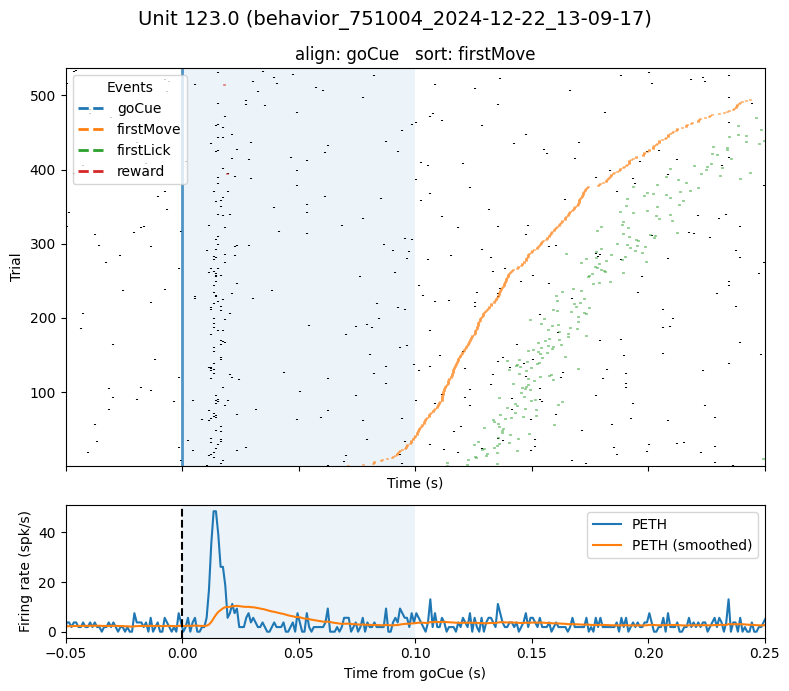

In [64]:
# 5) Plot (raster + PSTH)
fig, (ax_raster, ax_psth) = plt.subplots(
    2, 1, figsize=(8, 7), sharex=True, gridspec_kw={'height_ratios':[3,1]}
)
rp.plot_raster(ax=ax_raster, spike_color='black')
rp.add_events(ax_raster, events)
ax_raster.set_title(f'align: {align_by}   sort: {sort_by}')
ax_raster.legend(loc='upper left', title='Events')

# optional: shade your analysis window from cfg
a, b = cfg.count_window_s
ax_raster.axvspan(a, b, alpha=0.08, linewidth=0)

psth, _  = compute_psth(rp.raster, bin_size=rp.bin_size)
psth_sm  = smooth_vector(psth, bin_size=rp.bin_size, sigma=0.025)
plot_psth(rp.bins, psth, psth_sm, ax=ax_psth, label='PETH')
ax_psth.axvspan(a, b, alpha=0.08, linewidth=0)
ax_psth.set_xlabel(f'Time from {align_by} (s)')

plt.xlim(-.05, .25)

plt.suptitle(f'Unit {row["unit_id"]} ({session})', fontsize=14)

plt.tight_layout()
plt.show()
if SAVE_FIG:
    fname = FIG_DIR / "example_raster_alignGo_sortMove"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"{fname}.svg", bbox_inches="tight")

<Figure size 800x700 with 0 Axes>

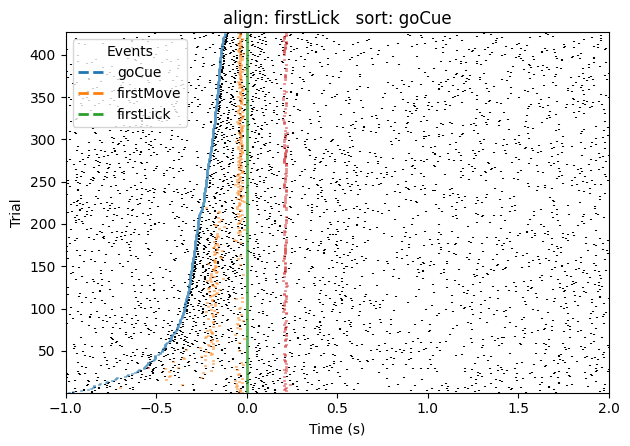

In [47]:
import matplotlib.pyplot as plt

new_align = "firstLick"
new_sort  = "goCue"

# Assume spikes, trials, event_dicts, row, session, FIG_DIR, SAVE_FIG defined above

rp, events = make_rp_and_events(
    spikes=spikes,
    trials=trials,
    event_dicts=event_dicts,
    events_to_plot=['goCue','firstMove','firstLick','reward'],
    align_by=new_align,
    sort_by=new_sort,
    pre=1.0, post=2.0, bin_size=0.001,
)

fig = plt.figure(figsize=(8, 7))
ax = rp.plot_raster(spike_color="black")
rp.add_events(ax, events)
ax.set_title(f"align: {new_align}   sort: {new_sort}")
ax.legend(loc='upper left', title='Events')

# Use fig.suptitle instead of plt.suptitle (better control)
fig.suptitle(f'Unit {row["unit_id"]} ({session})', fontsize=14, y=1.02)

# Then adjust layout *after* suptitle
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave room for suptitle

if SAVE_FIG:
    fname = FIG_DIR / "example_raster_alignLick_sortGo"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"{fname}.svg", bbox_inches="tight")

plt.show()


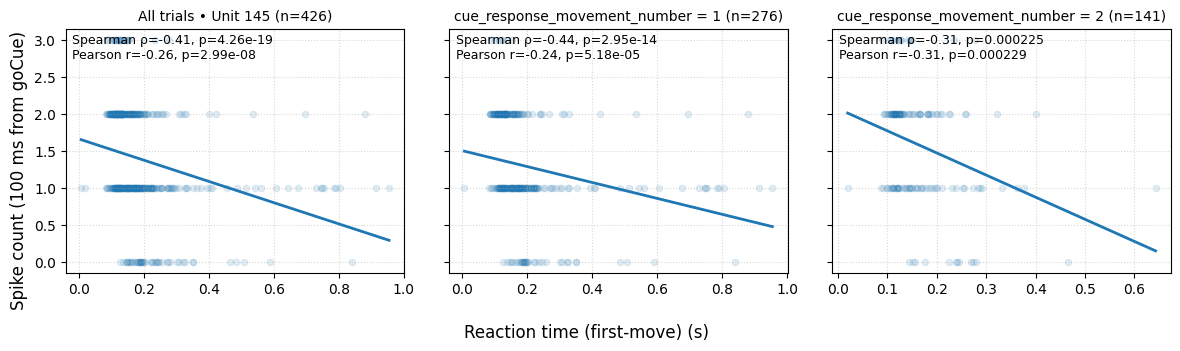

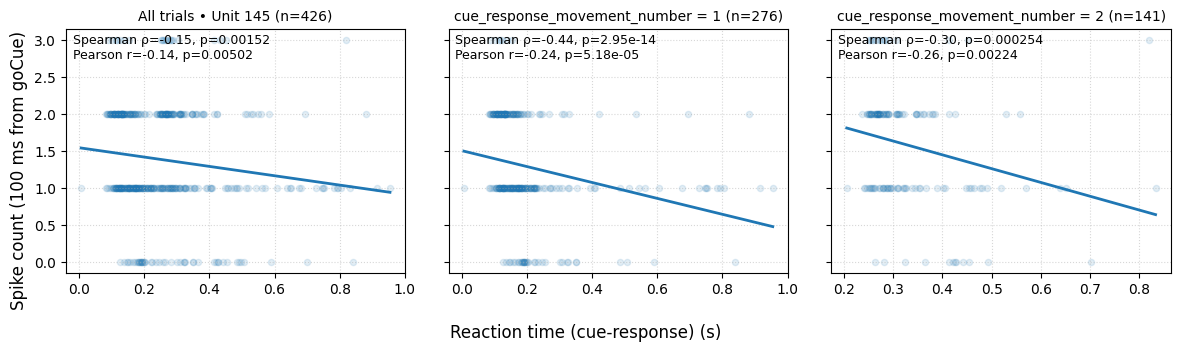

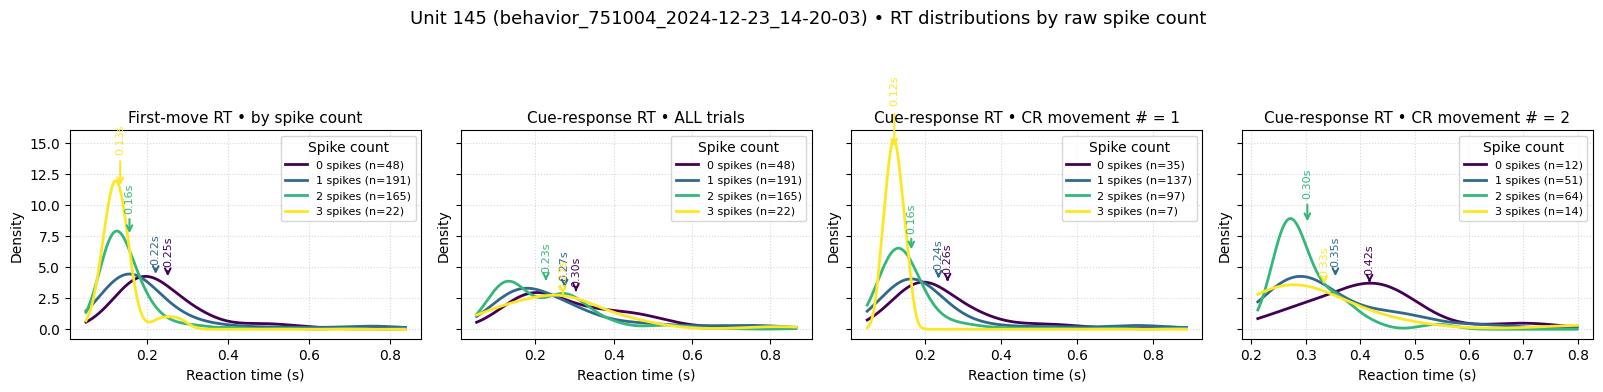

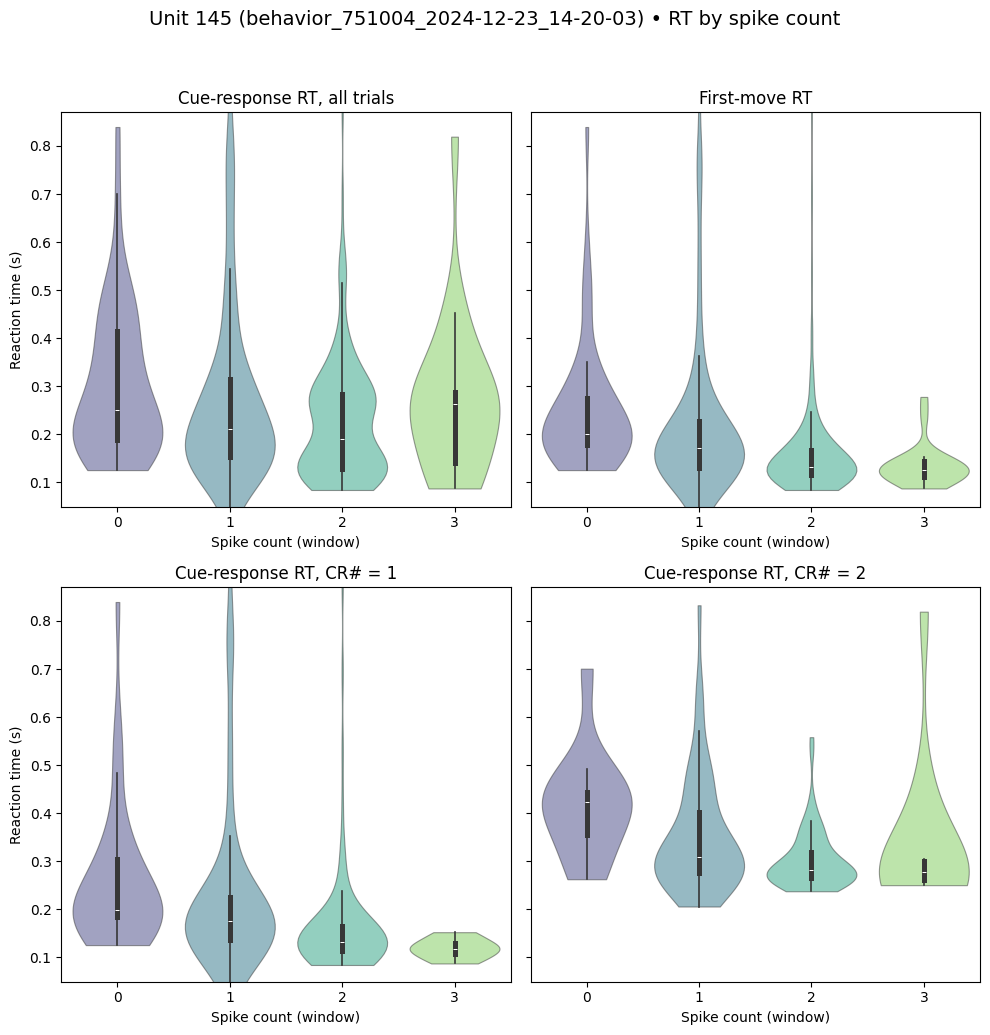

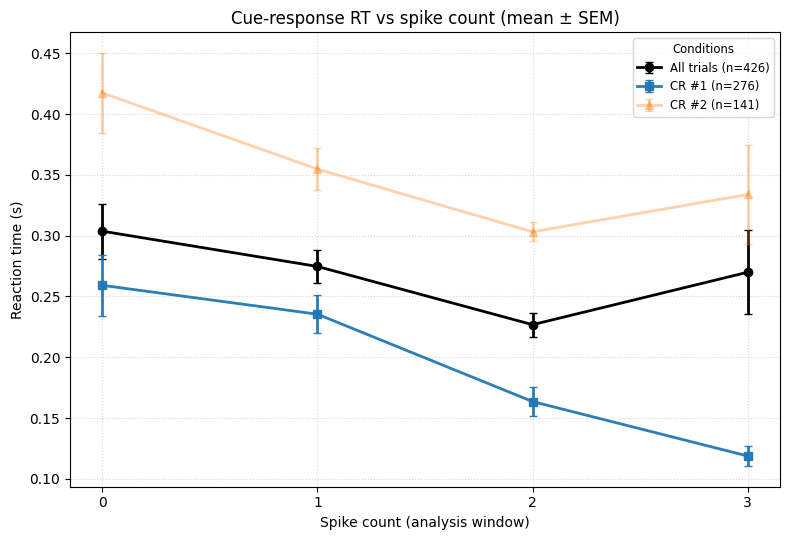

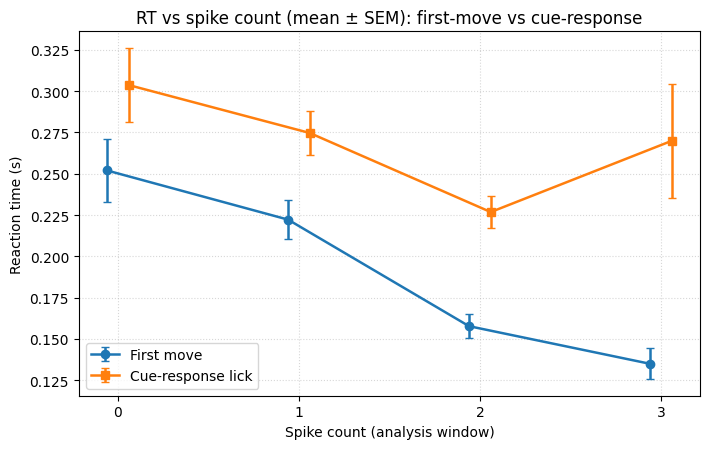

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr, gaussian_kde

# =========================
# Core prep + small helpers
# =========================
RT_FIRST = "reaction_time_firstmove"
RT_CR    = "reaction_time_cueresponse"
MNUM     = "cue_response_movement_number"

def prep_unit_df(all_counts_df: pd.DataFrame, row: pd.Series) -> pd.DataFrame:
    """Filter to this unit/session and coerce numeric cols."""
    uid, sess = int(row["unit_id"]), str(row["session"])
    df = (all_counts_df
          .query("unit_id == @uid and session == @sess")
          .copy())
    for c in ("spike_count", RT_FIRST, RT_CR):
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def cr_subsets(df: pd.DataFrame) -> dict:
    """Common subsets for CR analysis."""
    df_all = df.dropna(subset=["spike_count"])
    if MNUM in df.columns:
        return {
            "All trials": df_all,
            "CR #1": df_all[df_all[MNUM].eq(1)],
            "CR #2": df_all[df_all[MNUM].eq(2)],
        }
    else:
        empty = df_all.iloc[0:0]
        return {"All trials": df_all, "CR #1": empty, "CR #2": empty}

def union_levels(*dfs: pd.DataFrame) -> list[int]:
    """Union of integer spike_count levels across dataframes."""
    levels = set()
    for d in dfs:
        if d is None or d.empty or "spike_count" not in d:
            continue
        levels |= set(d["spike_count"].dropna().astype(int).unique().tolist())
    return sorted(levels)

def mean_sem_by_count(df: pd.DataFrame, val_col: str, levels: list[int]) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Return mean, sem, n for val_col per spike_count (aligned to levels)."""
    if df is None or df.empty:
        n = np.zeros(len(levels))
        return (np.full(len(levels), np.nan),
                np.full(len(levels), np.nan),
                n)
    agg = (df.dropna(subset=["spike_count", val_col])
             .groupby("spike_count")[val_col]
             .agg(mean="mean", std="std", count="count")
             .reindex(levels))
    sem = agg["std"] / np.sqrt(agg["count"])
    return agg["mean"].to_numpy(float), sem.to_numpy(float), agg["count"].fillna(0).to_numpy(int)

# =========================
# Figure 1: Corr panels
# =========================
def _scatter_with_fit_and_stats(ax, x, y, title):
    if len(x) < 3:
        ax.text(0.5, 0.5, "n < 3", ha="center", va="center")
        ax.set_axis_off()
        return
    ax.scatter(x, y, s=20, alpha=0.12)
    ax.grid(True, ls=":", alpha=0.5)
    ax.set_title(f"{title} (n={len(x)})", fontsize=10)
    # Fit if both vary
    if np.unique(x).size >= 2 and np.unique(y).size >= 2:
        m, b = np.polyfit(x, y, 1)
        xx = np.linspace(np.nanmin(x), np.nanmax(x), 100)
        ax.plot(xx, m*xx + b, lw=2)
    # Stats (NaN-safe Spearman; Pearson only if both vary)
    rho, ps = spearmanr(x, y, nan_policy="omit")
    r, pp = (np.nan, np.nan)
    if np.unique(x).size >= 2 and np.unique(y).size >= 2:
        r, pp = pearsonr(x, y)
    ax.text(0.02, 0.98,
            f"Spearman ρ={rho:0.2f}, p={ps:0.3g}\nPearson r={r:0.2f}, p={pp:0.3g}",
            ha="left", va="top", transform=ax.transAxes, fontsize=9)

def make_corr_figure(all_counts_df, row, rt_col, cfg):
    """Three-panel correlation: All / CR#1 / CR#2 for a given RT column."""
    df = prep_unit_df(all_counts_df, row)
    uid = int(row["unit_id"])
    sess = str(row["session"])
    labs = {RT_FIRST: "first-move", RT_CR: "cue-response"}
    rt_label = labs.get(rt_col, rt_col)

    subs = cr_subsets(df.dropna(subset=[rt_col, "spike_count"]))
    titles = [f"All trials • Unit {uid}", "cue_response_movement_number = 1", "cue_response_movement_number = 2"]

    fig, axes = plt.subplots(1, 3, figsize=(12, 3.5), sharey=True)
    for ax, (k, d), t in zip(axes, subs.items(), titles):
        _scatter_with_fit_and_stats(ax, d[rt_col].to_numpy(), d["spike_count"].to_numpy(), t)

    fig.supxlabel(f"Reaction time ({rt_label}) (s)")
    ms = (cfg.count_window_s[1] - cfg.count_window_s[0]) * 1000
    fig.supylabel(f"Spike count ({ms:.0f} ms from {cfg.align_key})")
    plt.tight_layout(w_pad=2.0)
    plt.show()

# =========================
# Figure 2: KDE panels
# =========================
def plot_kde_by_spikecount(ax, df, rt_col, title, rug=False, show_mean=True):
    d = df.dropna(subset=[rt_col, "spike_count"])
    if d.empty:
        ax.text(0.5, 0.5, "No data", ha="center", va="center"); ax.set_axis_off(); return
    x_min, x_max = d[rt_col].quantile([0.01, 0.99]).astype(float)
    pad = 0.05 * max(1e-9, x_max - x_min)
    xs = np.linspace(x_min - pad, x_max + pad, 400)

    levels = sorted(d["spike_count"].astype(int).unique().tolist())
    norm = plt.Normalize(min(levels), max(levels))
    cmap = plt.cm.viridis
    for sc in levels:
        vals = d.loc[d["spike_count"].astype(int).eq(sc), rt_col].to_numpy()
        color = cmap(norm(sc))
        label = f"{sc} spikes (n={len(vals)})"
        if len(vals) < 2 or np.all(vals == vals[0]):
            if len(vals):
                ax.plot([vals[0], vals[0]], [0, 0.02], lw=2, alpha=0.7, color=color, label=label)
            else:
                ax.plot([], [], color=color, label=label)
            continue
        kde = gaussian_kde(vals)
        ys = kde(xs)
        ax.plot(xs, ys, lw=2, color=color, label=label)
        if rug:
            ax.plot(vals, np.full_like(vals, ys.max()*-0.05), '|', alpha=0.3, color=color)
        if show_mean:
            m = float(np.mean(vals)); ymax = float(ys.max())
            ax.annotate("", xy=(m, ymax*0.95), xytext=(m, ymax*1.15),
                        arrowprops=dict(arrowstyle="->", lw=1.5, color=color))
            ax.text(m, ymax*1.18, f"{m:.2f}s", ha="center", va="bottom", fontsize=8, rotation=90, color=color)
    ax.set_title(title, fontsize=11)
    ax.set_xlabel("Reaction time (s)")
    ax.set_ylabel("Density")
    ax.grid(True, ls=":", alpha=0.5)
    ax.legend(title="Spike count", fontsize=8)

def make_kde_figure(all_counts_df, row):
    """Four-panel KDEs: first-move, CR all, CR#1, CR#2."""
    df = prep_unit_df(all_counts_df, row)
    uid, sess = int(row["unit_id"]), str(row["session"])
    subs = cr_subsets(df)

    fig, axes = plt.subplots(1, 4, figsize=(16, 3.8), sharey=True)
    plot_kde_by_spikecount(axes[0], df,       RT_FIRST, "First-move RT • by spike count")
    plot_kde_by_spikecount(axes[1], subs["All trials"], RT_CR,    "Cue-response RT • ALL trials")
    plot_kde_by_spikecount(axes[2], subs["CR #1"],      RT_CR,    "Cue-response RT • CR movement # = 1")
    plot_kde_by_spikecount(axes[3], subs["CR #2"],      RT_CR,    "Cue-response RT • CR movement # = 2")
    fig.suptitle(f"Unit {uid} ({sess}) • RT distributions by raw spike count", y=1.02, fontsize=13)
    plt.tight_layout(); plt.show()

# =========================
# Figure 3: Violin panels
# =========================
def _robust_ylim(*series):
    pool = pd.concat([s.dropna() for s in series if s is not None and len(s)], axis=0)
    if pool.empty:
        return None
    q1, q99 = pool.quantile([0.01, 0.99]).astype(float)
    pad = 0.05 * max(1e-9, q99 - q1)
    return (float(q1 - pad), float(q99 + pad))

def make_violin_figure(all_counts_df, row):
    """Violin plots of RT vs spike_count for: CR all, First-move, CR#1, CR#2."""
    import seaborn as sns
    df = prep_unit_df(all_counts_df, row)
    subs = cr_subsets(df)
    levels = union_levels(df, subs["CR #1"], subs["CR #2"])
    if not levels:
        raise ValueError("No spike_count data for this unit/session.")
    ylim = _robust_ylim(df[RT_FIRST], df[RT_CR],
                        subs["CR #1"][RT_CR] if not subs["CR #1"].empty else None,
                        subs["CR #2"][RT_CR] if not subs["CR #2"].empty else None)

    def violin_panel(ax, d, rt_col, title):
        d = d.dropna(subset=[rt_col, "spike_count"]).copy()
        if d.empty:
            ax.text(0.5,0.5,"No data",ha="center",va="center"); ax.set_axis_off(); return
        d["spike_count_cat"] = pd.Categorical(d["spike_count"].astype(int), categories=levels, ordered=True)
        sns.violinplot(ax=ax, data=d, x="spike_count_cat", y=rt_col,
                       order=levels, palette="viridis", inner="box", cut=0, linewidth=0.8, saturation=0.9)
        for v in ax.collections: v.set_alpha(0.5)
        ax.set_xlabel("Spike count (window)"); ax.set_ylabel("Reaction time (s)"); ax.set_title(title)
        if ylim: ax.set_ylim(*ylim); ax.set_xticklabels([str(sc) for sc in levels])

    fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
    violin_panel(axes[0,0], subs["All trials"], RT_CR,    "Cue-response RT, all trials")
    violin_panel(axes[0,1], df,               RT_FIRST,  "First-move RT")
    violin_panel(axes[1,0], subs["CR #1"],     RT_CR,    "Cue-response RT, CR# = 1")
    violin_panel(axes[1,1], subs["CR #2"],     RT_CR,    "Cue-response RT, CR# = 2")
    uid, sess = int(row["unit_id"]), str(row["session"])
    fig.suptitle(f"Unit {uid} ({sess}) • RT by spike count", y=1.03, fontsize=14)
    plt.tight_layout(); plt.show()

# =========================
# Figure 4A: CR mean±SEM vs count
# =========================
def make_cr_means_figure(all_counts_df, row):
    """Lines with mean±SEM of CR RT vs spike_count: All, CR#1, CR#2 (alpha ~ n)."""
    df = prep_unit_df(all_counts_df, row)
    subs = cr_subsets(df.dropna(subset=[RT_CR, "spike_count"]))
    levels = union_levels(subs["All trials"], subs["CR #1"], subs["CR #2"])
    if not levels:
        raise ValueError("No spike_count data to plot.")

    m_all, se_all, n_all = mean_sem_by_count(subs["All trials"], RT_CR, levels)
    m_1,   se_1,   n_1   = mean_sem_by_count(subs["CR #1"],      RT_CR, levels)
    m_2,   se_2,   n_2   = mean_sem_by_count(subs["CR #2"],      RT_CR, levels)

    def scale_alpha(n_total, lo=0.35, hi=0.95):
        vals = [np.nansum(n_1), np.nansum(n_2)]
        if not np.isfinite(vals).any(): return (lo+hi)/2
        nmin, nmax = np.nanmin(vals), np.nanmax(vals)
        if nmax <= nmin: return (lo+hi)/2
        t = (n_total - nmin) / (nmax - nmin)
        return float(lo + t * (hi - lo))

    fig, ax = plt.subplots(figsize=(8, 5.5))
    x = np.array(levels, dtype=float)

    ax.errorbar(x, m_all, yerr=se_all, fmt='o-', color='black', lw=2, capsize=3,
                label=f"All trials (n={int(np.nansum(n_all))})")
    a1 = scale_alpha(np.nansum(n_1))
    a2 = scale_alpha(np.nansum(n_2))
    ax.errorbar(x, m_1, yerr=se_1, fmt='s-', color='C0', lw=2, capsize=3, alpha=a1,
                label=f"CR #1 (n={int(np.nansum(n_1))})")
    ax.errorbar(x, m_2, yerr=se_2, fmt='^-', color='C1', lw=2, capsize=3, alpha=a2,
                label=f"CR #2 (n={int(np.nansum(n_2))})")

    ax.set_xlabel("Spike count (analysis window)")
    ax.set_ylabel("Reaction time (s)")
    ax.set_xticks(levels); ax.set_xticklabels([str(sc) for sc in levels])
    ax.grid(True, ls=":", alpha=0.5)
    ax.legend(loc="best", fontsize="small", title="Conditions", title_fontsize="small")
    ax.set_title("Cue-response RT vs spike count (mean ± SEM)")
    plt.tight_layout(); plt.show()

# =========================
# Figure 4B: First-move vs CR means
# =========================
def make_first_vs_cr_means_figure(all_counts_df, row):
    """Mean±SEM RT vs spike_count for First-move vs Cue-response (side-by-side)."""
    df = prep_unit_df(all_counts_df, row)
    d_first = df.dropna(subset=["spike_count", RT_FIRST])
    d_cr    = df.dropna(subset=["spike_count", RT_CR])
    levels = union_levels(d_first, d_cr)
    if not levels:
        raise ValueError("No spike_count data for first-move / cue-response.")

    m_f, se_f, n_f = mean_sem_by_count(d_first, RT_FIRST, levels)
    m_c, se_c, n_c = mean_sem_by_count(d_cr,    RT_CR,    levels)

    fig, ax = plt.subplots(figsize=(7.2, 4.6))
    x = np.array(levels, dtype=float); offset = 0.06
    ax.errorbar(x - offset, m_f, yerr=se_f, fmt='o-', capsize=3, lw=1.8, color='C0', label="First move")
    ax.errorbar(x + offset, m_c, yerr=se_c, fmt='s-', capsize=3, lw=1.8, color='C1', label="Cue-response lick")
    ax.set_xlabel("Spike count (analysis window)")
    ax.set_ylabel("Reaction time (s)")
    ax.set_xticks(levels); ax.set_xticklabels([str(sc) for sc in levels])
    ax.grid(True, ls=":", alpha=0.5)
    ax.legend()
    ax.set_title("RT vs spike count (mean ± SEM): first-move vs cue-response")
    plt.tight_layout(); plt.show()

# =========================
# Example usage (pick & choose)
# =========================
df_unit = prep_unit_df(all_counts_df, row)
make_corr_figure(all_counts_df, row, rt_col=RT_FIRST, cfg=cfg)   # first figure for first-move
make_corr_figure(all_counts_df, row, rt_col=RT_CR,    cfg=cfg)   # first figure for cue-response
make_kde_figure(all_counts_df, row)                              # second figure
make_violin_figure(all_counts_df, row)                           # third figure
make_cr_means_figure(all_counts_df, row)                         # fourth figure (CR all/1/2)
make_first_vs_cr_means_figure(all_counts_df, row)                # fourth figure (FM vs CR)


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RT_FIRST = "reaction_time_firstmove"
RT_CR    = "reaction_time_cueresponse"
MNUM     = "cue_response_movement_number"

def _coerce_types(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in ["spike_count", RT_FIRST, RT_CR]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def cr_subsets(df: pd.DataFrame) -> dict:
    d = df.dropna(subset=["spike_count", RT_CR])
    if MNUM in d.columns:
        return {
            "All": d,
            "CR1": d[d[MNUM].eq(1)],
            "CR2": d[d[MNUM].eq(2)],
        }
    else:
        empty = d.iloc[0:0]
        return {"All": d, "CR1": empty, "CR2": empty}

def union_levels(*dfs: pd.DataFrame) -> list[int]:
    levels = set()
    for d in dfs:
        if d is None or d.empty or "spike_count" not in d.columns:
            continue
        levels |= set(d["spike_count"].dropna().astype(int).unique().tolist())
    return sorted(levels)

# ---------- NEW: unit-averaged stats with trial cutoff ----------
def unit_averaged_mean_sem(
    df: pd.DataFrame, rt_col: str, levels: list[int], *,
    min_trials: int = 10,
    unit_keys = ("unit_id","session"),
) -> tuple[np.ndarray, np.ndarray, np.ndarray, list[np.ndarray]]:
    """
    For each (unit_id,session), compute mean RT per spike_count if that unit
    has at least min_trials for that (spike_count). Then aggregate across units:
      - grand_mean[level] = mean of unit means (ignoring NaN)
      - grand_sem[level]  = std(unit means, ddof=1) / sqrt(n_units_with_data)
      - n_units[level]    = number of units contributing at that level
    Also returns the list of per-unit vectors (aligned to levels) for background lines.
    """
    if df is None or df.empty:
        L = len(levels)
        return (np.full(L, np.nan), np.full(L, np.nan), np.zeros(L), [])

    # Per-unit mean per spike_count with cutoff
    per_unit_vectors = []
    for _, d in df.groupby(list(unit_keys), dropna=False):
        g = (d
             .dropna(subset=["spike_count", rt_col])
             .groupby("spike_count")[rt_col]
             .agg(["mean","count"]))
        # apply cutoff
        g = g[g["count"] >= min_trials]["mean"].reindex(levels)
        per_unit_vectors.append(g.to_numpy(dtype=float))  # NaN where insufficient trials

    if not per_unit_vectors:
        L = len(levels)
        return (np.full(L, np.nan), np.full(L, np.nan), np.zeros(L), [])

    M = np.vstack(per_unit_vectors)  # shape: (n_units, n_levels)
    grand_mean = np.nanmean(M, axis=0)
    # SEM over units (not trials)
    n_units = np.sum(np.isfinite(M), axis=0).astype(float)
    grand_std = np.nanstd(M, axis=0, ddof=1)
    with np.errstate(invalid="ignore", divide="ignore"):
        grand_sem = grand_std / np.sqrt(n_units)
    return grand_mean, grand_sem, n_units, per_unit_vectors

def _plot_per_unit_vectors(ax, per_unit_vectors, levels, *,
                           x_offset=0.0, color="C0", alpha=0.12, lw=0.7, ms=2.0):
    x = np.asarray(levels, dtype=float) + x_offset
    for y in per_unit_vectors:
        m = np.isfinite(y)
        if m.sum() >= 2:
            ax.plot(x[m], y[m], color=color, alpha=alpha, lw=lw, label="_nolegend_")
        if m.any():
            ax.plot(x[m], y[m], marker='o', ls='None', color=color, alpha=alpha, ms=ms, label="_nolegend_")

# ============================================================
# UPDATED: Cue-response across units (unit-averaged grand mean)
# ============================================================
def make_cr_means_across_units_unitavg(all_counts_df: pd.DataFrame, *,
                                       min_trials: int = 10, alpha_bg=0.12):
    df = _coerce_types(all_counts_df)
    subs = cr_subsets(df)

    levels = union_levels(subs["All"], subs["CR1"], subs["CR2"])
    if not levels:
        raise ValueError("No spike_count data to plot.")

    # Unit-averaged stats for each condition
    m_all, se_all, nU_all, vec_all = unit_averaged_mean_sem(subs["All"], RT_CR, levels, min_trials=min_trials)
    m_1,   se_1,   nU_1,   vec_1   = unit_averaged_mean_sem(subs["CR1"], RT_CR, levels, min_trials=min_trials)
    m_2,   se_2,   nU_2,   vec_2   = unit_averaged_mean_sem(subs["CR2"], RT_CR, levels, min_trials=min_trials)

    fig, ax = plt.subplots(figsize=(8.2, 5.6))
    x = np.array(levels, dtype=float)

    # Background: per-unit (condition-specific)
    _plot_per_unit_vectors(ax, vec_all, levels, color="0.4", alpha=alpha_bg, lw=2, ms=2)
    _plot_per_unit_vectors(ax, vec_1,   levels, color="C0",  alpha=alpha_bg, lw=2, ms=2)
    _plot_per_unit_vectors(ax, vec_2,   levels, color="C1",  alpha=alpha_bg, lw=2, ms=2)

    # Foreground: grand mean ± SEM (over units)
    ax.errorbar(x, m_all, yerr=se_all, fmt='o-', color='black', lw=2.2, capsize=3,
                label=f"All trials (units n={int(np.nanmax(nU_all))})")
    ax.errorbar(x, m_1,   yerr=se_1,   fmt='s-', color='C0',    lw=2.2, capsize=3,
                label=f"CR #1 (units n={int(np.nanmax(nU_1))})")
    ax.errorbar(x, m_2,   yerr=se_2,   fmt='^-', color='C1',    lw=2.2, capsize=3,
                label=f"CR #2 (units n={int(np.nanmax(nU_2))})")

    ax.set_xlabel("Spike count (analysis window)")
    ax.set_ylabel("Cue-response RT (s)")
    ax.set_xticks(levels); ax.set_xticklabels([str(sc) for sc in levels])
    ax.grid(True, ls=":", alpha=0.5)
    ax.legend(loc="best", title=f"Condition (min trials per point = {min_trials})")
    ax.set_title("Cue-response RT vs spike count across units (unit-averaged grand mean ± SEM)")
    plt.tight_layout(); plt.show()

# ====================================================================
# First-move vs Cue-response across units (unit-averaged)
# ====================================================================
def make_first_vs_cr_means_across_units_unitavg(all_counts_df: pd.DataFrame, *,
                                                min_trials: int = 10, alpha_bg=0.12):
    df = _coerce_types(all_counts_df)
    d_first = df.dropna(subset=["spike_count", RT_FIRST])
    d_cr    = df.dropna(subset=["spike_count", RT_CR])

    levels = union_levels(d_first, d_cr)
    if not levels:
        raise ValueError("No spike_count data for first-move / cue-response.")

    m_f, se_f, nU_f, vec_f = unit_averaged_mean_sem(d_first, RT_FIRST, levels, min_trials=min_trials)
    m_c, se_c, nU_c, vec_c = unit_averaged_mean_sem(d_cr,    RT_CR,    levels, min_trials=min_trials)

    fig, ax = plt.subplots(figsize=(7.4, 4.8))
    x = np.array(levels, dtype=float)
    offset = 0.06

    # Background: per-unit
    _plot_per_unit_vectors(ax, vec_f, levels, x_offset=-offset, color="C0", alpha=alpha_bg, lw=2, ms=2)
    _plot_per_unit_vectors(ax, vec_c, levels, x_offset=+offset, color="C1", alpha=alpha_bg, lw=2, ms=2)

    # Foreground: grand mean ± SEM (over units)
    ax.errorbar(x - offset, m_f, yerr=se_f, fmt='o-', capsize=3, lw=1.9, color='C0',
                label=f"First move (units n={int(np.nanmax(nU_f))})")
    ax.errorbar(x + offset, m_c, yerr=se_c, fmt='s-', capsize=3, lw=1.9, color='C1',
                label=f"Cue-response (units n={int(np.nanmax(nU_c))})")

    ax.set_xlabel("Spike count (analysis window)")
    ax.set_ylabel("Reaction time (s)")
    ax.set_xticks(levels); ax.set_xticklabels([str(sc) for sc in levels])
    ax.grid(True, ls=":", alpha=0.5)
    ax.legend(title=f"min trials per point = {min_trials}")
    ax.set_title("RT vs spike count across units (unit-averaged grand mean ± SEM)")
    plt.tight_layout(); plt.show()


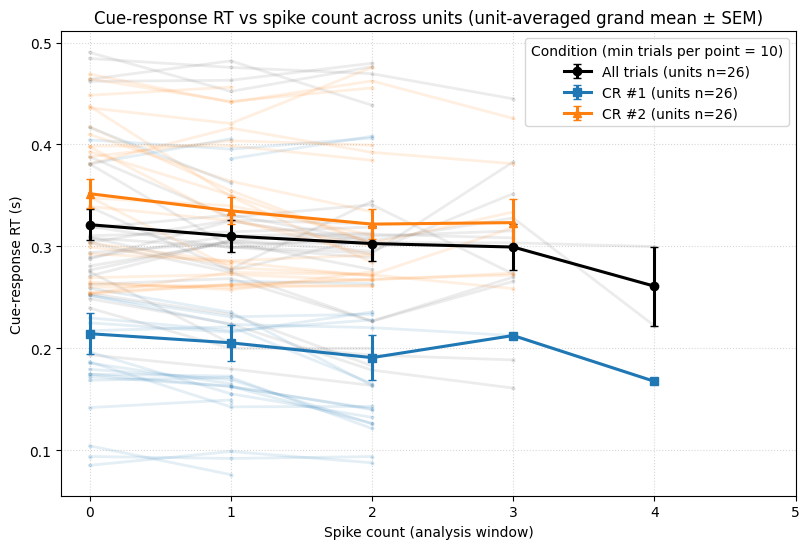

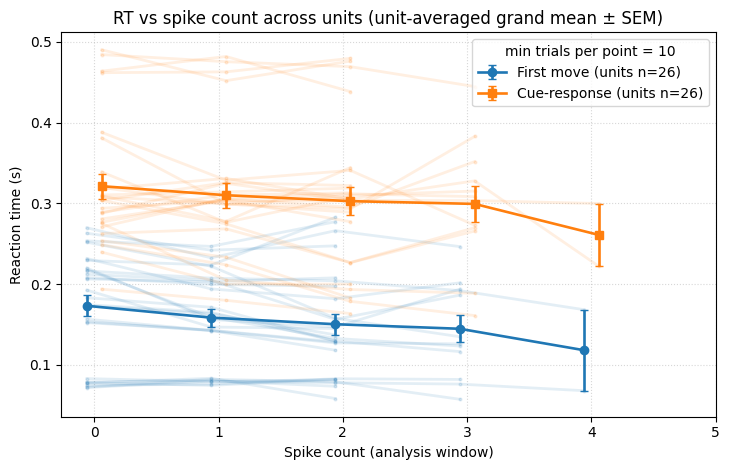

In [40]:
# Unit-averaged grand means (default cutoff = 10 trials per point)
make_cr_means_across_units_unitavg(all_counts_df, min_trials=10)
make_first_vs_cr_means_across_units_unitavg(all_counts_df, min_trials=10)


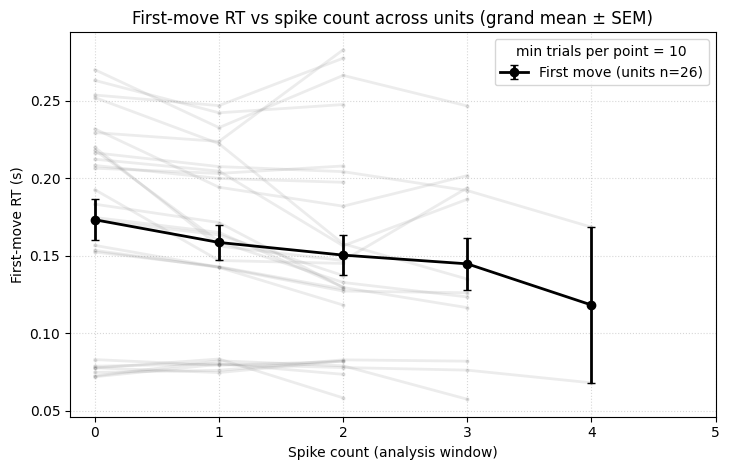

In [43]:
def make_firstmove_means_across_units_unitavg(all_counts_df: pd.DataFrame, *,
                                              min_trials: int = 10, alpha_bg: float = 0.12):
    """
    First-move RT vs spike count across units:
      - background: per-unit mean RT (transparent lines/points)
      - foreground: grand mean ± SEM over units (points with error bars)
    """
    df = _coerce_types(all_counts_df)
    d_first = df.dropna(subset=["spike_count", RT_FIRST])

    levels = union_levels(d_first)
    if not levels:
        raise ValueError("No spike_count data for first-move.")

    # Unit-averaged stats at each spike_count level
    m_f, se_f, nU_f, vec_f = unit_averaged_mean_sem(
        d_first, RT_FIRST, levels, min_trials=min_trials
    )

    fig, ax = plt.subplots(figsize=(7.4, 4.8))
    x = np.asarray(levels, dtype=float)

    # Background: per-unit trajectories (transparent)
    _plot_per_unit_vectors(ax, vec_f, levels, color="0.4", alpha=alpha_bg, lw=2, ms=2)

    # Foreground: grand mean ± SEM (over units)
    ax.errorbar(x, m_f, yerr=se_f, fmt='o-', color='black', lw=2.0, capsize=3,
                label=f"First move (units n={int(np.nanmax(nU_f))})")

    ax.set_xlabel("Spike count (analysis window)")
    ax.set_ylabel("First-move RT (s)")
    ax.set_xticks(levels); ax.set_xticklabels([str(sc) for sc in levels])
    ax.grid(True, ls=":", alpha=0.5)
    ax.legend(title=f"min trials per point = {min_trials}")
    ax.set_title("First-move RT vs spike count across units (grand mean ± SEM)")
    plt.tight_layout()
    plt.show()
    if SAVE_FIG:
        fname = FIG_DIR / "RT_firstmove_vs_spikecount_across_units_unitavg"
        FIG_DIR.mkdir(parents=True, exist_ok=True)
        fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
        fig.savefig(f"{fname}.svg", bbox_inches="tight")

make_firstmove_means_across_units_unitavg(all_counts_df, min_trials=10, alpha_bg=0.12)





In [33]:
all_counts_df.columns

Index(['trial', 'unit_id', 'session', 'align_key', 'win_start_s', 'win_stop_s',
       'spike_count', 'spike_rate_hz', 'cue_response_movement_number',
       'reaction_time_firstmove', 'reaction_time_cueresponse',
       'first_move_peak_velocity', 'first_move_mean_velocity',
       'first_move_excursion_angle_deg', 'first_move_endpoint_x',
       'first_move_endpoint_y', 'cue_response_peak_velocity',
       'cue_response_mean_velocity', 'cue_response_excursion_angle_deg',
       'cue_response_endpoint_x', 'cue_response_endpoint_y'],
      dtype='object')

In [34]:
# import matplotlib.pyplot as plt

# def plot_rt_vs_velocity(all_counts_df: pd.DataFrame):
#     # ---- collapse to per-session/trial averages ----
#     trial_means = (
#         all_counts_df
#         .groupby(["session", "trial"], as_index=False)
#         .agg({
#             "reaction_time_firstmove": "first",
#             "first_move_mean_velocity": "first",
#             "spike_count": "mean"
#         })
#     )
#     trial_means.rename(columns={"spike_count": "mean_spike_count"}, inplace=True)

#     # ---- scatter plot ----
#     plt.figure(figsize=(6, 5))
#     sc = plt.scatter(
#         trial_means["reaction_time_firstmove"],
#         trial_means["first_move_mean_velocity"],
#         c=trial_means["mean_spike_count"],
#         cmap="viridis",
#         alpha=0.5,
#         edgecolor="none",
#         linewidth=0.3,
#         s=2
#     )
#     plt.xlabel("Reaction time (s)")
#     plt.ylabel("First-move peak velocity")
#     plt.title("RT vs Peak Velocity\nColored by mean spike count")
#     plt.colorbar(sc, label="Mean spike count (per trial across units)")
#     plt.tight_layout()
#     plt.show()

# x_var = "reaction_time_firstmove"
# y_var = "first_move_mean_velocity"
# color_var = "spike_count"


# plot_rt_vs_velocity(all_counts_df,x_var,y_var,color_var)

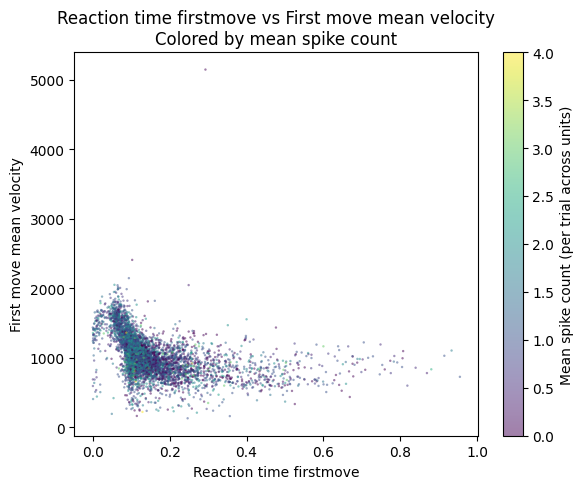

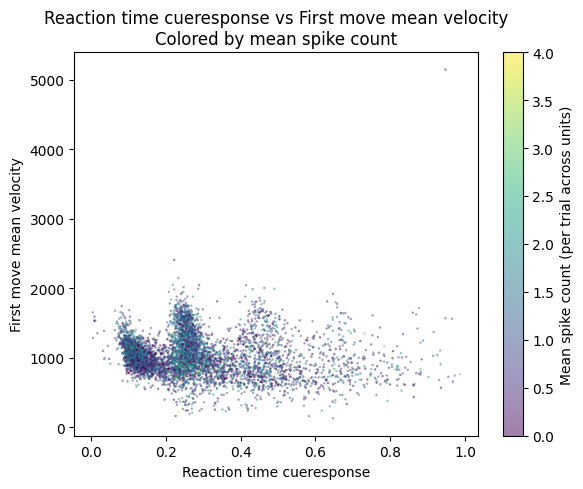

In [35]:
import matplotlib.pyplot as plt

def plot_rt_vs_velocity(all_counts_df: pd.DataFrame, x_var: str, y_var: str, color_var: str):
    # ---- collapse to per-session/trial averages ----
    trial_means = (
        all_counts_df
        .groupby(["session", "trial"], as_index=False)
        .agg({
            x_var: "mean",
            y_var: "mean",
            color_var: "mean"
        })
    )
    trial_means.rename(columns={color_var: "mean_" + color_var}, inplace=True)

    # ---- scatter plot ----
    plt.figure(figsize=(6, 5))
    sc = plt.scatter(
        trial_means[x_var],
        trial_means[y_var],
        c=trial_means["mean_" + color_var],
        cmap="viridis",
        alpha=0.5,
        edgecolor="none",
        linewidth=0.3,
        s=3
    )
    plt.xlabel(x_var.replace("_", " ").capitalize())
    plt.ylabel(y_var.replace("_", " ").capitalize())
    plt.title(f"{x_var.replace('_', ' ').capitalize()} vs {y_var.replace('_', ' ').capitalize()}\nColored by mean {color_var.replace('_', ' ')}")
    plt.colorbar(sc, label=f"Mean {color_var.replace('_', ' ')} (per trial across units)")
    # plt.ylim(0, 2000)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_rt_vs_velocity(all_counts_df, "reaction_time_firstmove", "first_move_mean_velocity", "spike_count")

plot_rt_vs_velocity(all_counts_df, "reaction_time_cueresponse", "first_move_mean_velocity", "spike_count")

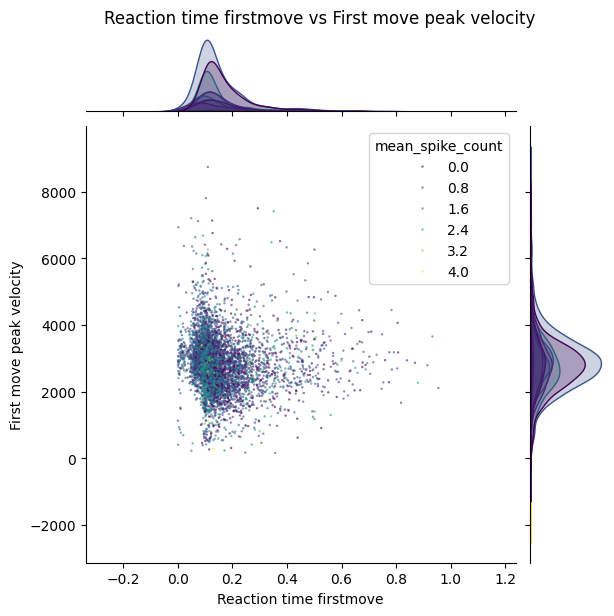

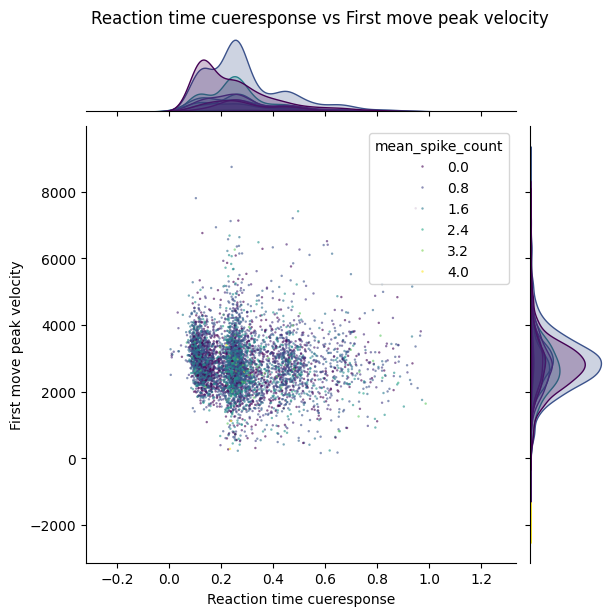

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

def jointplot_rt_vs_velocity(all_counts_df: pd.DataFrame, x_var: str, y_var: str, color_var: str):
    # ---- collapse to per-session/trial averages ----
    trial_means = (
        all_counts_df
        .groupby(["session", "trial"], as_index=False)
        .agg({
            x_var: "mean",
            y_var: "mean",
            color_var: "mean"
        })
    )
    trial_means.rename(columns={color_var: "mean_" + color_var}, inplace=True)

    # ---- jointplot ----
    jp = sns.jointplot(
        data=trial_means,
        x=x_var,
        y=y_var,
        kind="scatter",
        hue="mean_" + color_var,   # color by your chosen variable
        palette="viridis",
        alpha=0.6,
        s=3,
        edgecolor="none",
    )

    # tweak labels/titles
    jp.set_axis_labels(
        x_var.replace("_", " ").capitalize(),
        y_var.replace("_", " ").capitalize()
    )
    plt.suptitle(
        f"{x_var.replace('_', ' ').capitalize()} vs {y_var.replace('_', ' ').capitalize()}",
        y=1.02
    )
    plt.show()


jointplot_rt_vs_velocity(all_counts_df, "reaction_time_firstmove", "first_move_peak_velocity", "spike_count")
jointplot_rt_vs_velocity(all_counts_df, "reaction_time_cueresponse", "first_move_peak_velocity", "spike_count")


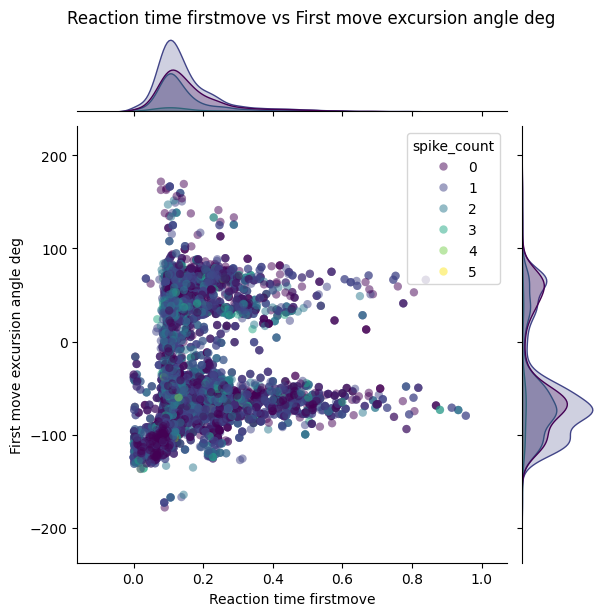

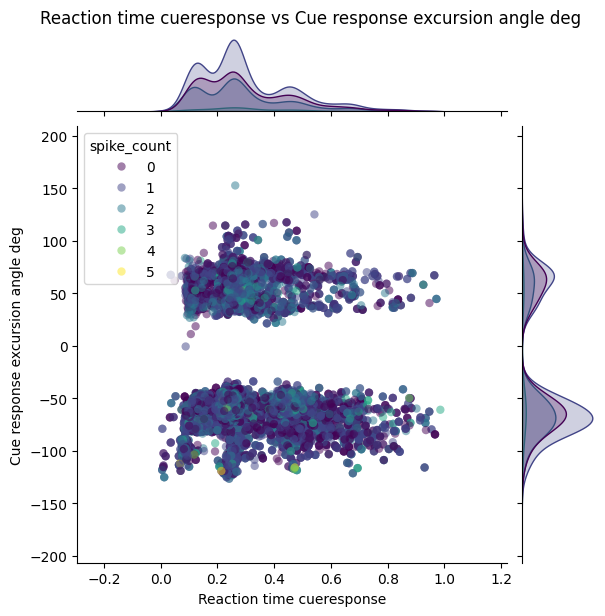

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

def jointplot_rt_vs_velocity(all_counts_df: pd.DataFrame, x_var: str, y_var: str, color_var: str):
    # ---- use raw rows ----
    df = all_counts_df[[x_var, y_var, color_var]].dropna()

    # ---- jointplot ----
    jp = sns.jointplot(
        data=df,
        x=x_var,
        y=y_var,
        kind="scatter",
        hue=color_var,     # color by your chosen variable
        palette="viridis",
        alpha=0.5,
        # s=10,
        edgecolor="none",
    )

    # tweak labels/titles
    jp.set_axis_labels(
        x_var.replace("_", " ").capitalize(),
        y_var.replace("_", " ").capitalize()
    )
    plt.suptitle(
        f"{x_var.replace('_', ' ').capitalize()} vs {y_var.replace('_', ' ').capitalize()}",
        y=1.02
    )
    plt.show()

test_df = all_counts_df[all_counts_df['unit_id']==145]
jointplot_rt_vs_velocity(all_counts_df, "reaction_time_firstmove", "first_move_excursion_angle_deg", "spike_count")
jointplot_rt_vs_velocity(all_counts_df, "reaction_time_cueresponse", "cue_response_excursion_angle_deg", "spike_count")


In [38]:
all_counts_df['unit_id'].unique()

array([ 87., 197., 377., 162.,  40., 263., 268.,   6.,  22., 195., 123.,
       145., 146.,  85.,  15.,  17.,  31.,  44.,  13., 259.,  10.,  47.,
       213.,  12.,  59.])

In [39]:
all_counts_df.columns

Index(['trial', 'unit_id', 'session', 'align_key', 'win_start_s', 'win_stop_s',
       'spike_count', 'spike_rate_hz', 'cue_response_movement_number',
       'reaction_time_firstmove', 'reaction_time_cueresponse',
       'first_move_peak_velocity', 'first_move_mean_velocity',
       'first_move_excursion_angle_deg', 'first_move_endpoint_x',
       'first_move_endpoint_y', 'cue_response_peak_velocity',
       'cue_response_mean_velocity', 'cue_response_excursion_angle_deg',
       'cue_response_endpoint_x', 'cue_response_endpoint_y'],
      dtype='object')

In [40]:
from scipy.stats import spearmanr
for var in ['reaction_time_firstmove', 'reaction_time_cueresponse',
       'first_move_peak_velocity', 'first_move_mean_velocity',
       'first_move_excursion_angle_deg', 'first_move_endpoint_x',
       'first_move_endpoint_y', 'cue_response_peak_velocity',
       'cue_response_mean_velocity', 'cue_response_excursion_angle_deg',
       'cue_response_endpoint_x', 'cue_response_endpoint_y']:
    rho, p = spearmanr(all_counts_df[var], all_counts_df["spike_count"], nan_policy="omit")
    print(var, rho, p)


reaction_time_firstmove -0.07934573628864805 7.862692183632576e-17
reaction_time_cueresponse -0.013749703748431511 0.14934349596422034
first_move_peak_velocity -0.015017444154378268 0.11530043995684587
first_move_mean_velocity 0.06313138512756178 3.43666359544866e-11
first_move_excursion_angle_deg -0.0916727416080071 5.798794875879283e-22
first_move_endpoint_x -0.04104003987929981 1.667980898765873e-05
first_move_endpoint_y -0.07750491123328566 3.9735412221754055e-16
cue_response_peak_velocity -0.006769743638111279 0.47777880741623924
cue_response_mean_velocity 0.049151067413389295 2.5084435348372315e-07
cue_response_excursion_angle_deg -0.07561962307555532 2.0087867435133986e-15
cue_response_endpoint_x 0.014675865605974375 0.1238077698414344
cue_response_endpoint_y -0.06877579884602195 5.185730392421275e-13


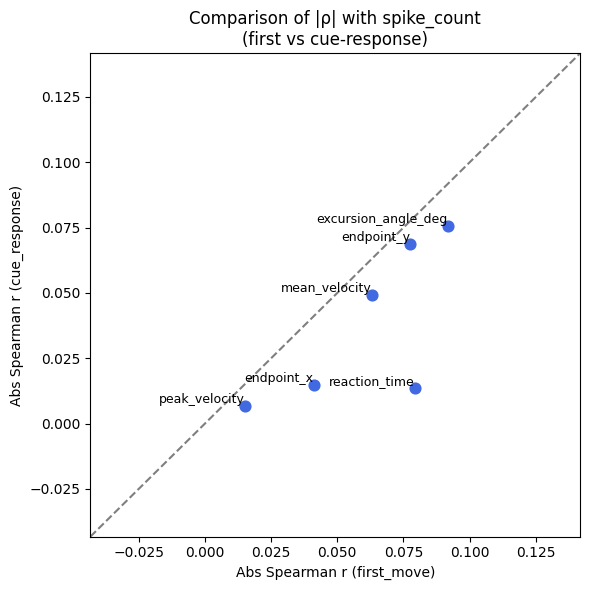

kind                 cue_response  first_move
var                                          
endpoint_x               0.014676    0.041040
endpoint_y               0.068776    0.077505
excursion_angle_deg      0.075620    0.091673
mean_velocity            0.049151    0.063131
peak_velocity            0.006770    0.015017
reaction_time            0.013750    0.079346


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

def compare_spearman_pairs(all_counts_df: pd.DataFrame, absolute: bool = True):
    # define base names without prefix
    bases = [
        "peak_velocity",
        "mean_velocity",
        "excursion_angle_deg",
        "endpoint_x",
        "endpoint_y",
        "reaction_time",
    ]

    records = []
    for base in bases:
        fm_col = f"first_move_{base}" if base != "reaction_time" else "reaction_time_firstmove"
        cr_col = f"cue_response_{base}" if base != "reaction_time" else "reaction_time_cueresponse"

        for prefix, col in [("first_move", fm_col), ("cue_response", cr_col)]:
            if col not in all_counts_df.columns:
                continue
            rho, p = spearmanr(all_counts_df[col], all_counts_df["spike_count"], nan_policy="omit")
            if absolute:
                rho = abs(rho)
            records.append(dict(var=base, kind=prefix, rho=rho, pval=p))

    corr_df = pd.DataFrame(records).pivot(index="var", columns="kind", values="rho")

    # ---- paired plot ----
    plt.figure(figsize=(6, 6))
    plt.scatter(corr_df["first_move"], corr_df["cue_response"], s=60, c="royalblue")
    for var, row in corr_df.iterrows():
        plt.text(row["first_move"], row["cue_response"], var, fontsize=9,
                 ha="right", va="bottom")

    lims = [
        min(corr_df.min()) - 0.05,
        max(corr_df.max()) + 0.05,
    ]
    plt.plot(lims, lims, "k--", alpha=0.5)
    plt.xlim(lims)
    plt.ylim(lims)
    plt.xlabel("Abs Spearman r (first_move)")
    plt.ylabel("Abs Spearman r (cue_response)")
    plt.title("Comparison of |ρ| with spike_count\n(first vs cue-response)")
    plt.tight_layout()
    plt.show()

    return corr_df

# Example usage:
corr_df = compare_spearman_pairs(all_counts_df, absolute=True)
print(corr_df)


In [42]:
import statsmodels.api as sm

X = all_counts_df[[
    "reaction_time_firstmove",
    "first_move_peak_velocity",
    "first_move_mean_velocity",
    "first_move_excursion_angle_deg"
]].dropna()   # or dropna
y = all_counts_df["spike_count"]

# Force all columns to native float64
X = X.astype('float64')   # convert entire DataFrame to float64
y = all_counts_df["spike_count"].astype('float64')

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            spike_count   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     33.85
Date:                Mon, 06 Oct 2025   Prob (F-statistic):           4.08e-28
Time:                        15:47:09   Log-Likelihood:                -13483.
No. Observations:               10998   AIC:                         2.698e+04
Df Residuals:                   10993   BIC:                         2.701e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [43]:
import statsmodels.api as sm

X = all_counts_df[[
    "reaction_time_cueresponse",
    "cue_response_peak_velocity",
    "cue_response_mean_velocity",
    "cue_response_excursion_angle_deg"
]].dropna()   # or dropna
y = all_counts_df["spike_count"]

# Force all columns to native float64
X = X.astype('float64')   # convert entire DataFrame to float64
y = all_counts_df["spike_count"].astype('float64')

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            spike_count   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     19.70
Date:                Mon, 06 Oct 2025   Prob (F-statistic):           3.56e-16
Time:                        15:47:09   Log-Likelihood:                -13511.
No. Observations:               10998   AIC:                         2.703e+04
Df Residuals:                   10993   BIC:                         2.707e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [44]:
import statsmodels.formula.api as smf
model = smf.mixedlm(
    "spike_count ~ reaction_time_firstmove + first_move_mean_velocity + first_move_excursion_angle_deg",
    data=all_counts_df,
    groups=all_counts_df["unit_id"]
).fit()
print(model.summary())


                  Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      spike_count
No. Observations:       10998        Method:                  REML       
No. Groups:             25           Scale:                   0.5524     
Min. group size:        199          Log-Likelihood:          -12417.8683
Max. group size:        742          Converged:               Yes        
Mean group size:        439.9                                            
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       1.012    0.082 12.341 0.000  0.851  1.173
reaction_time_firstmove        -0.374    0.073 -5.136 0.000 -0.517 -0.231
first_move_mean_velocity        0.000    0.000  0.311 0.756 -0.000  0.000
first_move_excursion_angle_deg -0.001    0.000 -3.662 0.

In [45]:
model = smf.glm(
    "spike_count ~ reaction_time_firstmove + first_move_mean_velocity + first_move_excursion_angle_deg",
    data=all_counts_df,
    family=sm.families.Poisson()
).fit()
print(model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:            spike_count   No. Observations:                10998
Model:                            GLM   Df Residuals:                    10994
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13407.
Date:                Mon, 06 Oct 2025   Deviance:                       9491.2
Time:                        15:47:10   Pearson chi2:                 7.56e+03
No. Iterations:                     5   Pseudo R-squ. (CS):           0.007581
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [46]:
import numpy as np

mean_count = all_counts_df["spike_count"].mean()
var_count = all_counts_df["spike_count"].var()

print("Mean:", mean_count)
print("Variance:", var_count)
print("Var/Mean ratio:", var_count / mean_count)


Mean: 0.9969085288234224
Variance: 0.6881781294880418
Var/Mean ratio: 0.6903122097874392


In [47]:
import pandas as pd

# Frequency table of spike counts
count_dist = all_counts_df["spike_count"].value_counts().sort_index()

print(count_dist)

# Relative frequencies
print(count_dist / count_dist.sum())


spike_count
0    3273
1    4947
2    2376
3     351
4      43
5       8
Name: count, dtype: int64
spike_count
0    0.297600
1    0.449809
2    0.216039
3    0.031915
4    0.003910
5    0.000727
Name: count, dtype: float64


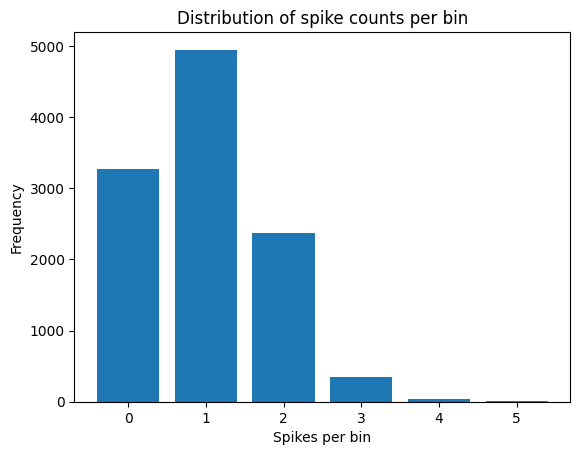

In [48]:
import matplotlib.pyplot as plt

plt.bar(count_dist.index, count_dist.values)
plt.xlabel("Spikes per bin")
plt.ylabel("Frequency")
plt.title("Distribution of spike counts per bin")
plt.show()


In [49]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Treat spike_count as categorical (factor)
model = smf.ols("reaction_time_firstmove ~ C(spike_count)", data=all_counts_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)
print("η² =", anova_table["sum_sq"]["C(spike_count)"] / anova_table["sum_sq"].sum())


                    sum_sq       df         F        PR(>F)
C(spike_count)    0.559298      5.0  8.687753  3.124811e-08
Residual        141.528078  10992.0       NaN           NaN
η² = 0.003936297258228769


In [50]:
all_counts_df.columns

Index(['trial', 'unit_id', 'session', 'align_key', 'win_start_s', 'win_stop_s',
       'spike_count', 'spike_rate_hz', 'cue_response_movement_number',
       'reaction_time_firstmove', 'reaction_time_cueresponse',
       'first_move_peak_velocity', 'first_move_mean_velocity',
       'first_move_excursion_angle_deg', 'first_move_endpoint_x',
       'first_move_endpoint_y', 'cue_response_peak_velocity',
       'cue_response_mean_velocity', 'cue_response_excursion_angle_deg',
       'cue_response_endpoint_x', 'cue_response_endpoint_y'],
      dtype='object')

In [51]:
# Re-defining the helper in the current Python session (the execution state was reset).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from typing import List, Tuple
from math import sqrt
from patsy import build_design_matrices

def _drop_and_cast(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    sub = df.dropna(subset=cols + ["spike_count","unit_id"]).copy()
    for c in cols + ["spike_count"]:
        sub[c] = pd.to_numeric(sub[c], errors="coerce")
    sub = sub.dropna(subset=cols + ["spike_count"])
    return sub

def _glm_poisson(df: pd.DataFrame, predictors: List[str]):
    formula = "spike_count ~ " + " + ".join(predictors)
    model = smf.glm(formula, data=df, family=sm.families.Poisson())
    fit = model.fit()
    llnull = fit.llnull
    llf = fit.llf
    r2 = 1 - (llf / llnull) if llnull != 0 else np.nan
    return fit, r2

def _ols_linear(df: pd.DataFrame, predictors: List[str]):
    formula = "spike_count ~ " + " + ".join(predictors)
    fit = smf.ols(formula, data=df).fit()
    return fit, fit.rsquared

def _lme_gaussian(df: pd.DataFrame, predictors: List[str]) -> Tuple[object, float, float]:
    formula = "spike_count ~ " + " + ".join(predictors)
    model = smf.mixedlm(formula, data=df, groups=df["unit_id"])
    fit = model.fit()
    sigma_u2 = float(fit.cov_re.iloc[0,0]) if hasattr(fit, "cov_re") else np.nan
    sigma_e2 = float(fit.scale) if hasattr(fit, "scale") else np.nan
    X = fit.model.exog
    beta = fit.fe_params.values
    lin_fixed = X @ beta
    var_fixed = float(np.var(lin_fixed))
    denom = var_fixed + (sigma_u2 if np.isfinite(sigma_u2) else 0.0) + (sigma_e2 if np.isfinite(sigma_e2) else 0.0)
    r2_marginal = var_fixed / denom if denom > 0 else np.nan
    r2_conditional = (var_fixed + (sigma_u2 if np.isfinite(sigma_u2) else 0.0)) / denom if denom > 0 else np.nan
    return fit, r2_marginal, r2_conditional

def _per_unit_r2(df: pd.DataFrame, predictors: List[str], min_n: int = 20, use_linear: bool = False) -> pd.DataFrame:
    rows = []
    for unit, d in df.groupby("unit_id"):
        d = d.dropna(subset=predictors + ["spike_count"])
        if len(d) < min_n:
            continue
        if d["spike_count"].nunique() < 2:
            continue
        if sum(d[p].nunique() > 1 for p in predictors) == 0:
            continue
        try:
            if use_linear:
                _, r2 = _ols_linear(d, predictors)
            else:
                _, r2 = _glm_poisson(d, predictors)
            if np.isfinite(r2):
                rows.append({"unit_id": unit, "r2": float(r2), "n": len(d)})
        except Exception:
            continue
    return pd.DataFrame(rows)

def _bar_population_r2(ax, glm_r2: float, r2_marg: float, r2_cond: float, title: str):
    labels = ["GLM\n(McFadden)", "LME\nMarginal", "LME\nConditional"]
    values = [glm_r2, r2_marg, r2_cond]
    x = np.arange(len(labels))
    ax.bar(x, values)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(0, 1)
    ax.set_ylabel("Explained variance (pseudo-R² / R²)")
    ax.set_title(title)
    for xi, v in zip(x, values):
        if np.isfinite(v):
            ax.text(xi, v + 0.02, f"{v:.2f}", ha="center", va="bottom")

def run_variance_explained(df: pd.DataFrame, predictors: List[str], title: str = "", min_n_per_unit: int = 20, use_linear: bool = False):
    sub = _drop_and_cast(df, predictors)
    if sub.empty:
        print("No usable rows after dropping NaNs.")
        return
    per_unit = _per_unit_r2(sub, predictors, min_n=min_n_per_unit, use_linear=use_linear)
    if per_unit.empty:
        print("No units passed quality filters for per-unit R².")
    else:
        plt.figure(figsize=(8,5))
        plt.hist(per_unit["r2"], bins=20)
        plt.xlabel("Per-unit explained variance (R²)")
        plt.ylabel("Count of units")
        tt = f"Per-unit {'Linear' if use_linear else 'Poisson'} R² — " + (title if title else "")
        plt.title(tt)
        med = float(np.nanmedian(per_unit['r2']))
        ylim = plt.ylim()
        plt.axvline(med, linestyle="--")
        plt.text(med, ylim[1]*0.9, "median", ha="left", va="center")
        plt.tight_layout()
        plt.show()
    glm_fit, glm_r2 = _glm_poisson(sub, predictors) if not use_linear else _ols_linear(sub, predictors)
    lme_fit, r2_marg, r2_cond = _lme_gaussian(sub, predictors)
    fig, ax = plt.subplots(figsize=(7,5))
    _bar_population_r2(ax, float(glm_r2), float(r2_marg), float(r2_cond), title=f"Population explained variance — {title}")
    plt.tight_layout()
    plt.show()
    summary = pd.DataFrame({
        "metric": ["per_unit_median", "per_unit_mean", "GLM_pseudoR2" if not use_linear else "OLS_R2", "LME_marginalR2", "LME_conditionalR2"],
        "value": [
            np.nanmedian(per_unit["r2"]) if not per_unit.empty else np.nan,
            np.nanmean(per_unit["r2"]) if not per_unit.empty else np.nan,
            glm_r2,
            r2_marg,
            r2_cond
        ]
    })
    try:
        from caas_jupyter_tools import display_dataframe_to_user
        display_dataframe_to_user("Variance explained summary", summary)
    except Exception:
        print(summary)

print("Loaded: run_variance_explained(df, predictors, title='...', use_linear=False).")


Loaded: run_variance_explained(df, predictors, title='...', use_linear=False).


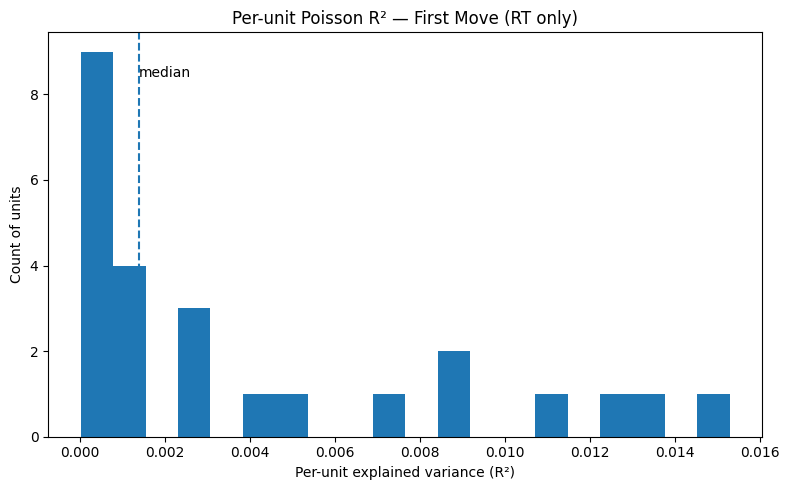

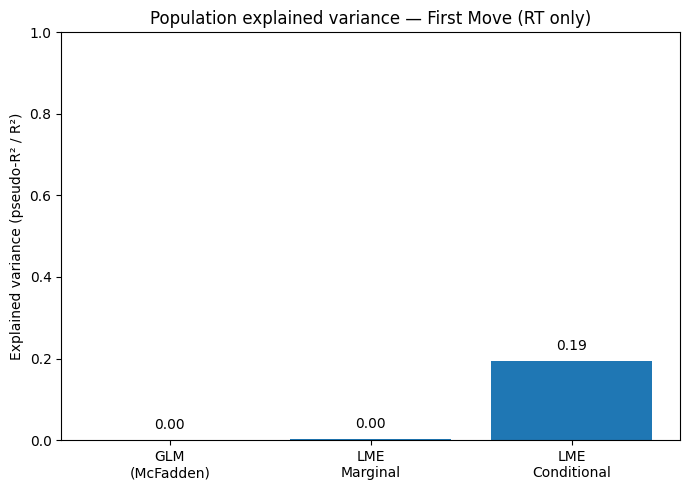

              metric     value
0    per_unit_median  0.001384
1      per_unit_mean  0.004019
2       GLM_pseudoR2  0.000916
3     LME_marginalR2  0.003144
4  LME_conditionalR2  0.194594


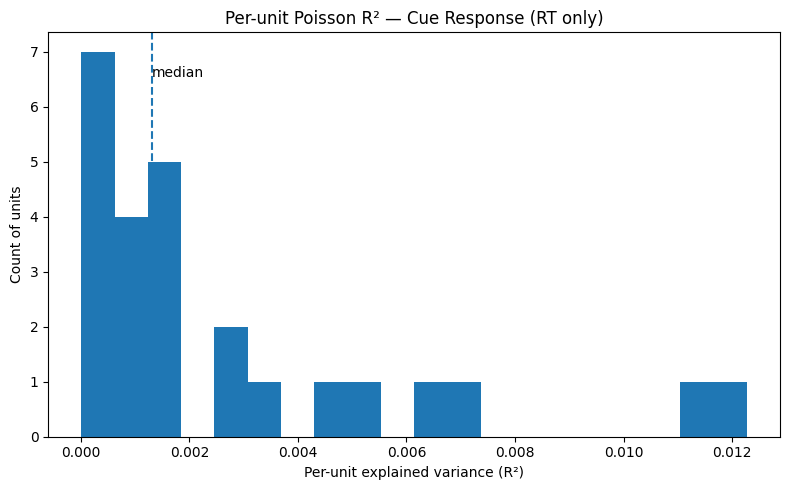

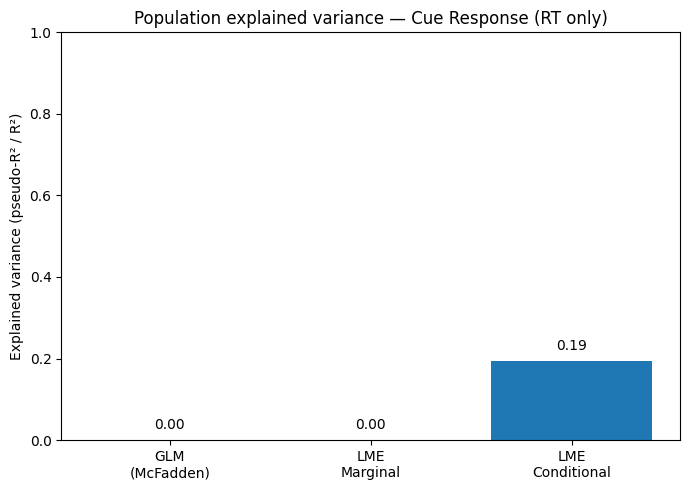

              metric     value
0    per_unit_median  0.001311
1      per_unit_mean  0.002718
2       GLM_pseudoR2  0.000030
3     LME_marginalR2  0.000734
4  LME_conditionalR2  0.192889


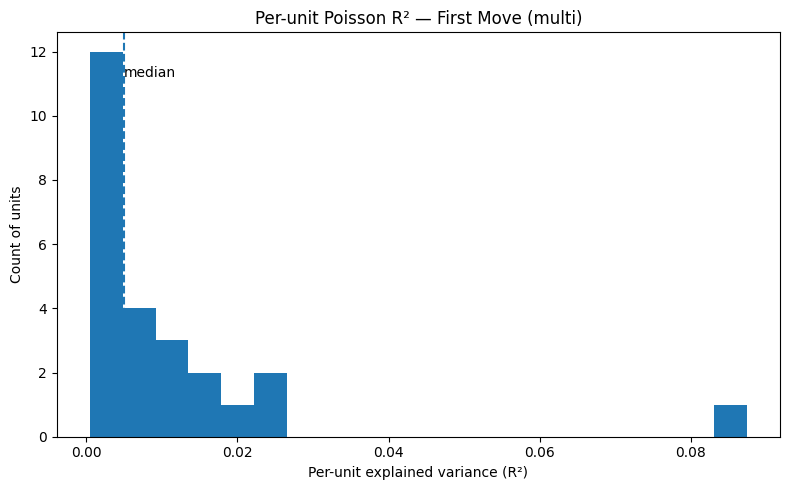

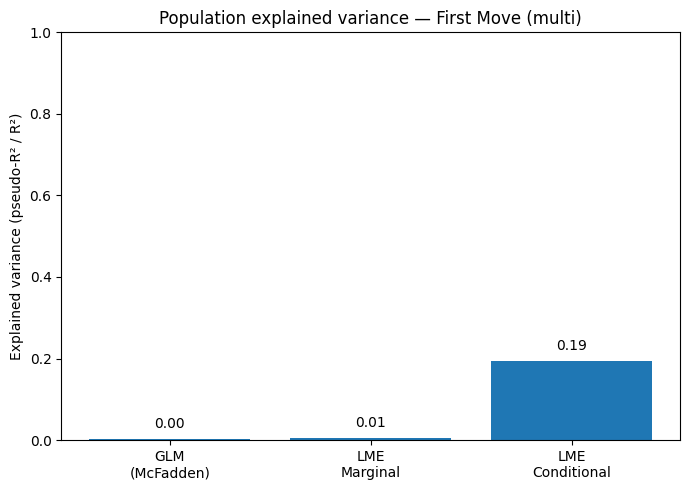

              metric     value
0    per_unit_median  0.004973
1      per_unit_mean  0.010912
2       GLM_pseudoR2  0.003111
3     LME_marginalR2  0.005252
4  LME_conditionalR2  0.194028


In [52]:
# First-move RT only
run_variance_explained(all_counts_df, ["reaction_time_firstmove"], title="First Move (RT only)")

# Cue-response RT only
run_variance_explained(all_counts_df, ["reaction_time_cueresponse"], title="Cue Response (RT only)")

# If you want to include more kinematics later:
fm_multi = ["reaction_time_firstmove","first_move_mean_velocity","first_move_excursion_angle_deg"]
run_variance_explained(all_counts_df, fm_multi, title="First Move (multi)")


In [53]:
# Re-load the standardized effects plotting function in the current session.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from typing import List, Tuple

def _zscore_columns(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    out = df.copy()
    for c in cols:
        mu = np.nanmean(out[c])
        sd = np.nanstd(out[c], ddof=1)
        if not np.isfinite(sd) or sd == 0:
            out[c + "_z"] = np.nan
        else:
            out[c + "_z"] = (out[c] - mu) / sd
    return out

def _glm_poisson_z(df: pd.DataFrame, zcols: List[str]):
    formula = "spike_count ~ " + " + ".join(zcols)
    fit = smf.glm(formula, data=df, family=sm.families.Poisson()).fit()
    return fit

def _lme_gaussian_z(df: pd.DataFrame, zcols: List[str]):
    formula = "spike_count ~ " + " + ".join(zcols)
    fit = smf.mixedlm(formula, data=df, groups=df["unit_id"]).fit()
    return fit

def _wald_ci(beta: float, se: float, z=1.96) -> tuple:
    return beta - z*se, beta + z*se

def plot_standardized_effects(df: pd.DataFrame, predictors: List[str], title: str = ""):
    sub = df.dropna(subset=predictors + ["spike_count","unit_id"]).copy()
    sub = _zscore_columns(sub, predictors)
    zcols = [p + "_z" for p in predictors]
    sub = sub.dropna(subset=zcols + ["spike_count","unit_id"])

    if sub.empty:
        print("No usable data after z-scoring and dropping NaNs.")
        return

    glm_fit = _glm_poisson_z(sub, zcols)
    lme_fit = _lme_gaussian_z(sub, zcols)

    rows = []
    ybar = float(np.mean(sub["spike_count"]))
    for p, zc in zip(predictors, zcols):
        b_glm = float(glm_fit.params.get(zc, np.nan))
        se_glm = float(glm_fit.bse.get(zc, np.nan))
        lo_glm, hi_glm = _wald_ci(b_glm, se_glm)
        pct_glm = (np.exp(b_glm) - 1.0) * 100.0
        pct_lo  = (np.exp(lo_glm) - 1.0) * 100.0
        pct_hi  = (np.exp(hi_glm) - 1.0) * 100.0

        b_lme = float(lme_fit.fe_params.get(zc, np.nan))
        se_lme = float(lme_fit.bse.get(zc, np.nan))
        lo_lme, hi_lme = _wald_ci(b_lme, se_lme)
        pct_of_mean = (b_lme / ybar) * 100.0 if ybar != 0 else np.nan
        pct_of_mean_lo = (lo_lme / ybar) * 100.0 if ybar != 0 else np.nan
        pct_of_mean_hi = (hi_lme / ybar) * 100.0 if ybar != 0 else np.nan

        rows.append({
            "predictor": p,
            "glm_pct_per_SD": pct_glm,
            "glm_pct_lo": pct_lo,
            "glm_pct_hi": pct_hi,
            "lme_delta_per_SD": b_lme,
            "lme_delta_lo": lo_lme,
            "lme_delta_hi": hi_lme,
            "lme_pct_of_mean": pct_of_mean,
            "lme_pct_of_mean_lo": pct_of_mean_lo,
            "lme_pct_of_mean_hi": pct_of_mean_hi
        })

    eff = pd.DataFrame(rows)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    fig.suptitle(title if title else "Standardized effect sizes (per +1 SD)", fontsize=14, fontweight="bold")

    # GLM % change per SD
    ax = axes[0]
    y = np.arange(len(eff))
    ax.errorbar(eff["glm_pct_per_SD"], y,
                xerr=[eff["glm_pct_per_SD"]-eff["glm_pct_lo"], eff["glm_pct_hi"]-eff["glm_pct_per_SD"]],
                fmt='o', capsize=4)
    ax.axvline(0, linewidth=1, linestyle="--")
    ax.set_xlabel("% change in expected count per +1 SD (Poisson GLM)")
    ax.set_yticks(y)
    ax.set_yticklabels(eff["predictor"])

    # LME delta + % of mean (secondary axis)
    ax2 = axes[1]
    ax2.errorbar(eff["lme_delta_per_SD"], y,
                 xerr=[eff["lme_delta_per_SD"]-eff["lme_delta_lo"], eff["lme_delta_hi"]-eff["lme_delta_per_SD"]],
                 fmt='o', capsize=4)
    ax2.axvline(0, linewidth=1, linestyle="--")
    ax2.set_xlabel("Δ spikes per +1 SD (Gaussian LME)")

    ax3 = ax2.twiny()
    ticks = ax2.get_xticks()
    ybar_safe = ybar if ybar != 0 else 1.0
    pct_ticks = (ticks / ybar_safe) * 100.0
    ax3.set_xticks(ticks)
    ax3.set_xbound(ax2.get_xbound())
    ax3.set_xlabel("% of mean spikes per +1 SD (approx)")
    ax3.set_xticklabels([f"{t:.0f}%" for t in pct_ticks])

    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()

    try:
        from caas_jupyter_tools import display_dataframe_to_user
        display_dataframe_to_user("Standardized effects (per +1 SD)", eff)
    except Exception:
        print(eff)

print("Loaded: plot_standardized_effects(df, predictors, title='...').")


Loaded: plot_standardized_effects(df, predictors, title='...').


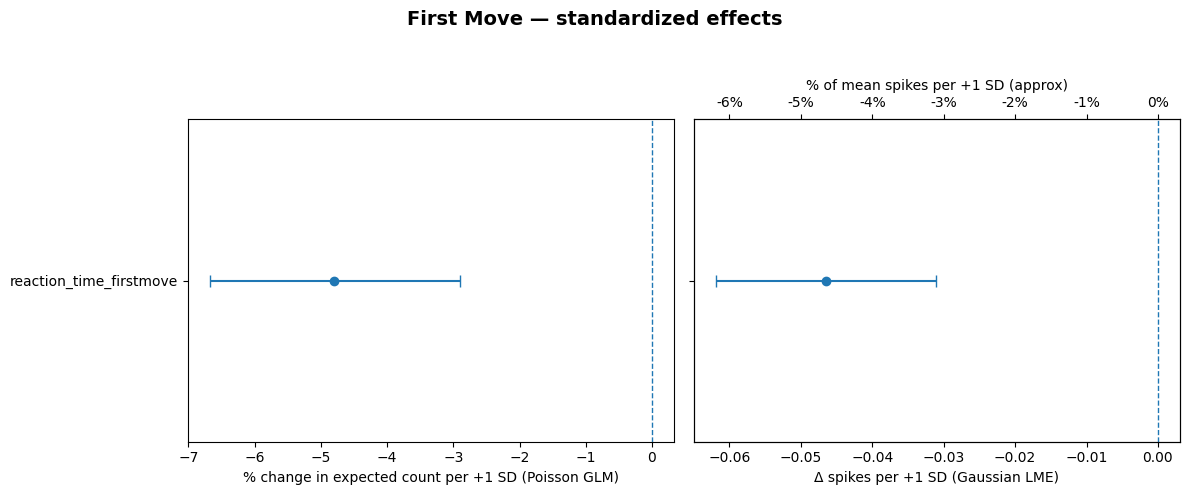

                 predictor  glm_pct_per_SD  glm_pct_lo  glm_pct_hi  \
0  reaction_time_firstmove       -4.805522   -6.673638   -2.900011   

   lme_delta_per_SD  lme_delta_lo  lme_delta_hi  lme_pct_of_mean  \
0         -0.046466     -0.061886     -0.031046        -4.660996   

   lme_pct_of_mean_lo  lme_pct_of_mean_hi  
0           -6.207773           -3.114219  


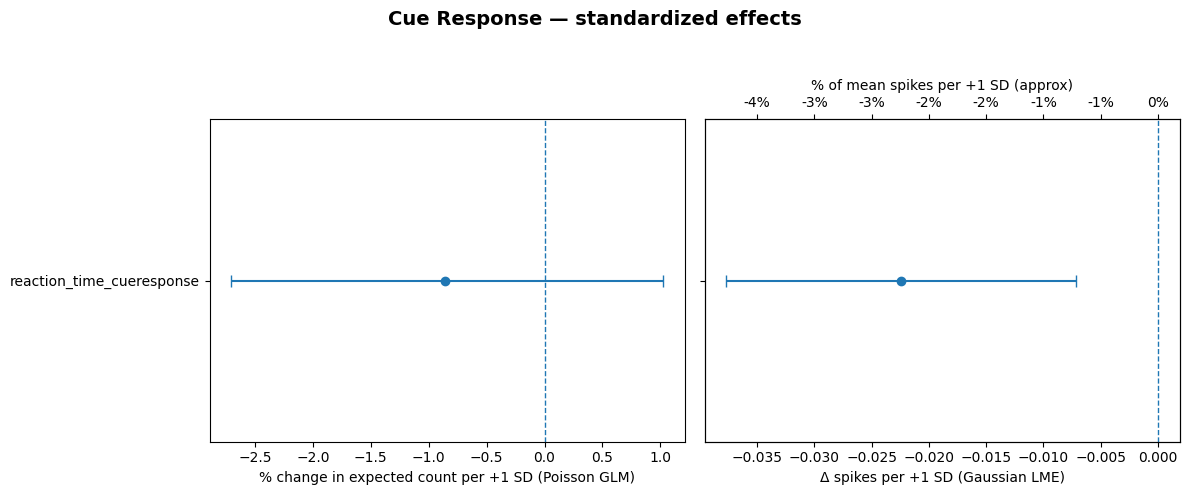

                   predictor  glm_pct_per_SD  glm_pct_lo  glm_pct_hi  \
0  reaction_time_cueresponse       -0.857919   -2.705115    1.024347   

   lme_delta_per_SD  lme_delta_lo  lme_delta_hi  lme_pct_of_mean  \
0         -0.022451      -0.03771     -0.007192        -2.252042   

   lme_pct_of_mean_lo  lme_pct_of_mean_hi  
0           -3.782655            -0.72143  


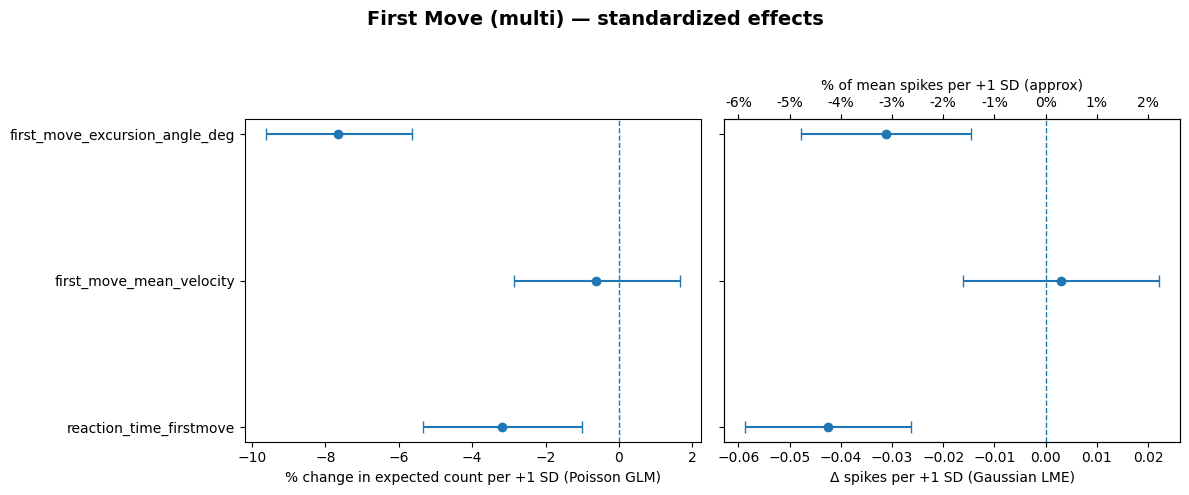

                        predictor  glm_pct_per_SD  glm_pct_lo  glm_pct_hi  \
0         reaction_time_firstmove       -3.191950   -5.334408   -1.001005   
1        first_move_mean_velocity       -0.621584   -2.866982    1.675720   
2  first_move_excursion_angle_deg       -7.650376   -9.620732   -5.637064   

   lme_delta_per_SD  lme_delta_lo  lme_delta_hi  lme_pct_of_mean  \
0         -0.042535     -0.058768     -0.026302        -4.266704   
1          0.003043     -0.016115      0.022201         0.305230   
2         -0.031153     -0.047826     -0.014481        -3.124970   

   lme_pct_of_mean_lo  lme_pct_of_mean_hi  
0           -5.895049           -2.638359  
1           -1.616499            2.226959  
2           -4.797388           -1.452552  


In [54]:
# One predictor
plot_standardized_effects(all_counts_df, ["reaction_time_firstmove"], title="First Move — standardized effects")
plot_standardized_effects(all_counts_df, ["reaction_time_cueresponse"], title="Cue Response — standardized effects")

# Multiple predictors
plot_standardized_effects(
    all_counts_df,
    ["reaction_time_firstmove","first_move_mean_velocity","first_move_excursion_angle_deg"],
    title="First Move (multi) — standardized effects"
)


In [55]:
# Robust per-unit standardized-effects plotting (fixed)
# - Works for 1 or multiple predictors.
# - Uses Poisson GLM with correct family import (sm.families.Poisson).
# - Z-scores predictors WITHIN UNIT to get "per +1 SD (within-unit)" effects.
# - Returns the results DataFrame and produces a forest-style plot (one panel per predictor).
#
# Usage examples after running this cell:
#   per_unit = per_unit_standardized_effects(all_counts_df, ["reaction_time_firstmove"], min_trials=50)
#   plot_per_unit_effects(per_unit, title="Per-unit standardized effects — First Move RT")
#
#   per_unit_multi = per_unit_standardized_effects(
#       all_counts_df,
#       ["reaction_time_firstmove","first_move_mean_velocity","first_move_excursion_angle_deg"],
#       min_trials=50
#   )
#   plot_per_unit_effects(per_unit_multi, title="Per-unit standardized effects — First Move (multi)")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from typing import List

def _zscore_within_unit(d: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    """Z-score columns within the current unit group."""
    out = d.copy()
    for c in cols:
        mu = np.nanmean(out[c])
        sd = np.nanstd(out[c], ddof=1)
        out[c + "_z"] = (out[c] - mu) / sd if (np.isfinite(sd) and sd != 0) else np.nan
    return out

def per_unit_standardized_effects(df: pd.DataFrame, predictors: List[str], min_trials: int = 50) -> pd.DataFrame:
    rows = []
    needed = predictors + ["spike_count", "unit_id"]
    df_ = df.dropna(subset=needed).copy()

    for unit, d in df_.groupby("unit_id"):
        if len(d) < min_trials or d["spike_count"].nunique() < 2:
            continue
        d = _zscore_within_unit(d, predictors)
        zcols = [p + "_z" for p in predictors]
        if any(d[z].isna().all() for z in zcols):
            continue  # skip if a predictor has zero variance within this unit
        d = d.dropna(subset=zcols + ["spike_count"])

        # Build formula: spike_count ~ z1 + z2 + ...
        formula = "spike_count ~ " + " + ".join(zcols)
        try:
            fit = smf.glm(formula, data=d, family=sm.families.Poisson()).fit()
            for p, zc in zip(predictors, zcols):
                if zc in fit.params.index:
                    beta = float(fit.params[zc])
                    se = float(fit.bse[zc])
                    lo, hi = beta - 1.96*se, beta + 1.96*se
                    # % change in expected count per +1 SD (within-unit)
                    pct = (np.exp(beta) - 1) * 100.0
                    pct_lo = (np.exp(lo) - 1) * 100.0
                    pct_hi = (np.exp(hi) - 1) * 100.0
                    rows.append({
                        "unit_id": unit,
                        "predictor": p,
                        "beta": beta,
                        "se": se,
                        "pct_per_SD": pct,
                        "pct_lo": pct_lo,
                        "pct_hi": pct_hi,
                        "n": len(d)
                    })
        except Exception as e:
            # Skip units that fail to fit
            continue

    res = pd.DataFrame(rows)
    return res.sort_values(["predictor", "pct_per_SD"]).reset_index(drop=True)


def plot_per_unit_effects(per_unit_df: pd.DataFrame, title: str = ""):
    if per_unit_df.empty:
        print("No per-unit results to plot.")
        return

    predictors = per_unit_df["predictor"].unique()
    n_pred = len(predictors)
    ncols = min(2, n_pred)
    nrows = int(np.ceil(n_pred / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(7*ncols, 0.35*len(per_unit_df["unit_id"].unique()) + 3),
                             squeeze=False, sharex=False)
    fig.suptitle(title if title else "Per-unit standardized effects (Poisson GLM, within-unit z-score)",
                 fontsize=14, fontweight="bold")

    for i, pred in enumerate(predictors):
        ax = axes[i // ncols, i % ncols]
        sub = per_unit_df[per_unit_df["predictor"] == pred].copy()

        # Sort by effect size for a clean forest plot
        sub = sub.sort_values("pct_per_SD").reset_index(drop=True)
        y = np.arange(len(sub))

        # Error bars: % change per SD with 95% CI
        x = sub["pct_per_SD"].to_numpy()
        xerr = np.vstack([x - sub["pct_lo"].to_numpy(), sub["pct_hi"].to_numpy() - x])

        ax.errorbar(x, y, xerr=xerr, fmt="o", capsize=3)
        ax.axvline(0, color="k", linestyle="--", linewidth=1)
        ax.set_yticks(y)
        # Label each row by "unit_id (n)"
        ax.set_yticklabels([f"{u} (n={n})" for u, n in zip(sub["unit_id"], sub["n"])])
        ax.set_xlabel("% change in expected spike count per +1 SD")
        ax.set_title(pred)
        ax.grid(True, axis="x", alpha=0.2)

    # Remove empty subplots if any
    total_axes = nrows * ncols
    for j in range(i+1, total_axes):
        fig.delaxes(axes[j // ncols, j % ncols])

    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()

print("Loaded: per_unit_standardized_effects(...), plot_per_unit_effects(...).")


Loaded: per_unit_standardized_effects(...), plot_per_unit_effects(...).


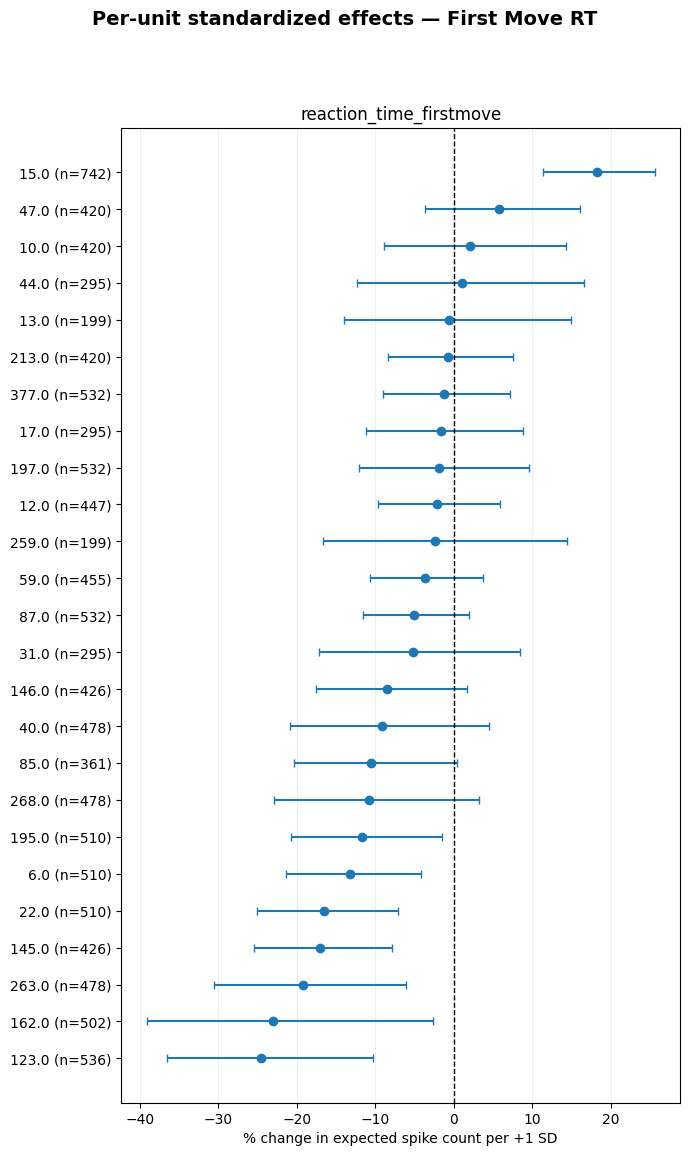

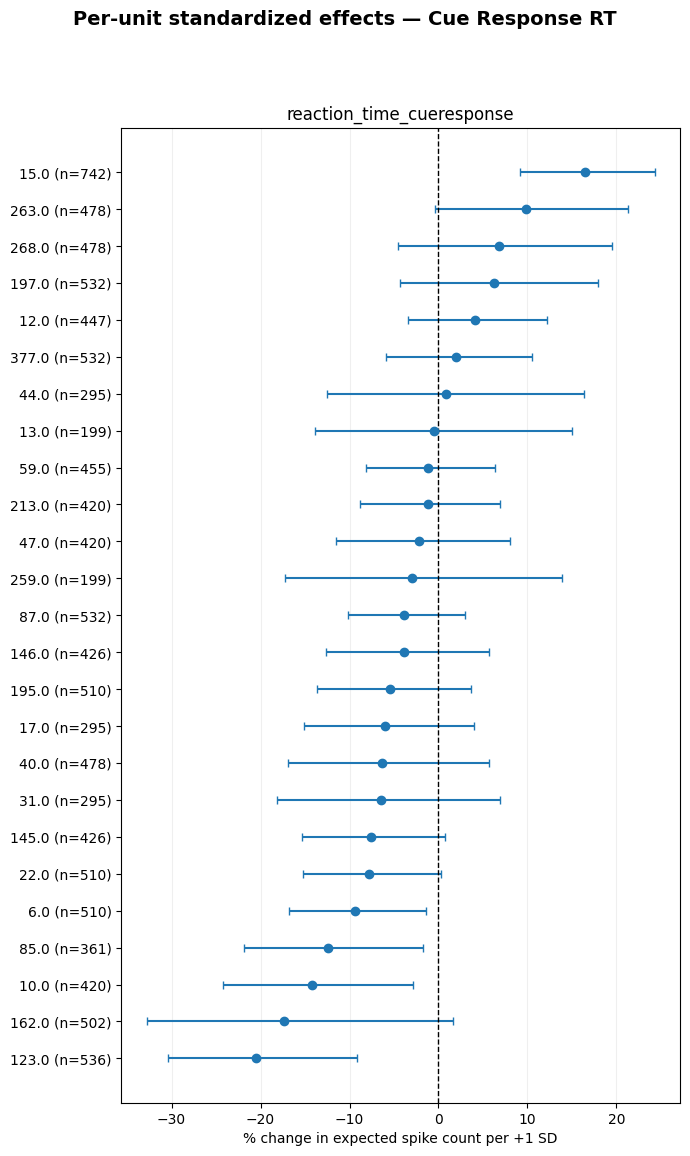

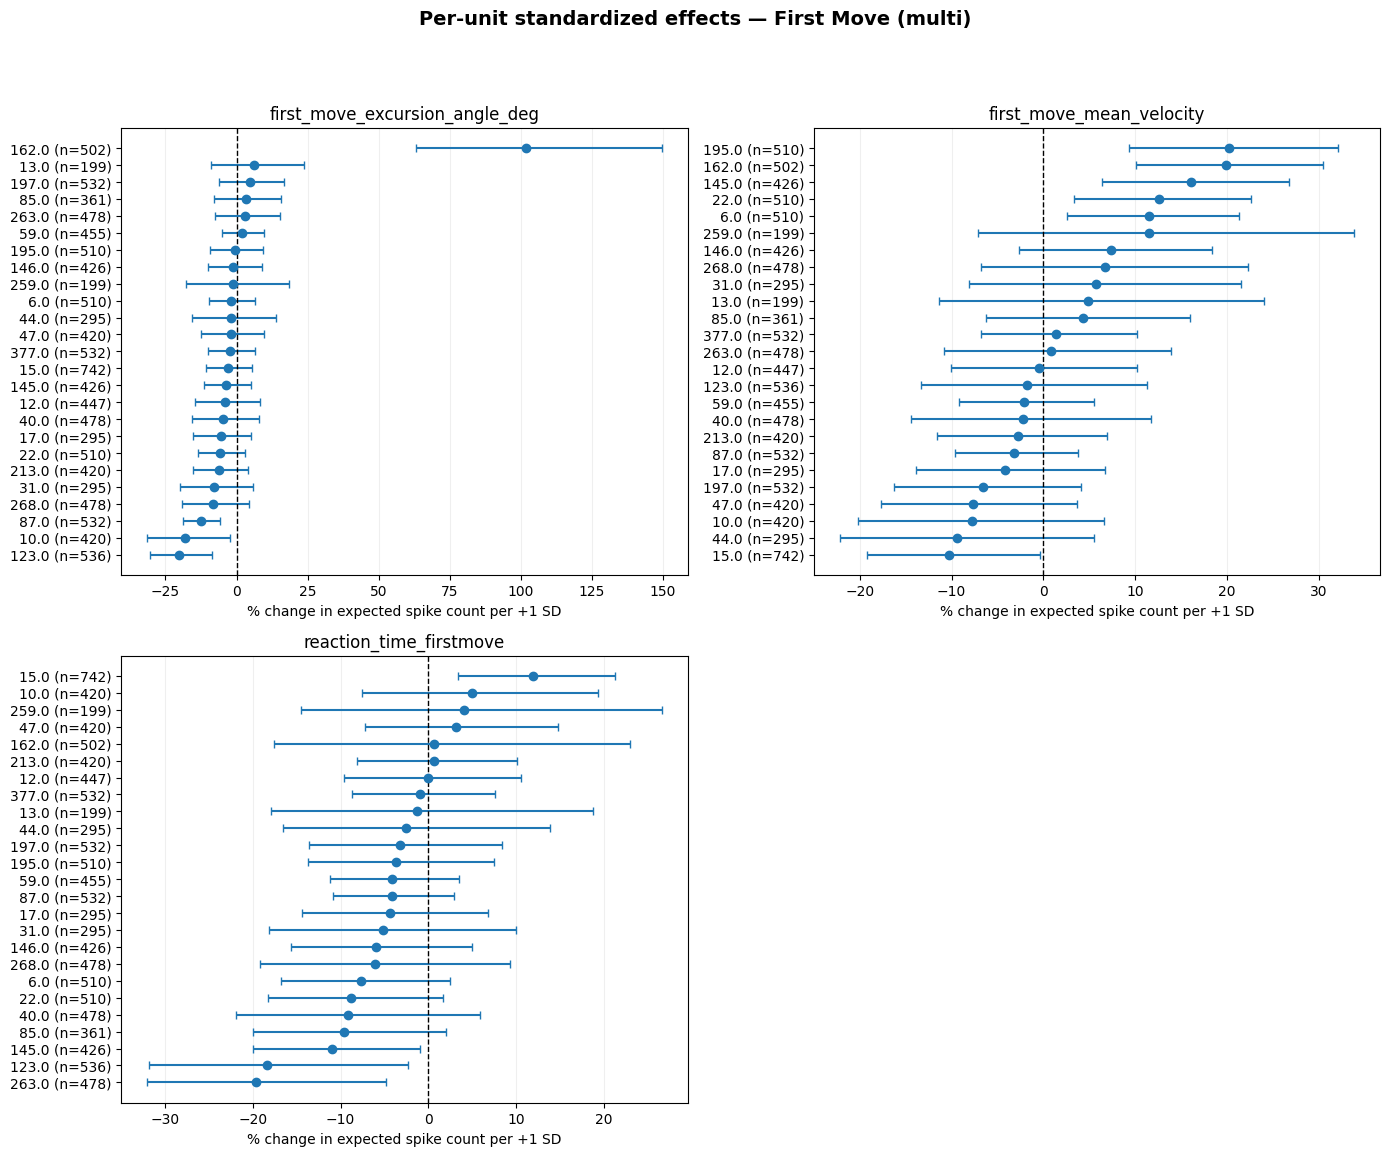

In [ ]:
# First-move RT per unit
per_unit = per_unit_standardized_effects(all_counts_df, ["reaction_time_firstmove"], min_trials=50)
plot_per_unit_effects(per_unit, title="Per-unit standardized effects — First Move RT")

# Cue-response RT per unit
per_unit_cr = per_unit_standardized_effects(all_counts_df, ["reaction_time_cueresponse"], min_trials=50)
plot_per_unit_effects(per_unit_cr, title="Per-unit standardized effects — Cue Response RT")

# Multiple predictors at once per unit (panels per predictor)
per_unit_multi = per_unit_standardized_effects(
    all_counts_df,
    ["reaction_time_firstmove","first_move_mean_velocity","first_move_excursion_angle_deg"],
    min_trials=50
)
plot_per_unit_effects(per_unit_multi, title="Per-unit standardized effects — First Move (multi)")


In [ ]:
# Correlate predictors by their *per-unit standardized effects* and visualize as heatmaps.
# Requirements satisfied:
#  - Uses matplotlib only
#  - One chart per figure (no subplots)
#  - No explicit colors specified
#
# Workflow:
#   1) Get per-unit standardized effects (already available via per_unit_standardized_effects(...)).
#   2) Pivot to a wide matrix: rows=unit_id, cols=predictors, values=% change per +1 SD (within-unit).
#   3) Compute Pearson and Spearman correlations across columns (predictors).
#   4) Plot each correlation matrix as its own heatmap with numeric annotations.
#
# Example:
#   per_unit_multi = per_unit_standardized_effects(
#       all_counts_df,
#       ["reaction_time_firstmove","first_move_mean_velocity","first_move_excursion_angle_deg"],
#       min_trials=50
#   )
#   plot_effect_correlation_heatmaps(per_unit_multi, title_prefix="First Move (per-unit effects)")
#
# Optionally, compute *trial-level* raw predictor correlations (across all trials):
#   plot_trial_level_predictor_correlations(all_counts_df, ["reaction_time_firstmove","first_move_mean_velocity","first_move_excursion_angle_deg"],
#                                           title="First Move (trial-level predictors)")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List

def _pivot_effects(per_unit_df: pd.DataFrame) -> pd.DataFrame:
    """Pivot to unit x predictor matrix of % change per SD (within-unit)."""
    # Expect columns: unit_id, predictor, pct_per_SD
    cols_needed = {"unit_id", "predictor", "pct_per_SD"}
    if not cols_needed.issubset(set(per_unit_df.columns)):
        raise ValueError(f"per_unit_df must contain {cols_needed}, got {set(per_unit_df.columns)}")
    wide = per_unit_df.pivot_table(index="unit_id", columns="predictor", values="pct_per_SD", aggfunc="mean")
    # Drop units with all NaNs
    wide = wide.dropna(how="all")
    return wide

def _annotated_heatmap(mat: np.ndarray, labels: List[str], title: str):
    """Render a correlation heatmap with value annotations."""
    fig, ax = plt.subplots(figsize=(1.2*len(labels)+2, 1.2*len(labels)+2))
    im = ax.imshow(mat, aspect="equal")
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)
    ax.set_title(title)
    # Grid lines (light)
    ax.set_xticks(np.arange(-.5, len(labels), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(labels), 1), minor=True)
    ax.grid(which="minor", linewidth=0.5)
    # Annotate
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            val = mat[i, j]
            if np.isfinite(val):
                ax.text(j, i, f"{val:.2f}", ha="center", va="center")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

def plot_effect_correlation_heatmaps(per_unit_df: pd.DataFrame, title_prefix: str = "Per-unit effects"):
    """Compute Pearson and Spearman correlations between predictors' per-unit effects and plot heatmaps."""
    wide = _pivot_effects(per_unit_df)
    # Drop rows with any NaN to compute correlation on common set (or use pairwise; here use pairwise via pandas)
    # Pearson
    pear = wide.corr(method="pearson")
    _annotated_heatmap(pear.to_numpy(), list(pear.columns), title=f"{title_prefix} — Pearson correlation")
    # Spearman
    spear = wide.corr(method="spearman")
    _annotated_heatmap(spear.to_numpy(), list(spear.columns), title=f"{title_prefix} — Spearman correlation")

def plot_trial_level_predictor_correlations(df: pd.DataFrame, predictors: List[str], title: str = "Trial-level predictor correlations"):
    """Correlation among raw predictors at the trial level (pooled across units/sessions after dropping NaNs)."""
    sub = df.dropna(subset=predictors).copy()
    if sub.empty:
        print("No rows for trial-level correlations after dropping NaNs.")
        return
    pear = sub[predictors].corr(method="pearson")
    _annotated_heatmap(pear.to_numpy(), predictors, title=f"{title} — Pearson")
    spear = sub[predictors].corr(method="spearman")
    _annotated_heatmap(spear.to_numpy(), predictors, title=f"{title} — Spearman")

print("Loaded: plot_effect_correlation_heatmaps(per_unit_df, ...), plot_trial_level_predictor_correlations(df, predictors, ...).")


Loaded: plot_effect_correlation_heatmaps(per_unit_df, ...), plot_trial_level_predictor_correlations(df, predictors, ...).


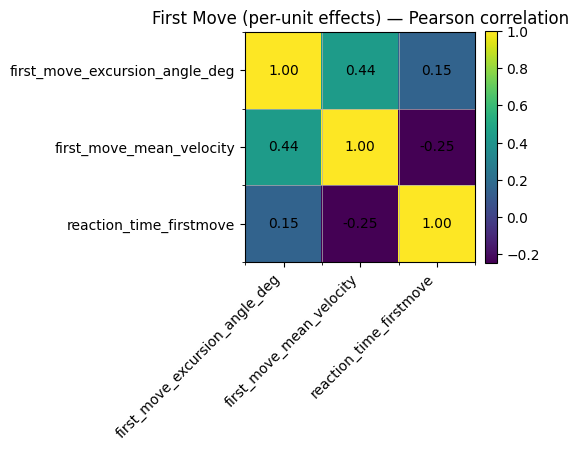

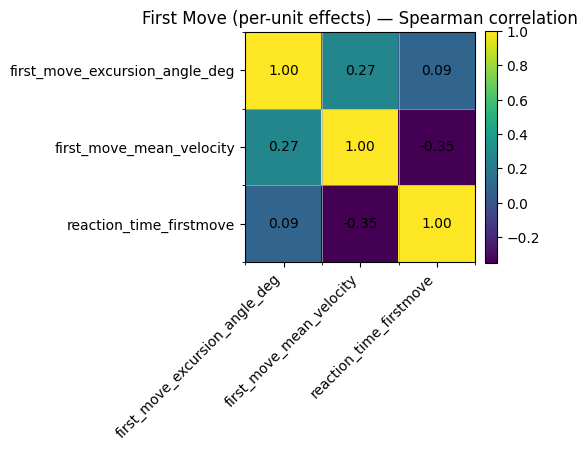

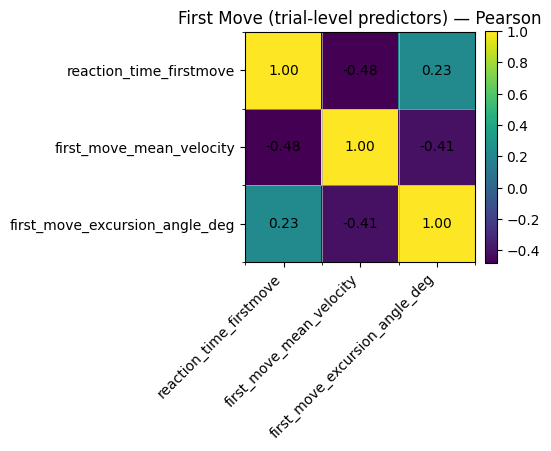

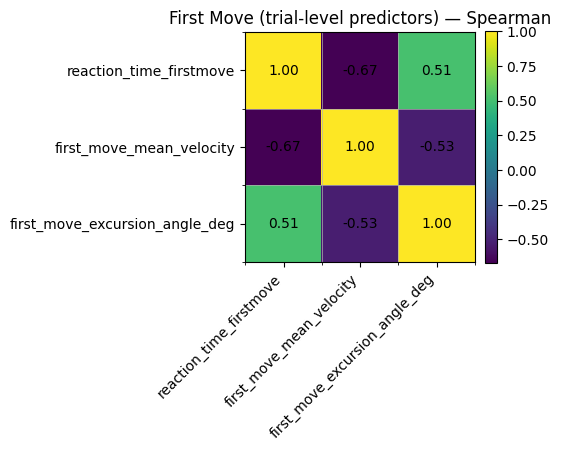

In [ ]:
# 1) Build per-unit effects for multiple predictors
per_unit_multi = per_unit_standardized_effects(
    all_counts_df,
    ["reaction_time_firstmove","first_move_mean_velocity","first_move_excursion_angle_deg"],
    min_trials=50
)

# 2) Correlate predictors by per-unit effects (two figures: Pearson & Spearman)
plot_effect_correlation_heatmaps(per_unit_multi, title_prefix="First Move (per-unit effects)")

# (Optional) Trial-level raw predictor collinearity
plot_trial_level_predictor_correlations(
    all_counts_df,
    ["reaction_time_firstmove","first_move_mean_velocity","first_move_excursion_angle_deg"],
    title="First Move (trial-level predictors)"
)


In [ ]:
# Updated correlation heatmap: show absolute values (magnitudes only).
def _annotated_heatmap_abs(mat: np.ndarray, labels: List[str], title: str):
    """Render a correlation heatmap with absolute value annotations."""
    fig, ax = plt.subplots(figsize=(1.2*len(labels)+2, 1.2*len(labels)+2))
    im = ax.imshow(np.abs(mat), aspect="equal")
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)
    ax.set_title(title)
    ax.set_xticks(np.arange(-.5, len(labels), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(labels), 1), minor=True)
    ax.grid(which="minor", linewidth=0.5)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            val = mat[i, j]
            if np.isfinite(val):
                ax.text(j, i, f"{abs(val):.2f}", ha="center", va="center")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

def plot_effect_correlation_heatmaps_abs(per_unit_df: pd.DataFrame, title_prefix: str = "Per-unit effects (abs)"):
    """Compute correlation magnitudes (abs) between predictors' per-unit effects and plot heatmaps."""
    wide = _pivot_effects(per_unit_df)
    pear = wide.corr(method="pearson")
    _annotated_heatmap_abs(pear.to_numpy(), list(pear.columns), title=f"{title_prefix} — Pearson |r|")
    spear = wide.corr(method="spearman")
    _annotated_heatmap_abs(spear.to_numpy(), list(spear.columns), title=f"{title_prefix} — Spearman |ρ|")

print("Loaded: plot_effect_correlation_heatmaps_abs(per_unit_df, ...) for absolute correlation magnitudes.")


Loaded: plot_effect_correlation_heatmaps_abs(per_unit_df, ...) for absolute correlation magnitudes.


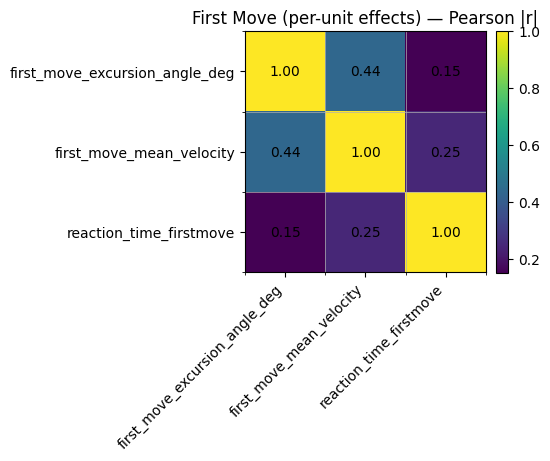

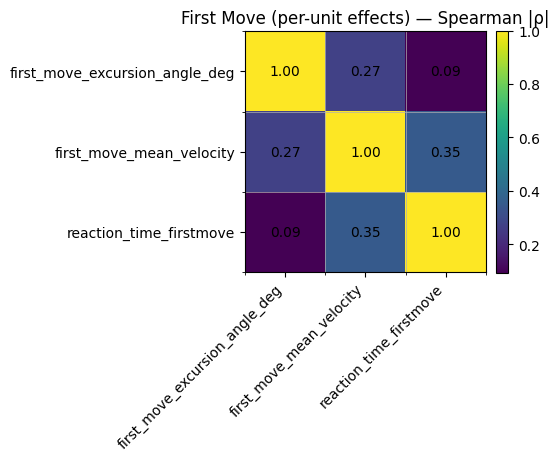

In [ ]:
# After computing per-unit effects with multiple predictors:
per_unit_multi = per_unit_standardized_effects(
    all_counts_df,
    ["reaction_time_firstmove","first_move_mean_velocity","first_move_excursion_angle_deg"],
    min_trials=50
)

# Plot correlation magnitudes (Pearson and Spearman)
plot_effect_correlation_heatmaps_abs(per_unit_multi, title_prefix="First Move (per-unit effects)")


In [ ]:
# Scatterplot of per‑unit standardized effects for any two predictors.
# Each point = one unit’s % change in expected spike count per +1 SD (from per_unit_standardized_effects).
# Requirements met: matplotlib only; one chart per figure; no explicit colors.
#
# Usage:
#   # Build per‑unit effects first (example for first‑move predictors)
#   per_unit_multi = per_unit_standardized_effects(
#       all_counts_df,
#       ["reaction_time_firstmove","first_move_mean_velocity","first_move_excursion_angle_deg"],
#       min_trials=50
#   )
#   # Then scatter any pair:
#   plot_effect_scatter(per_unit_multi, "reaction_time_firstmove", "first_move_mean_velocity",
#                       title="Per‑unit effects: RT vs Velocity")
#
#   # Optionally label top‑magnitude points
#   plot_effect_scatter(per_unit_multi, "reaction_time_firstmove", "first_move_mean_velocity",
#                       title="Per‑unit effects: RT vs Velocity (top labels)",
#                       label_top_n=10)
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List

def _pivot_effects_simple(per_unit_df: pd.DataFrame) -> pd.DataFrame:
    req = {"unit_id","predictor","pct_per_SD"}
    if not req.issubset(per_unit_df.columns):
        raise ValueError(f"per_unit_df must have columns {req}, found {set(per_unit_df.columns)}")
    wide = per_unit_df.pivot_table(index="unit_id", columns="predictor", values="pct_per_SD", aggfunc="mean")
    return wide

def plot_effect_scatter(per_unit_df: pd.DataFrame, x_predictor: str, y_predictor: str,
                        title: str = "", label_top_n: int = 0, use_abs: bool = False):
    """
    Scatter per‑unit effect sizes for two predictors.
      - x,ycoords are % change in expected spike count per +1 SD (within‑unit standardization)
      - If use_abs=True, plot absolute magnitudes (|effect|) and compute correlations on |effects|.
      - Adds Pearson r and Spearman rho annotations.
      - Optionally adds an OLS best‑fit line (on signed values) for visual trend.
    """
    wide = _pivot_effects_simple(per_unit_df)
    if x_predictor not in wide.columns or y_predictor not in wide.columns:
        missing = [p for p in [x_predictor, y_predictor] if p not in wide.columns]
        raise ValueError(f"Missing predictors in per_unit_df: {missing}")
    mat = wide[[x_predictor, y_predictor]].dropna()
    if mat.empty:
        print("No overlapping units with both effects available.")
        return

    x = mat[x_predictor].to_numpy()
    y = mat[y_predictor].to_numpy()
    x_plot = np.abs(x) if use_abs else x
    y_plot = np.abs(y) if use_abs else y

    # Correlations
    def _safe_corr(a,b,method="pearson"):
        try:
            if method == "pearson":
                return float(np.corrcoef(a,b)[0,1])
            else:
                from scipy.stats import spearmanr
                return float(spearmanr(a,b, nan_policy="omit").statistic)
        except Exception:
            return np.nan

    r = _safe_corr(x_plot, y_plot, "pearson")
    rho = _safe_corr(x_plot, y_plot, "spearman")

    # Figure
    plt.figure(figsize=(7,6))
    plt.scatter(x_plot, y_plot, s=25, alpha=0.7)
    plt.xlabel(f"{x_predictor} — %Δ per +1 SD" + (" (|.|)" if use_abs else ""))
    plt.ylabel(f"{y_predictor} — %Δ per +1 SD" + (" (|.|)" if use_abs else ""))
    ttl = title if title else f"Per‑unit effects: {x_predictor} vs {y_predictor}"
    plt.title(ttl)

    # Best‑fit line (on signed values only; skip if abs magnitudes requested)
    if not use_abs and len(x) >= 2 and np.isfinite(x).all() and np.isfinite(y).all():
        try:
            m, b = np.polyfit(x, y, 1)
            xs = np.linspace(np.nanmin(x_plot), np.nanmax(x_plot), 100)
            plt.plot(xs, m*xs + b, linewidth=2)
        except Exception:
            pass

    # Label a few most extreme points by distance from origin (in plotting space)
    if label_top_n > 0:
        d = np.sqrt((x_plot - np.median(x_plot))**2 + (y_plot - np.median(y_plot))**2)
        idx = np.argsort(d)[-label_top_n:]
        for i in idx:
            uid = mat.index[i]
            plt.text(x_plot[i], y_plot[i], str(uid), fontsize=8, ha="left", va="bottom")

    # Annotate correlations
    txt = f"Pearson r = {r:.2f}\nSpearman ρ = {rho:.2f}\nN = {len(x_plot)} units"
    plt.gcf().text(0.98, 0.02, txt, ha="right", va="bottom",
                   bbox=dict(boxstyle="round,pad=0.3", alpha=0.2))

    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

print("Loaded: plot_effect_scatter(per_unit_df, x_predictor, y_predictor, title='...', label_top_n=0, use_abs=False).")


Loaded: plot_effect_scatter(per_unit_df, x_predictor, y_predictor, title='...', label_top_n=0, use_abs=False).


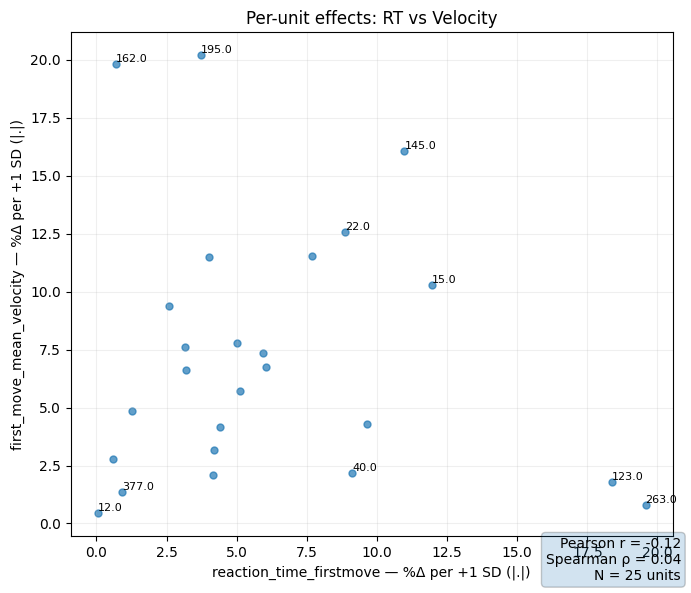

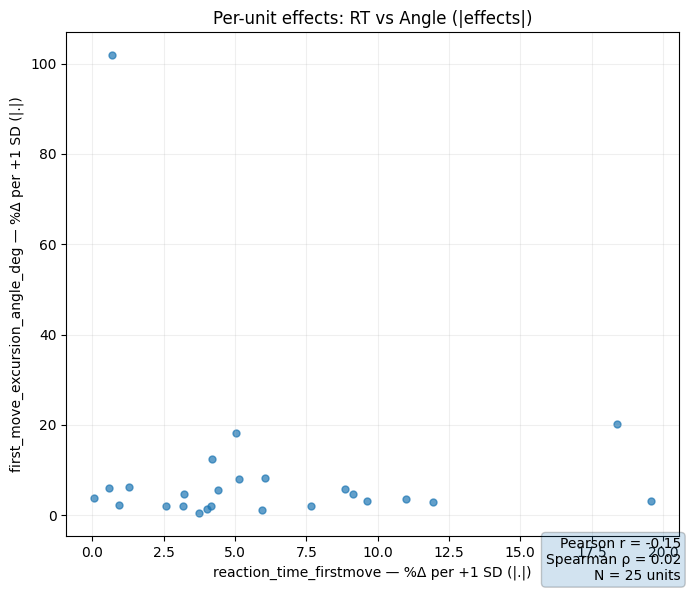

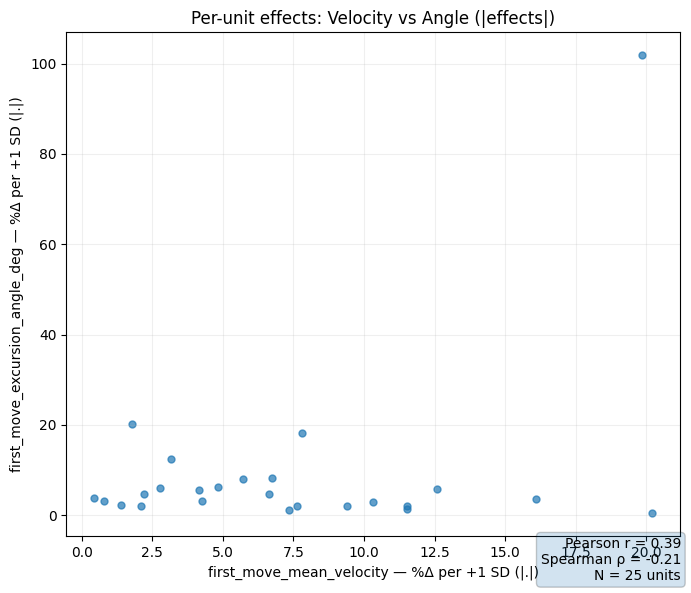

In [ ]:
# 1) Build per-unit effects for multiple predictors
per_unit_multi = per_unit_standardized_effects(
    all_counts_df,
    ["reaction_time_firstmove","first_move_mean_velocity","first_move_excursion_angle_deg"],
    min_trials=50
)

# 2) Scatter: RT effect vs Velocity effect (signed)
plot_effect_scatter(
    per_unit_multi,
    "reaction_time_firstmove",
    "first_move_mean_velocity",
    title="Per-unit effects: RT vs Velocity",
    label_top_n=10,   # optional labels for most extreme units
    use_abs=True     # set True to ignore direction
)

# 3) Scatter: RT effect vs Angle effect (magnitudes only)
plot_effect_scatter(
    per_unit_multi,
    "reaction_time_firstmove",
    "first_move_excursion_angle_deg",
    title="Per-unit effects: RT vs Angle (|effects|)",
    use_abs=True
)

# 3) Scatter: RT effect vs Angle effect (magnitudes only)
plot_effect_scatter(
    per_unit_multi,
    "first_move_mean_velocity",
    "first_move_excursion_angle_deg",
    title="Per-unit effects: Velocity vs Angle (|effects|)",
    use_abs=True
)


In [ ]:
# Patch: make 'cluster' drop robust when computing centroids (it may already be excluded by numeric_only=True).
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

def run_effect_clustering(per_unit_df: pd.DataFrame,
                          predictors=None,
                          n_clusters: int = 3,
                          use_abs: bool = False,
                          scale: bool = True,
                          title_prefix: str = "Per‑unit effect clustering"):
    # Reuse helpers from previous cell (assumed loaded): _pivot_effects, _standardize_cols, _plot_heatmap, _plot_embedding, _plot_centroids
    def _pivot_effects(per_unit_df, predictors):
        req = {"unit_id","predictor","pct_per_SD"}
        if not req.issubset(per_unit_df.columns):
            raise ValueError(f"per_unit_df must have columns {req}, found {set(per_unit_df.columns)}")
        wide = per_unit_df.pivot_table(index="unit_id", columns="predictor", values="pct_per_SD", aggfunc="mean")
        if predictors is not None:
            keep = [p for p in predictors if p in wide.columns]
            if not keep:
                raise ValueError("None of the requested predictors were found in per_unit_df.")
            wide = wide[keep]
        wide = wide.dropna(axis=0, how="any")
        return wide

    def _standardize_cols(X: np.ndarray) -> np.ndarray:
        Xs = X.copy().astype(float)
        means = np.nanmean(Xs, axis=0)
        stds = np.nanstd(Xs, axis=0, ddof=1)
        stds[stds == 0] = 1.0
        return (Xs - means) / stds

    def _plot_heatmap(matrix, row_labels, col_labels, title):
        fig, ax = plt.subplots(figsize=(1.2*len(col_labels)+3, 0.18*len(row_labels)+3))
        im = ax.imshow(matrix, aspect="auto", cmap="coolwarm")
        ax.set_xticks(range(len(col_labels)))
        ax.set_xticklabels(col_labels, rotation=45, ha="right")
        ax.set_yticks(range(len(row_labels)))
        ax.set_yticklabels(row_labels)
        ax.set_title(title)
        ax.set_xticks(np.arange(-.5, len(col_labels), 1), minor=True)
        ax.set_yticks(np.arange(-.5, len(row_labels), 1), minor=True)
        ax.grid(which="minor", linewidth=0.5)
        im.set_clim(-20, 20)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()

    def _plot_embedding(X: np.ndarray, labels: np.ndarray, title: str):
        fig, ax = plt.subplots(figsize=(7,6))
        for k in np.unique(labels):
            pts = X[labels == k]
            ax.scatter(pts[:,0], pts[:,1], s=25, alpha=0.8, label=f"cluster {int(k)}")
        ax.set_title(title)
        ax.set_xlabel("Dim 1")
        ax.set_ylabel("Dim 2")
        ax.legend()
        ax.grid(True, alpha=0.2)
        plt.tight_layout()
        plt.show()

    def _plot_centroids(centroids: pd.DataFrame, title: str):
        cols = list(centroids.columns)
        K = len(centroids)
        x = np.arange(len(cols))
        width = 0.8 / max(K, 1)
        fig, ax = plt.subplots(figsize=(1.2*len(cols)+3, 5))
        for i, (idx, row) in enumerate(centroids.iterrows()):
            ax.bar(x + i*width, row.values, width, label=f"cluster {int(idx)}")
        ax.set_xticks(x + (K-1)*width/2 if K>1 else x)
        ax.set_xticklabels(cols, rotation=30, ha="right")
        ax.set_ylabel("%Δ expected spike count per +1 SD")
        ax.set_title(title)
        ax.legend()
        ax.grid(True, axis="y", alpha=0.2)
        plt.tight_layout()
        plt.show()

    wide = _pivot_effects(per_unit_df, predictors=predictors)
    X = wide.values.copy()
    if use_abs:
        X = np.abs(X)
    X_for_cluster = _standardize_cols(X) if scale else X

    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=20)
    lab = kmeans.fit_predict(X_for_cluster)
    wide_with_labels = wide.copy()
    wide_with_labels["cluster"] = lab

    order = np.argsort(lab, kind="mergesort")
    wide_sorted = wide_with_labels.iloc[order]
    _plot_heatmap(wide_sorted.drop(columns=["cluster"]).values,
                  row_labels=[f"{idx} (c{int(c)})" for idx, c in zip(wide_sorted.index, wide_sorted["cluster"])],
                  col_labels=list(wide.columns),
                  title=f"{title_prefix} — effect profiles by cluster")

    # t-SNE embedding with safe perplexity
    try:
        from sklearn.manifold import TSNE
        perplexity = min(30, max(5, X_for_cluster.shape[0]//5))
        emb = TSNE(n_components=2, random_state=0, perplexity=perplexity).fit_transform(X_for_cluster)
        _plot_embedding(emb, lab, title=f"{title_prefix} — t‑SNE embedding")
    except Exception:
        # PCA fallback
        Xc = X_for_cluster - np.mean(X_for_cluster, axis=0, keepdims=True)
        U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
        emb = Xc @ Vt[:2].T
        _plot_embedding(emb, lab, title=f"{title_prefix} — PCA embedding")

    # Robust centroid computation
    # Use numeric_only=True, then no need to drop 'cluster'; or drop with errors='ignore'
    centroids = wide_with_labels.groupby("cluster").mean(numeric_only=True)
    if "cluster" in centroids.columns:
        centroids = centroids.drop(columns=["cluster"], errors="ignore")

    _plot_centroids(centroids, title=f"{title_prefix} — cluster centroids")

    # Tables
    summary_counts = wide_with_labels["cluster"].value_counts().sort_index()
    summary = pd.DataFrame({"cluster": summary_counts.index.astype(int), "n_units": summary_counts.values})
    try:
        from caas_jupyter_tools import display_dataframe_to_user
        display_dataframe_to_user("Cluster sizes", summary)
        display_dataframe_to_user("Cluster centroids (mean %Δ per +1 SD)", centroids.reset_index().rename(columns={"index":"cluster"}))
    except Exception:
        print("Cluster sizes:\n", summary)
        print("\nCluster centroids:\n", centroids)

    return wide_with_labels

print("Patched run_effect_clustering(): robust centroid calculation; please re-run your clustering call.")


Patched run_effect_clustering(): robust centroid calculation; please re-run your clustering call.


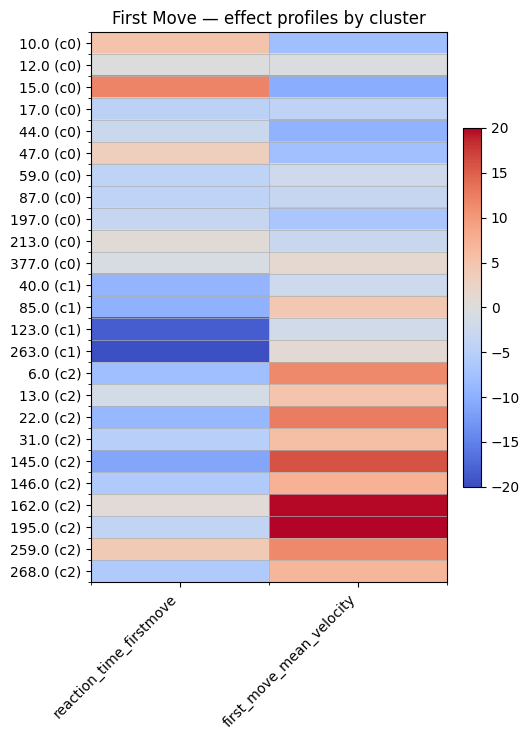

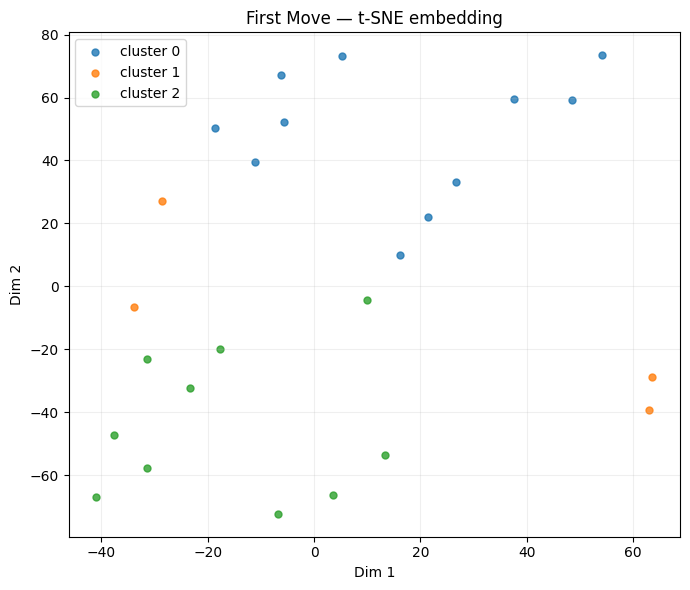

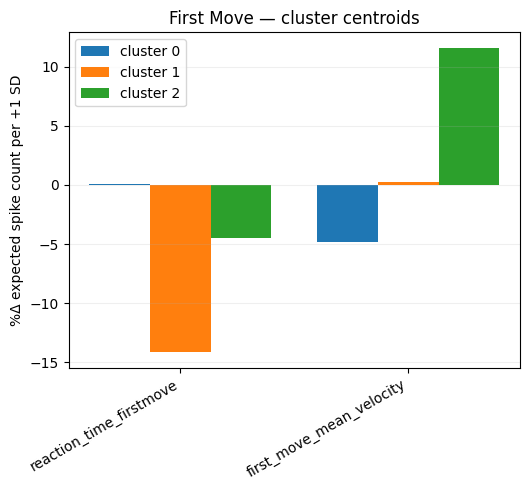

Cluster sizes:
    cluster  n_units
0        0       11
1        1        4
2        2       10

Cluster centroids:
 predictor  reaction_time_firstmove  first_move_mean_velocity
cluster                                                     
0                         0.113992                 -4.813903
1                       -14.180425                  0.269302
2                        -4.493205                 11.637172


In [ ]:
# 1) Build per-unit effect sizes for the predictors you care about
per_unit_multi = per_unit_standardized_effects(
    all_counts_df,
    ["reaction_time_firstmove","first_move_mean_velocity","first_move_excursion_angle_deg"],
    min_trials=50
)

clustered = run_effect_clustering(
    per_unit_multi,
    predictors=["reaction_time_firstmove","first_move_mean_velocity"],
    n_clusters=3,
    use_abs=False,   # set True to cluster by magnitudes (ignore sign)
    scale=True,
    title_prefix="First Move"
)



In [56]:
import pandas as pd
from typing import Iterable, Optional, Dict, Any

REQUIRED_COLS = {
    "cue_response_movement_number",
    "movement_latency_from_go",
    "movement_number_in_trial",
    "cue_response",
}

def _prepare_movements(movs: pd.DataFrame, licks: pd.DataFrame, df_trials: pd.DataFrame) -> pd.DataFrame:
    """
    Ensure movement annotations exist; return a copy with required columns present.
    """
    tm = movs.copy()

    # (Re)annotate if any required columns are missing
    if not REQUIRED_COLS.issubset(tm.columns):
        tm = add_lick_metadata_to_movements(tm, licks, fields=["timestamps"]).rename(
            columns={"timestamps": "lick_time"}
        )
        tm = annotate_movement_timing(tm, df_trials)

    # Light dtype hygiene (robust joins later)
    if "movement_number_in_trial" in tm.columns:
        tm["movement_number_in_trial"] = pd.to_numeric(
            tm["movement_number_in_trial"], errors="coerce"
        ).astype("Int64")
    if "cue_response_movement_number" in tm.columns:
        tm["cue_response_movement_number"] = pd.to_numeric(
            tm["cue_response_movement_number"], errors="coerce"
        ).astype("Int64")
    if "cue_response" in tm.columns:
        tm["cue_response"] = tm["cue_response"].astype("boolean")
    if "trial" in tm.columns:
        tm["trial"] = pd.to_numeric(tm["trial"], errors="coerce").astype("Int64")

    return tm

def collect_all_movements(
    sessions: Optional[Iterable[str]] = None,
    *,
    progress: bool = True
) -> pd.DataFrame:
    """
    Load each session's intermediates, ensure required movement annotations,
    add a 'session' column, and concatenate into one DataFrame.
    """
    # Default: derive session list from units_with_spikes if not provided
    if sessions is None:
        sessions = getattr(globals().get("units_with_spikes", pd.DataFrame()), "session", pd.Series()).unique()
        sessions = [s for s in sessions if pd.notna(s)]

    all_chunks = []
    for sess in sessions:
        try:
            sdir = find_scratch_session_dir(sess,base_dirs)
            data: Dict[str, Any] = load_intermediate_data(sdir)
            movs   = data["movs"]
            licks  = data["licks"]
            trials = data["trials"]

            tm = _prepare_movements(movs, licks, trials)
            tm = tm.copy()
            tm["session"] = sess  # tag provenance
            all_chunks.append(tm)

            if progress:
                print(f"[ok] {sess}: {len(tm)} movements")

        except Exception as e:
            if progress:
                print(f"[warn] {sess}: skipped due to error -> {e!r}")

    if not all_chunks:
        raise RuntimeError("No movement tables collected. Check sessions / loaders.")

    all_movs = pd.concat(all_chunks, ignore_index=True, copy=False)

    # Optional sanity checks (uncomment if helpful):
    # assert (all_movs.groupby(["session","trial"])["cue_response_movement_number"]
    #         .nunique(dropna=True).le(1)).all(), "Inconsistent CRMN within a (session, trial)"

    # # Nice-to-have ordering for browsing
    # sort_cols = [c for c in ["session","trial","movement_number_in_trial","start_time"] if c in all_movs.columns]
    # if sort_cols:
    #     all_movs = all_movs.sort_values(sort_cols, kind="mergesort", ignore_index=True)

    return all_movs

# ---- usage ----
# all_tongue_movements = collect_all_movements()               # derive sessions from units_with_spikes
# all_tongue_movements = collect_all_movements(my_sessions)    # or pass a custom list/iterator of session IDs


In [57]:
all_tongue_movements = collect_all_movements()

[ok] behavior_716325_2024-05-31_10-31-14: 7258 movements
[ok] behavior_717121_2024-06-15_10-00-58: 6990 movements
[ok] behavior_751004_2024-12-20_13-26-11: 6113 movements
[ok] behavior_751004_2024-12-21_13-28-28: 6164 movements
[ok] behavior_751004_2024-12-22_13-09-17: 7661 movements
[ok] behavior_751004_2024-12-23_14-20-03: 5863 movements
[ok] behavior_758017_2025-02-06_11-26-14: 5809 movements
[ok] behavior_758017_2025-02-07_14-11-08: 3257 movements
[ok] behavior_761038_2025-04-15_10-25-11: 6151 movements
[ok] behavior_761038_2025-04-16_10-39-10: 12381 movements
[ok] behavior_761038_2025-04-18_12-37-39: 12617 movements
[ok] behavior_781166_2025-05-15_14-20-51: 5300 movements


In [59]:
all_tongue_movements2 = collect_all_movements(filtered_df['session_id'].unique())

[ok] behavior_716325_2024-05-31_10-31-14: 7258 movements
[ok] behavior_761038_2025-04-15_10-24-57: 6151 movements
[ok] behavior_751004_2024-12-20_13-26-07: 6113 movements
[ok] behavior_751004_2024-12-22_13-09-11: 7661 movements
[ok] behavior_751004_2024-12-23_14-19-57: 5863 movements
[ok] behavior_761038_2025-04-18_12-37-37: 12617 movements
[ok] behavior_751004_2024-12-21_13-28-24: 6164 movements
[ok] behavior_761038_2025-04-16_10-39-06: 12381 movements
[ok] behavior_717121_2024-06-15_10-00-58: 6990 movements
[ok] behavior_717263_2024-07-24_10-40-05: 5308 movements
[ok] behavior_758017_2025-02-06_11-26-09: 5809 movements
[ok] behavior_782394_2025-04-25_11-13-18: 3916 movements
[ok] behavior_781166_2025-05-15_14-20-48: 5300 movements
[ok] behavior_758017_2025-02-07_14-11-05: 3257 movements


In [60]:
SAVE_PATH = Path("/root/capsule/scratch/all_tongue_movements_06102025.parquet")
SAVE_PATH.parent.mkdir(parents=True, exist_ok=True)
all_tongue_movements2.to_parquet(SAVE_PATH)

In [60]:
import numpy as np

session_id = "behavior_716325_2024-05-31_10-31-14"
trial_n = 28  # <-- change to the trial you want

# rows for just that (session, trial)
movs_trial = all_tongue_movements.loc[
    (all_tongue_movements["session"] == session_id) &
    (all_tongue_movements["trial"] == trial_n)
].copy()

movs_trial[[
    "session","trial","movement_number_in_trial","cue_response",
    "movement_latency_from_go","start_time","end_time","has_lick","lick_latency"
]]



session  trial  movement_number_in_trial  \
676  behavior_716325_2024-05-31_10-31-14     28                         1   
677  behavior_716325_2024-05-31_10-31-14     28                         2   
678  behavior_716325_2024-05-31_10-31-14     28                         3   
679  behavior_716325_2024-05-31_10-31-14     28                         4   
680  behavior_716325_2024-05-31_10-31-14     28                         5   
681  behavior_716325_2024-05-31_10-31-14     28                         6   
682  behavior_716325_2024-05-31_10-31-14     28                         7   
683  behavior_716325_2024-05-31_10-31-14     28                         8   
684  behavior_716325_2024-05-31_10-31-14     28                         9   
685  behavior_716325_2024-05-31_10-31-14     28                        10   
686  behavior_716325_2024-05-31_10-31-14     28                        11   
687  behavior_716325_2024-05-31_10-31-14     28                        12   

     cue_response  movement_latency_from_go  start_time    end_time  has_lick  \
676          True                  0.196416  381.921472  382.005472      True   
677         False                  0.384416  382.109472  382.195456      True   
678         False                    0.6024  382.327456  382.413472      True   
679         False                    0.8064  382.531456  382.635456      True   
680         False                  1.028416  382.753472  382.861472      True   
681         False                    1.2184  382.943456  383.041472      True   
682         False                  1.432416  383.157472  383.269472      True   
683         False                  1.636416  383.361472  383.469472      True   
684          <NA>                    2.0224  383.747456  383.789472     False   
685         False                  2.256416  383.981472  384.071456      True   
686         False                  2.476416  384.201472  384.301472      True   
687          <NA>                  6.358368  388.083424  388.197440     False   

     lick_latency  
676      0.214816  
677      0.214816  
678      0.214816  
679      0.214816  
680      0.214816  
681      0.214816  
682      0.214816  
683      0.214816  
684      0.214816  
685      0.214816  
686      0.214816  
687      0.214816

In [ ]:
# events_dict = {
#     'goCue': (
#         df_trials,
#         'goCue_start_time_in_session',
#         'trial'
#     ),
#     'firstLick': (
#         df_licks,
#         'timestamps',
#         'trial',
#         {'cue_response': True}   # Only include cue-response licks
#     ),
#     'firstMove': (
#         tongue_kinematics,
#         'time_in_session',
#         'trial',
#         {'min_after_cue': True}  # Only movements after go cue
#     ),
#     'reward': (
#         df_trials,
#         'reward_time_in_session',
#         'trial'
#         # No filters needed unless you want to restrict rewarded trials
#     )
# }


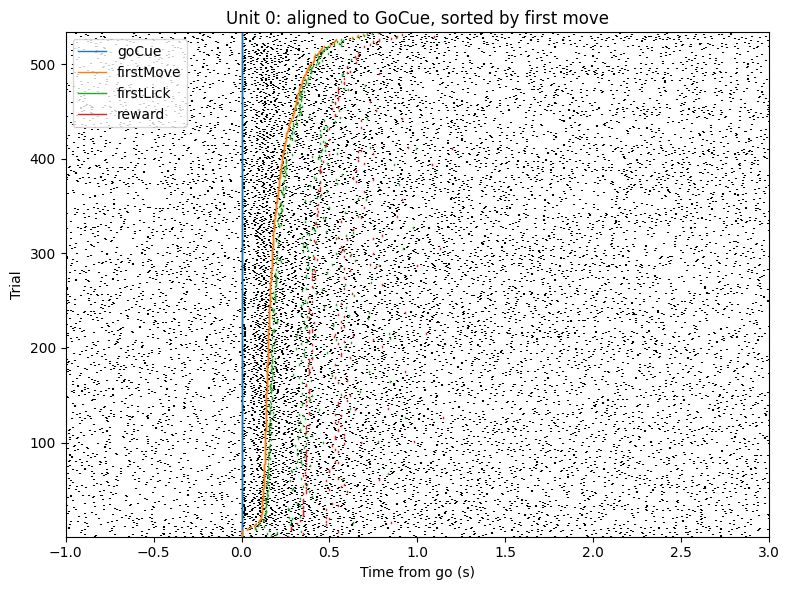

In [21]:
### example script demonstrating rasterplotter class

# 1) Prepare events df
events_dict = get_events_dict(df_trials, df_licks, tongue_kinematics)
E = build_event_df(events_dict=events_dict)

# 2) Choose trials (e.g., those with all events)
mask = E[['goCue','firstLick','firstMove']].notna().all(axis=1)
Ev = E.loc[mask]

# e.g. sort by firstLick - goCue
Ev = Ev.assign(Latency = Ev['firstMove'] - Ev['goCue'])
Ev = Ev.sort_values('Latency')
ordered_trials = Ev.index.tolist()

# 3) Create RasterPlotter for unit 0, aligned to goCue
# spikes = ephys_data.iloc[0]['spike_times_in_session']
spikes = spike_times_in_session
rp = RasterPlotter(
    spikes,
    ordered_trials,
    E['goCue'],
    pre=3,
    post=10,
    bin_size=0.001
)

# 4) Define overlay events, times, and styles
# Subtract goCue timing to get relative times for plotting
Rel = Ev[['goCue','firstLick','firstMove','reward']].subtract(Ev['goCue'], axis=0)
events = {}
colors = {'goCue':'C0','firstMove':'C1','firstLick':'C2','reward':'C3'}
for name in ['goCue','firstMove','firstLick','reward']:
    times = {i: Rel.loc[tr, name] for i, tr in enumerate(ordered_trials) if pd.notna(Rel.loc[tr,name])}
    events[name] = {'times': times, 'style': {'color': colors[name], 'linestyle':'-', 'linewidth':1}}

# 5) Plot
fig, ax = plt.subplots(figsize=(8,6))
rp.plot_with_events(events, ax=ax, spike_color='black')
ax.set_title('Unit 0: aligned to GoCue, sorted by first move')
ax.set_xlabel('Time from go (s)')
ax.legend(loc='upper left')
plt.xlim(-1,3)
plt.tight_layout()
plt.show()


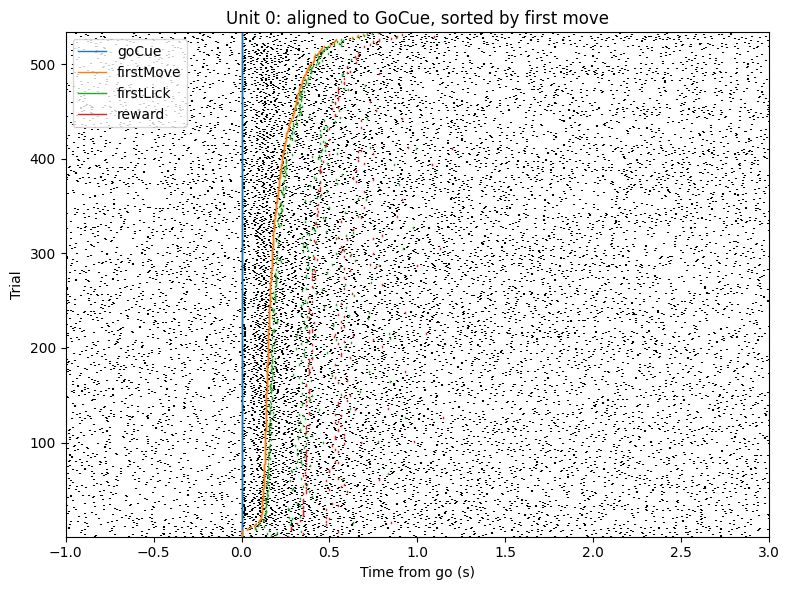

In [22]:
# 5) Plot
fig, ax = plt.subplots(figsize=(8,6))
rp.plot_with_events(events, ax=ax, spike_color='black')
ax.set_title('Unit 0: aligned to GoCue, sorted by first move')
ax.set_xlabel('Time from go (s)')
ax.legend(loc='upper left')
plt.xlim(-1,3)
plt.tight_layout()
plt.show()


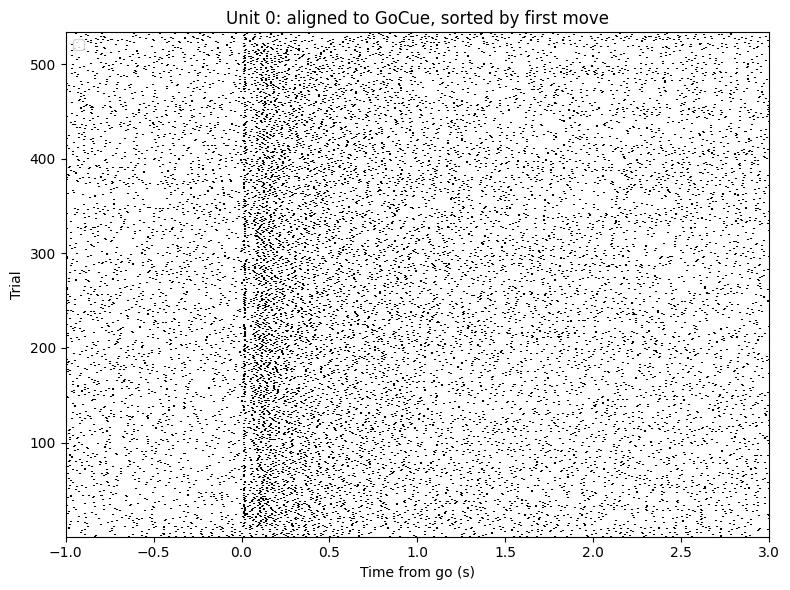

In [23]:
# 5) Plot
fig, ax = plt.subplots(figsize=(8,6))
rp.plot_raster(ax=ax)
ax.set_title('Unit 0: aligned to GoCue, sorted by first move')
ax.set_xlabel('Time from go (s)')
ax.legend(loc='upper left')
plt.xlim(-1,3)
plt.tight_layout()
plt.show()

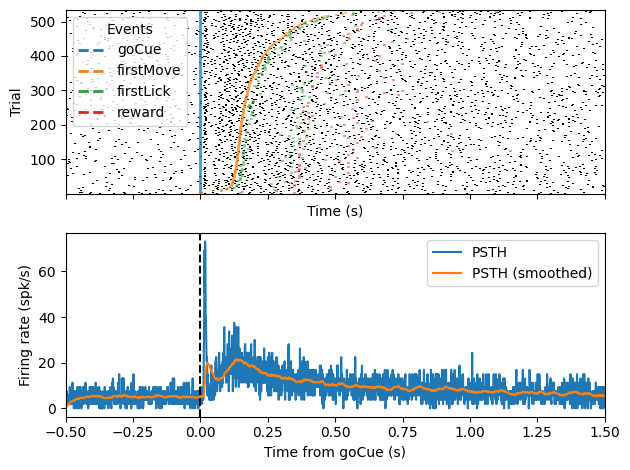

In [26]:
# once per script
E  = build_event_df(events_dict)
Ev = E.dropna(subset=['goCue','firstLick','firstMove'])
event_dicts = {n: Ev[n].to_dict() for n in Ev.columns}
trials = list(Ev.index)

# per unit
# spikes = ephys_data.iloc[0]['spike_times_in_session']
spikes = spike_times_in_session
rp, events = make_rp_and_events(
    spikes,
    trials,
    event_dicts,
    align_by='goCue',
    sort_by='firstMove',
    events_to_plot=['goCue','firstMove','firstLick','reward'],
    pre=0.5,
    post=1.5,
    bin_size=0.001
)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
rp.plot_raster(ax1)
rp.add_events(ax1, events)
ax1.legend(loc='upper left', title='Events')
psth, _  = compute_psth(rp.raster, bin_size=rp.bin_size)
psth_sm  = smooth_vector(psth, bin_size=rp.bin_size, sigma=0.025)
plot_psth(rp.bins, psth, psth_sm, ax=ax2)
ax2.set_xlabel(f"Time from goCue (s)")
plt.tight_layout()
plt.show()


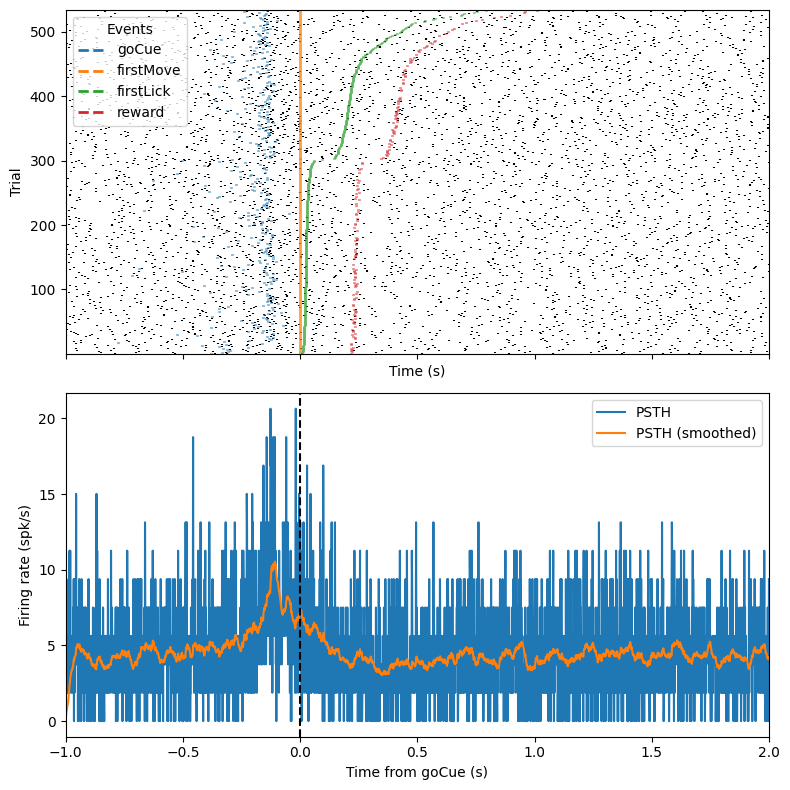

In [25]:

unit_n = 2
align_by = 'firstMove'
sort_by = 'firstLick'

# per unit
spikes = ephys_data.iloc[unit_n]['spike_times_in_session']
rp, events = make_rp_and_events(
    spikes,
    trials,
    event_dicts,
    align_by=align_by,
    sort_by=sort_by,
    events_to_plot=['goCue','firstMove','firstLick','reward'],
    pre=1,
    post=2,
    bin_size=0.001
)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8,8), sharex=True)
rp.plot_raster(ax1)
rp.add_events(ax1, events)
ax1.legend(loc='upper left', title='Events')
psth, _  = compute_psth(rp.raster, bin_size=rp.bin_size)
psth_sm  = smooth_vector(psth, bin_size=rp.bin_size, sigma=0.025)
plot_psth(rp.bins, psth, psth_sm, ax=ax2)
ax2.set_xlabel(f"Time from goCue (s)")
plt.tight_layout()
plt.show()

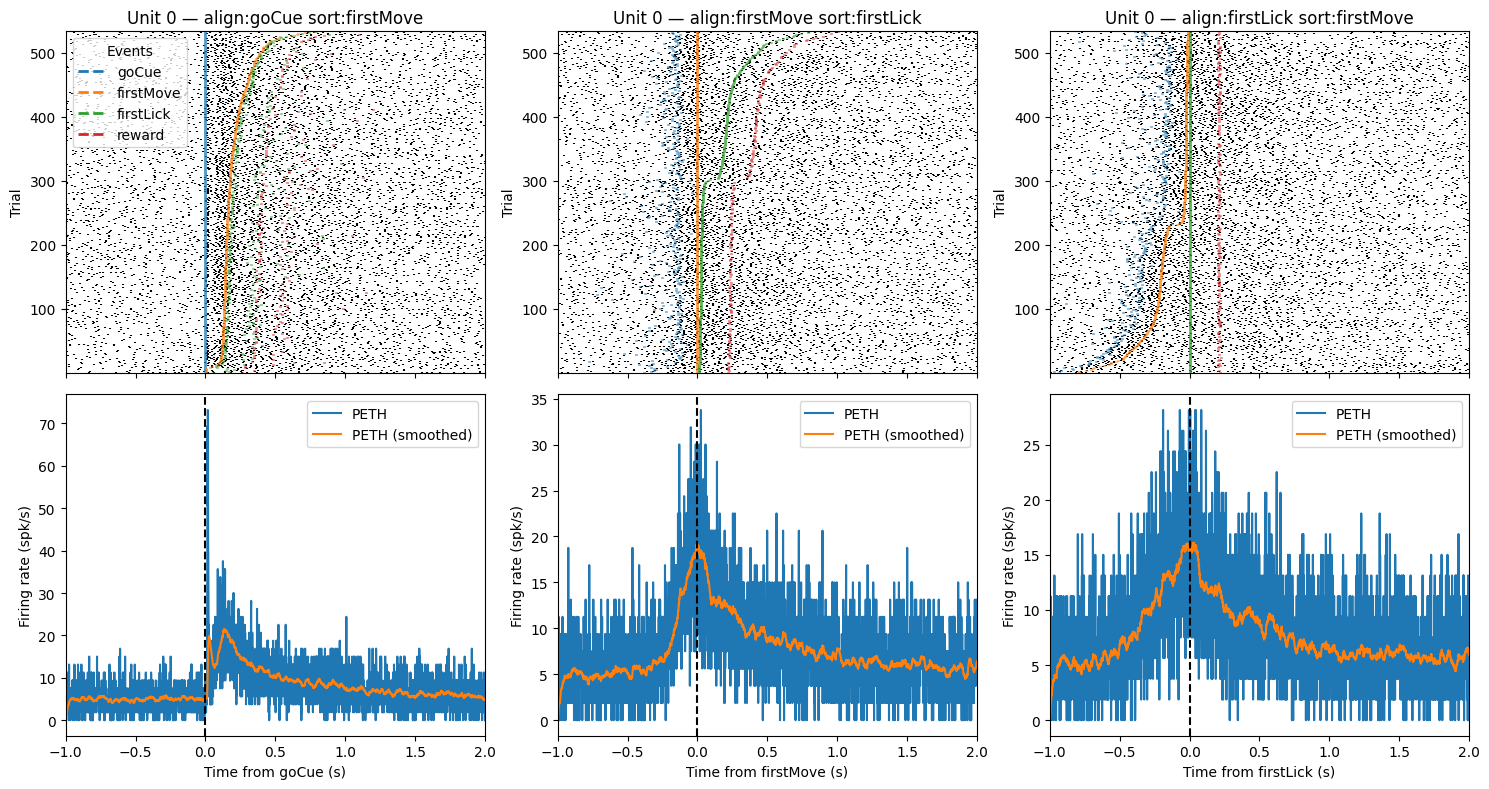

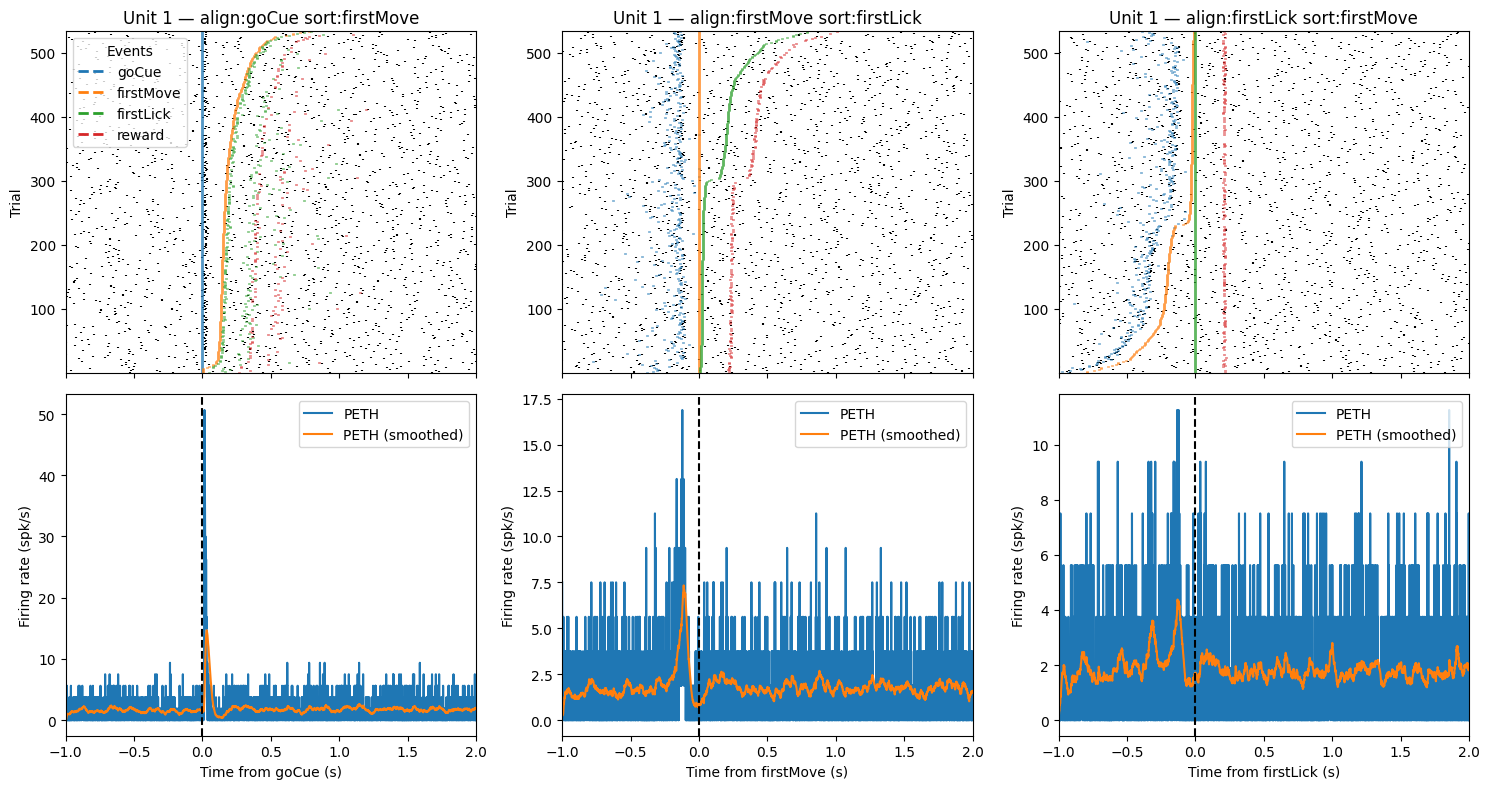

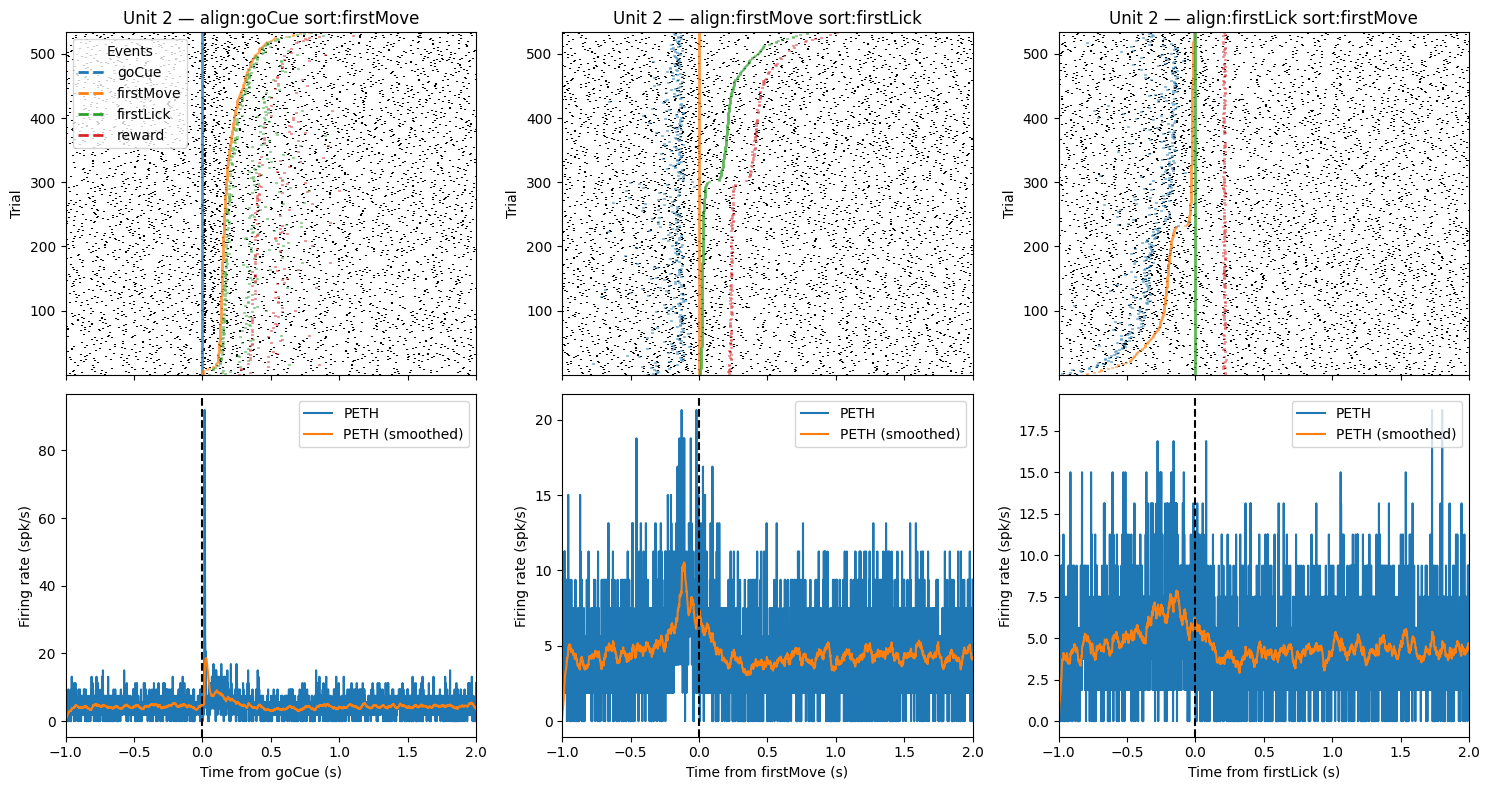

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# ————————————————————————————————————————————————
# 1) Build wide events DataFrame & filter
E  = build_event_df(events_dict)
Ev = E.dropna(subset=['goCue','firstLick','firstMove']).copy()

# ————————————————————————————————————————————————
# 2) Precompute once: trial list + event → {trial:time} mappings
trials = list(Ev.index)
event_dicts = {name: Ev[name].to_dict() for name in Ev.columns}

# ————————————————————————————————————————————————
# 3) Define the combos you want to plot
combos = [
    ('goCue',     'firstMove'),
    ('firstMove', 'firstLick'),
    ('firstLick', 'firstMove'),
]

# ————————————————————————————————————————————————
# 4) Helper to make the 2×3 figure for a single unit
def plot_unit_panels(spikes, unit_n,
                     trials,
                     event_dicts,
                     combos,
                     events_to_plot=None,
                     pre=1.0,
                     post=2.0,
                     bin_size=0.001,
                     sigma=0.025):
    """
    spikes         : 1D array of spike times
    trials         : list of trial IDs
    event_dicts    : {event_name -> {trial_id -> event_time}}
    combos         : list of (align_by, sort_by) pairs
    events_to_plot : list of event_names to overlay (defaults to all but align_by)
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex='col')

    for col, (align_by, sort_by) in enumerate(combos):
        # build the RasterPlotter + event overlays
        rp, events = make_rp_and_events(
            spikes,
            trials,
            event_dicts,
            align_by=align_by,
            sort_by=sort_by,
            events_to_plot=events_to_plot,  # or None to use all but align_by
            pre=pre,
            post=post,
            bin_size=bin_size
        )

        # top row: raster + event lines
        ax_r = axes[0, col]
        rp.plot_raster(ax=ax_r, spike_color='black')
        rp.add_events(ax_r, events)
        ax_r.set_title(f'Unit {unit_n} — align:{align_by} sort:{sort_by}')
        if col == 0:
            ax_r.set_ylabel('Trial')
            ax_r.legend(loc='upper left', title='Events')
        ax_r.set_xlabel(None)

        # bottom row: PSTH
        ax_p = axes[1, col]
        psth, _    = compute_psth(rp.raster, bin_size=rp.bin_size)
        psth_sm    = smooth_vector(psth, bin_size=rp.bin_size, sigma=sigma)
        plot_psth(rp.bins, psth, psth_sm, ax=ax_p, label='PETH')
        if col == 0:
            ax_p.set_ylabel('Firing rate (spk/s)')
        ax_p.set_xlabel(f'Time from {align_by} (s)')

    plt.tight_layout()
    return fig

# ————————————————————————————————————————————————
# 5) Loop over units and show/save
unit_list = [0,1,2]

for unit_n in unit_list:
    spikes = ephys_data.iloc[unit_n]['spike_times_in_session']
    fig = plot_unit_panels(
        spikes,
        unit_n,
        trials,
        event_dicts,
        combos,
        events_to_plot=['goCue', 'firstMove', 'firstLick', 'reward'],  # or None
        pre=1.0,
        post=2.0,
        bin_size=0.001,
        sigma=0.025
    )
    plt.show()
    # optionally: fig.savefig(f"unit_{unit_n}_panels.pdf")


In [ ]:
#splitraster for cue response movement number

#separate trials by pre-lick movement
from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import annotate_movement_timing, add_lick_metadata_to_movements

# Add lick time from licks_df
tongue_movements = add_lick_metadata_to_movements(
    tongue_movements,
    df_licks,
    fields=['timestamps']
)
tongue_movements = tongue_movements.rename(columns={'timestamps': 'lick_time'})

# Annotate movements using trials
tongue_movements = annotate_movement_timing(tongue_movements, df_trials)

In [31]:
# From your tongue_movements table
tm = tongue_movements

# Robust per-trial cue_response_movement_number (take first non-null if duplicates)
trial_crmn = (
    tm.groupby('trial')['cue_response_movement_number']
      .apply(lambda s: s.dropna().astype('Int64').iloc[0] if s.dropna().size else pd.NA)
)

trials_cr1 = set(trial_crmn[trial_crmn == 1].index.tolist())
trials_cr2 = set(trial_crmn[trial_crmn == 2].index.tolist())

# Keep only trials that exist in your events table Ev
valid_trials = set(Ev.index)
trials_cr1 = sorted(trials_cr1 & valid_trials)
trials_cr2 = sorted(trials_cr2 & valid_trials)


In [82]:
sort_key = 'firstMove'
lat = (Ev[sort_key] - Ev['goCue']).dropna()

ordered_cr1 = sorted(trials_cr1, key=lambda tr: lat.get(tr, np.inf))
ordered_cr2 = sorted(trials_cr2, key=lambda tr: lat.get(tr, np.inf))

# Combined order for the *single* raster: CR==1 first (bottom), CR==2 second (top)
combined_trials = ordered_cr1 + ordered_cr2
split_idx = len(ordered_cr1)  # row index where CR==2 starts


In [87]:
# Build align/event dicts just like your wrapper does
event_dicts = {n: Ev[n].to_dict() for n in Ev.columns}
spikes = ephys_data.iloc[0]['spike_times_in_session']

# Raster aligned to goCue, sorted by firstMove within our combined order
# (We already pre-sorted combined_trials, so pass as-is.)
align_key = 'firstLick'
align_times = event_dicts[align_key]
rp = RasterPlotter(
    spikes,
    combined_trials,
    align_times,
    pre=1.5, post=1.5, bin_size=0.001
)

# Relative event overlays (goCue, firstMove, firstLick, reward)
events = {}
for ix, name in enumerate(['goCue','firstMove','firstLick','reward']):
    times_rel = {}
    for i, tr in enumerate(combined_trials):
        t_abs = event_dicts[name].get(tr)
        t0    = align_times.get(tr)
        if t_abs is not None and t0 is not None:
            times_rel[i] = t_abs - t0
    events[name] = {'times': times_rel,
                    'style': {'color': f"C{ix}", 'linestyle':'--', 'linewidth':2}}


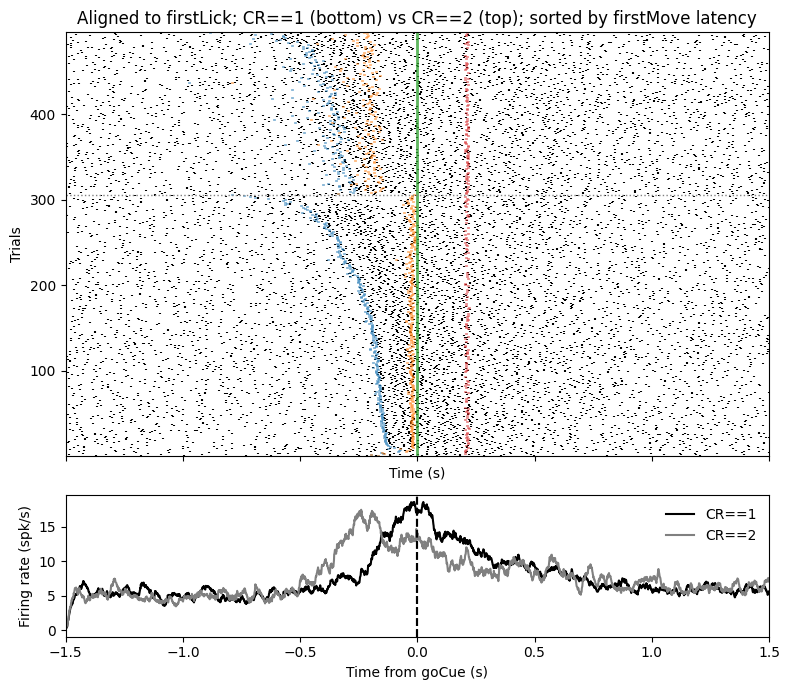

In [88]:
# Compute group PSTHs
raster_cr1 = rp.raster[:split_idx, :]   # rows corresponding to CR==1
raster_cr2 = rp.raster[split_idx:, :]   # rows corresponding to CR==2

psth1, _ = compute_psth(raster_cr1, bin_size=rp.bin_size)  # CR==1
psth2, _ = compute_psth(raster_cr2, bin_size=rp.bin_size)  # CR==2

# Smooth
psth1_sm = smooth_vector(psth1, bin_size=rp.bin_size, sigma=0.025)
psth2_sm = smooth_vector(psth2, bin_size=rp.bin_size, sigma=0.025)

# Plot with your function
fig, (ax_raster, ax_psth) = plt.subplots(2, 1, figsize=(8, 7),
                                         sharex=True,
                                         gridspec_kw={'height_ratios':[3,1]})

# Raster
rp.plot_raster(ax_raster, spike_color='black')
rp.add_events(ax_raster, events)
ax_raster.set_title(f'Aligned to {align_key}; CR==1 (bottom) vs CR==2 (top); sorted by {sort_key} latency')
ax_raster.axhline(split_idx, color='gray', linestyle=':', linewidth=1)
ax_raster.set_ylabel('Trials')

# PSTHs — only smoothed, with custom colors
plot_psth(rp.bins, psth1, psth1_sm,
          ax=ax_psth, label='CR==1',
          plot_raw=False, color='black')
plot_psth(rp.bins, psth2, psth2_sm,
          ax=ax_psth, label='CR==2',
          plot_raw=False, color='gray')

ax_psth.set_xlabel('Time from goCue (s)')
ax_psth.set_ylabel('Firing rate (spk/s)')
ax_psth.legend(frameon=False)
plt.tight_layout()
plt.show()


In [68]:
win_start, win_end = 0.0, 0.035  # seconds relative to goCue

# Find bin indices that fall in the window
bin_mask = (rp.bins >= win_start) & (rp.bins < win_end)

# Trial-wise spike counts (sum across selected bins)
counts = rp.raster[:, bin_mask].sum(axis=1)

# Split by groups
counts_cr1 = counts[:split_idx]   # CR==1
counts_cr2 = counts[split_idx:]   # CR==2


In [69]:
from scipy.stats import mannwhitneyu
stat, pval = mannwhitneyu(counts_cr1, counts_cr2, alternative='two-sided')
stat, pval

(np.float64(25109.5), np.float64(0.005174002591131878))

In [70]:
import numpy as np

observed = counts_cr1.mean() - counts_cr2.mean()
all_counts = np.concatenate([counts_cr1, counts_cr2])
n1 = len(counts_cr1)
n_perm = 10000

diffs = []
rng = np.random.default_rng()
for _ in range(n_perm):
    rng.shuffle(all_counts)
    diffs.append(all_counts[:n1].mean() - all_counts[n1:].mean())

diffs = np.array(diffs)
pval = (np.abs(diffs) >= abs(observed)).mean()
pval

np.float64(0.0062)

In [71]:
print(f"CR==1 mean: {counts_cr1.mean():.2f} spikes/trial")
print(f"CR==2 mean: {counts_cr2.mean():.2f} spikes/trial")
print(f"Permutation test p={pval:.4f}")


CR==1 mean: 0.46 spikes/trial
CR==2 mean: 0.62 spikes/trial
Permutation test p=0.0062


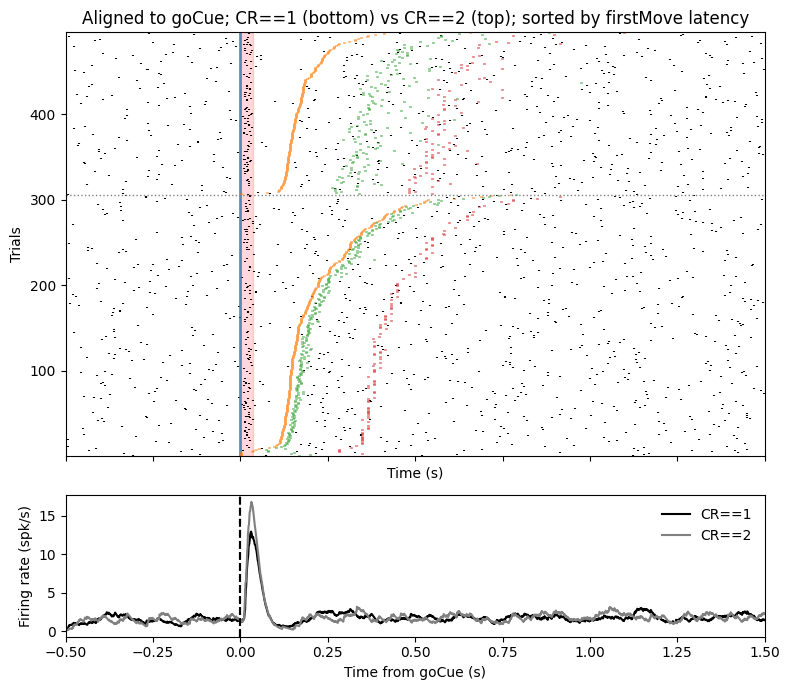

In [73]:
win_start, win_end = 0.0, 0.035  # seconds relative to goCue

# Compute group PSTHs
raster_cr1 = rp.raster[:split_idx, :]   # rows corresponding to CR==1
raster_cr2 = rp.raster[split_idx:, :]   # rows corresponding to CR==2

psth1, _ = compute_psth(raster_cr1, bin_size=rp.bin_size)  # CR==1
psth2, _ = compute_psth(raster_cr2, bin_size=rp.bin_size)  # CR==2

# Smooth
psth1_sm = smooth_vector(psth1, bin_size=rp.bin_size, sigma=0.025)
psth2_sm = smooth_vector(psth2, bin_size=rp.bin_size, sigma=0.025)

# Plot
fig, (ax_raster, ax_psth) = plt.subplots(
    2, 1, figsize=(8, 7),
    sharex=True,
    gridspec_kw={'height_ratios':[3,1]}
)

# Raster
rp.plot_raster(ax_raster, spike_color='black')
rp.add_events(ax_raster, events)
ax_raster.set_title('Aligned to goCue; CR==1 (bottom) vs CR==2 (top); sorted by firstMove latency')
ax_raster.axhline(split_idx, color='gray', linestyle=':', linewidth=1)
ax_raster.set_ylabel('Trials')

# PSTHs — only smoothed, with custom colors
plot_psth(rp.bins, psth1, psth1_sm,
          ax=ax_psth, label='CR==1',
          plot_raw=False, color='black')
plot_psth(rp.bins, psth2, psth2_sm,
          ax=ax_psth, label='CR==2',
          plot_raw=False, color='gray')

# Highlight analysis window
ax_raster.axvspan(win_start, win_end, color='red', alpha=0.15, label='Analysis window')

ax_psth.set_xlabel('Time from goCue (s)')
ax_psth.set_ylabel('Firing rate (spk/s)')
ax_psth.legend(frameon=False)
plt.tight_layout()
plt.show()


In [ ]:
#GLM

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# --- 0) Ensure sorted regular grid ---
df = tongue_kinematics.sort_values('time_in_session').copy()

# Estimate frame interval (use median to be robust)
dt = np.median(np.diff(df['time_in_session'].dropna().values))  # seconds per frame

# Bin spikes on the full grid BEFORE any filtering
bins = np.append(df['time_in_session'].values,
                 df['time_in_session'].values[-1] + dt)
spike_counts, _ = np.histogram(spikes, bins=bins)
df['spike_count'] = spike_counts

# --- 1) Build time-based lags on the FULL dataframe (no dropping yet) ---
def add_time_lags(df, predictors, lag_seconds):
    """
    Add lagged columns to df by shifting rows, using the original grid.
    lag_seconds: list of non-positive lags (e.g., [0, -0.02, -0.04])
    """
    out = df.copy()
    frames_per_lag = {L: int(round(L / dt)) for L in lag_seconds}  # negative => past
    for p in predictors:
        for L in lag_seconds:
            k = frames_per_lag[L]
            out[f'{p}_lag{L:+.3f}s'] = out[p].shift(-k)  # negative L -> positive shift
    return out

predictors = ['x','y','v','xv','yv']  # what you want to use
lag_seconds = [0.0]                   # start simple; later extend like [0.0, -dt, -2*dt, ...]
df_lagged = add_time_lags(df, predictors, lag_seconds)

# --- 2) Now define the rows you’ll actually fit on ---
# Option A (strict): require current AND all lagged predictors to be present
lag_cols = [c for c in df_lagged.columns if any(c.startswith(p+'_lag') for p in predictors)]
fit_mask = df_lagged[lag_cols].notna().all(axis=1) & df_lagged['spike_count'].notna()

# This *automatically* drops rows at edges of occlusions where a lag would land in NaN.

# --- 3) Build X, y and fit GLM ---
X = df_lagged.loc[fit_mask, lag_cols]
y = df_lagged.loc[fit_mask, 'spike_count']

# (Optional) scale predictors after masking; scaling won’t break lag timing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_const = sm.add_constant(X_scaled)
model = sm.GLM(y, X_const, family=sm.families.Poisson())
results = model.fit()
print(results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:            spike_count   No. Observations:               334138
Model:                            GLM   Df Residuals:                   334132
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -35001.
Date:                Fri, 12 Sep 2025   Deviance:                       55474.
Time:                        17:46:30   Pearson chi2:                 3.27e+05
No. Iterations:                     7   Pseudo R-squ. (CS):          0.0005272
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.8406      0.012   -323.321      0.0

In [ ]:
import numpy as np, pandas as pd, statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

df = tongue_kinematics.sort_values('time_in_session').copy()
dt = float(np.median(np.diff(df['time_in_session'].dropna().values)))

# Bin spikes on the same grid
bins = np.append(df['time_in_session'].values, df['time_in_session'].values[-1] + dt)
spike_counts, _ = np.histogram(spikes, bins=bins)
df['spike_count'] = spike_counts

predictors = ['x','y','v','xv','yv']
lags = np.arange(-0.5, 0.5 + 1e-12, 0.02)  # seconds

def add_lag(df, col, lag_s, dt):
    k = int(np.rint(lag_s / dt))
    return df[col].shift(-k)  # negative lag -> past -> positive shift

rows = []
for L in lags:
    # Build X for this single lag (all predictors at the same lag)
    X = pd.DataFrame({f'{p}_lag{L:+.3f}s': add_lag(df, p, L, dt) for p in predictors})
    y = df['spike_count']

    mask = X.notna().all(axis=1) & y.notna()
    Xm = X.loc[mask]
    ym = y.loc[mask]

    if len(Xm) == 0:
        rows.append({'lag_s': L, 'n': 0, 'ok': False})
        continue

    # scale
    scaler = StandardScaler()
    Xs = scaler.fit_transform(Xm)

    Xc = sm.add_constant(Xs)
    model = sm.GLM(ym, Xc, family=sm.families.Poisson())
    res = model.fit()

    rows.append({
        'lag_s': L,
        'n': int(len(ym)),
        'ok': True,
        'llf': float(res.llf),
        'deviance': float(res.deviance),
        'pseudoR2_CS': float(res.null_deviance - res.deviance) / float(res.null_deviance + 1e-12)
    })
    # you can also stash full coef vectors if you want:
    # for name, b in zip(res.model.exog_names, res.params):
    #     if name != 'const': store them keyed by (L, var)

lag_sweep = pd.DataFrame(rows)


In [ ]:
import numpy as np, pandas as pd, statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# --- Prelim (from your setup) ---
df = tongue_kinematics.sort_values('time_in_session').copy()
dt = float(np.median(np.diff(df['time_in_session'].dropna().values)))

bins = np.append(df['time_in_session'].values, df['time_in_session'].values[-1] + dt)
spike_counts, _ = np.histogram(spikes, bins=bins)
df['spike_count'] = spike_counts

predictors = ['x','y','v','xv','yv']
lags = np.arange(-0.5, 0.5 + 1e-12, 0.01)  # seconds

def add_lag(series, lag_s, dt):
    k = int(np.rint(lag_s / dt))
    return series.shift(-k)  # negative lag -> past

# --- Sweep lags, fit one model per lag, store results ---
metrics_rows = []
coef_rows = []

for L in lags:
    # Build X for this lag (keep column names!)
    X = pd.DataFrame({f'{p}_lag{L:+.3f}s': add_lag(df[p], L, dt) for p in predictors})
    y = df['spike_count']

    mask = X.notna().all(axis=1) & y.notna()
    if not mask.any():
        metrics_rows.append({'lag_s': L, 'n': 0, 'ok': False, 'llf': np.nan,
                             'deviance': np.nan, 'null_deviance': np.nan,
                             'pseudoR2_CS': np.nan, 'aic': np.nan})
        continue

    Xm = X.loc[mask]
    ym = y.loc[mask]

    # Scale, then wrap back into a DataFrame to preserve names
    scaler = StandardScaler()
    Xs_np = scaler.fit_transform(Xm)
    Xs = pd.DataFrame(Xs_np, index=Xm.index, columns=Xm.columns)

    # Add intercept
    Xc = sm.add_constant(Xs, has_constant='add')

    res = sm.GLM(ym, Xc, family=sm.families.Poisson()).fit()

    # ---- metrics ----
    null_dev = float(res.null_deviance)
    dev = float(res.deviance)
    pseudoR2_CS = (null_dev - dev) / (null_dev + 1e-12)
    metrics_rows.append({
        'lag_s': L,
        'n': int(len(ym)),
        'ok': True,
        'llf': float(res.llf),
        'deviance': dev,
        'null_deviance': null_dev,
        'pseudoR2_CS': pseudoR2_CS,
        'aic': float(res.aic),
    })

    # ---- coefficients (exclude intercept) ----
    # Map params back to names using Xs.columns
    # res.params order == ['const'] + list(Xs.columns)
    for name, b, se, p in zip(Xs.columns, res.params[1:], res.bse[1:], res.pvalues[1:]):
        # name looks like 'xv_lag-0.200s'
        var, lag_tag = name.split('_lag')
        lag_val = float(lag_tag.replace('s', ''))  # seconds
        coef_rows.append({
            'var': var,
            'lag_s': lag_val,
            'beta': float(b),
            'se': float(se),
            'p': float(p),
            'beta_lo95': float(b - 1.96*se),
            'beta_hi95': float(b + 1.96*se),
        })

lag_metrics = pd.DataFrame(metrics_rows).sort_values('lag_s').reset_index(drop=True)
lag_coefs = pd.DataFrame(coef_rows).sort_values(['var','lag_s']).reset_index(drop=True)


ValueError: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.

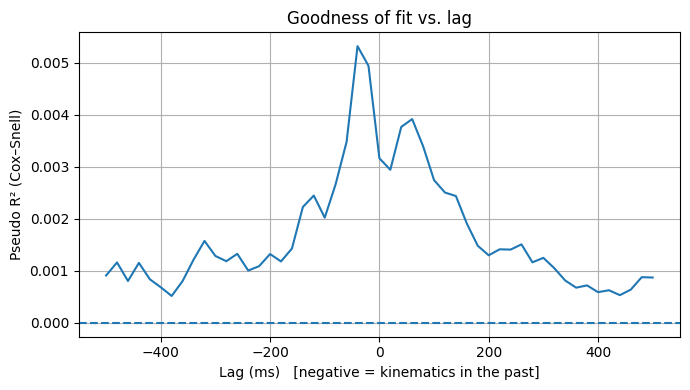

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(lag_metrics['lag_s']*1000, lag_metrics['pseudoR2_CS'])
plt.axhline(0, linestyle='--')
plt.xlabel('Lag (ms)   [negative = kinematics in the past]')
plt.ylabel('Pseudo R² (Cox–Snell)')
plt.title('Goodness of fit vs. lag')
plt.grid(True)
plt.tight_layout()
plt.show()


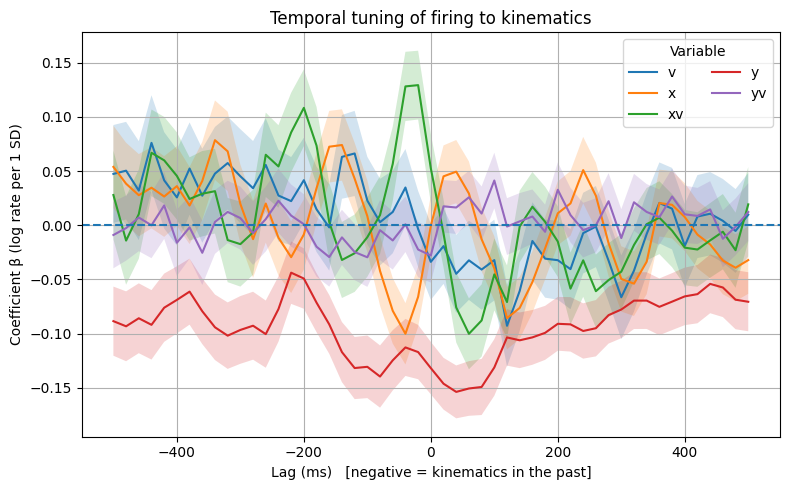

In [ ]:
# One overlayed plot: each variable gets a line + shaded CI
plt.figure(figsize=(8,5))
for var, grp in lag_coefs.groupby('var'):
    grp = grp.sort_values('lag_s')
    x = grp['lag_s']*1000  # ms
    y = grp['beta']
    lo = grp['beta_lo95']
    hi = grp['beta_hi95']
    plt.plot(x, y, label=var)
    plt.fill_between(x, lo, hi, alpha=0.2)

plt.axhline(0, linestyle='--')
plt.xlabel('Lag (ms)   [negative = kinematics in the past]')
plt.ylabel('Coefficient β (log rate per 1 SD)')
plt.title('Temporal tuning of firing to kinematics')
plt.grid(True)
plt.legend(title='Variable', ncol=2)
plt.tight_layout()
plt.show()


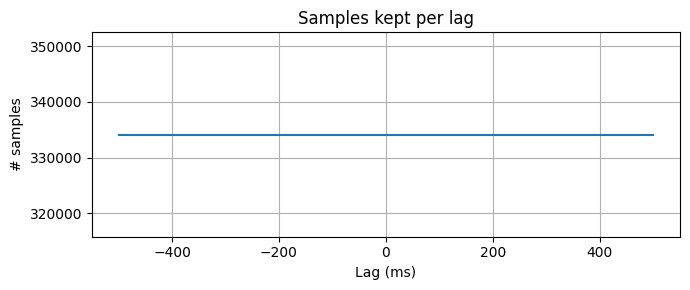

In [ ]:
plt.figure(figsize=(7,3))
plt.plot(lag_metrics['lag_s']*1000, lag_metrics['n'])
plt.xlabel('Lag (ms)'); plt.ylabel('# samples'); plt.title('Samples kept per lag')
plt.grid(True); plt.tight_layout(); plt.show()


In [45]:
import json
import pandas as pd


#mask units

# — your existing mapping from JSON keys to DataFrame columns —
col_map = {
    'isi_violations': 'isi_violations_ratio',
    # 'p_max':          'p_max',
    # 'lat_max_p':      'lat_max_p',
    # 'eu':             'euc_max_p',
    # 'corr':           'corr_max_p',
    'qc_pass':        'default_qc',
    'peak':           'peak',
    'in_df':          'real_unit',
}

# load filters
with open('/root/capsule/scratch/beh_all.json','r') as f:
    filters = json.load(f)

# initialize cumulative mask (start with all True)
mask = pd.Series(True, index=ephys_data.index)

for key, spec in filters.items():
    col = col_map.get(key)
    if col not in ephys_data.columns:
        print(f"\n no column mapped for filter '{key}' → skipping")
        continue

    print(f"\nFilter '{key}' → column '{col}':")
    series = ephys_data[col]

    # build this-filter mask
    this_mask = pd.Series(True, index=series.index)

    # bounds check
    if 'bounds' in spec:
        lo, hi = spec['bounds']
        inside_bounds = series.between(lo, hi)
        outside = (~inside_bounds & mask).sum()
        total   = mask.sum()
        this_mask &= inside_bounds
        print(f"  JSON bounds: [{lo}, {hi}]")
        print(f"  {outside}/{total} rows in the CURRENT set ({outside/total:.1%}) would be filtered by this bound")

    # membership check
    if 'items' in spec:
        allowed = set(spec['items'])
        in_items = series.isin(allowed)
        outside = (~in_items & mask).sum()
        total   = mask.sum()
        this_mask &= in_items
        print(f"  JSON items: {allowed}")
        print(f"  {outside}/{total} rows in the CURRENT set ({outside/total:.1%}) would be filtered by this membership")

    # update the cumulative mask
    mask &= this_mask

# final summary
total_units    = len(mask)
kept_units     = mask.sum()
filtered_units = total_units - kept_units
print(f"\n **FINAL**: out of {total_units} neurons, {filtered_units} ({filtered_units/total_units:.1%}) are filtered out, leaving {kept_units} units.")


FileNotFoundError: [Errno 2] No such file or directory: '/root/capsule/scratch/beh_all.json'

In [34]:
# passing_units = ephys_data[mask]
# unit_list = list(range(passing_units.shape[0]))

# with PdfPages('/root/capsule/scratch/figures/masked_units_raster_psth_alignments_recheck.pdf') as pdf:
#     for unit_n in unit_list:
#         spikes = ephys_data.iloc[unit_n]['spike_times_in_session']
#         fig = plot_unit_panels(
#             spikes,
#             unit_n,
#             trials,
#             event_dicts,
#             combos,
#             events_to_plot=['goCue', 'firstMove', 'firstLick', 'reward'],  # or None
#             pre=1.0,
#             post=2.0,
#             bin_size=0.001,
#             sigma=0.025
#         )
#         pdf.savefig(fig)
#         plt.close(fig)

# # print("✅ Saved all_units_raster_psth.pdf")